## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2021.

# Assignment 1, Task 2: Multilayer Perceptron (MLP)
You will get to know how to build basic fully connected neural network.

In [4]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import time
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [5]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Basic layers
In this part, all the functions will be created from scratch using numpy for better understanding. (In the next task, you will be introduced to built in layers from TensorFlow.)

### Create basic layer functions

<span style="color:red"><strong>TODO</strong></span>: Complete functions **affine_forward**, **affine_backward** in **./utils/layer_funcs.py**.

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [6]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.layer_funcs import affine_forward
from utils.layer_funcs import affine_backward

# generate data for checking
x = X_dev
w = np.random.rand(x.shape[1],100)
b = np.random.rand(100)
dout = np.ones((x.shape[0],100))

## Affine function: H = W*X + b
out = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, x, w, b)

## check your implementation using the tf.gradients_function()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def affine_layer(x, w, b):
    return tf.matmul(x, w) + b

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = affine_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))

out_check = out_tf.numpy()
dx_check, dw_check, db_check = dx_tf.numpy(), dw_tf.numpy(), db_tf.numpy()

## Print validation results
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **relu_forward**, **relu_backward** in **./utils/layer_funcs.py**.


<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [7]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.layer_funcs import relu_forward
from utils.layer_funcs import relu_backward

## Activation layers -- Here we introduce ReLU activation function
## since it is the most commonly used in computer vision problems.
## However, you can also try to implement 
## other activation functions like sigmoid, tanh etc.
x = X_dev
dout = np.ones(x.shape)

## ReLU
out = relu_forward(x)
dx = relu_backward(dout, x)

## check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
with tf.GradientTape() as tape:
    tape.watch(x_tf)
    out_tf = tf.nn.relu(x_tf)
    grad_gt = tape.gradient(out_tf, x_tf)

out_check = out_tf.numpy()
dx_check = grad_gt.numpy()

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **softmax_loss** in **./utils/layer_funcs.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [8]:
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #

from utils.layer_funcs import softmax_loss

## generate some random data for testing
x = np.random.rand(100,20)
y = np.argmax(x, axis=1)

loss, dx = softmax_loss(x, y)

## check by tf.GradientTape.gradients()

x_tf = tf.Variable(x, name='x')
y_tf = tf.Variable(y, name='y')

with tf.GradientTape() as tape:
    tape.watch(x_tf)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= x_tf, labels=tf.one_hot(y_tf,20))
    loss_tf = tf.reduce_mean(cross_entropy)
    dx_tf = tape.gradient(loss_tf, x_tf)

loss_check = loss_tf.numpy()
dx_check = dx_tf.numpy()
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

# print(dx)
# print(dx_check)

Is loss correct? True
Is dx correct? True


### Create a single layer

Combine an affine function and a nonlinear activation function into a single fully-connected layer. Edit the code in ./utils/layer_utils.py

$$\mathbf{O} = activation(\mathbf{W} \times \mathbf{X} + \mathbf{b})$$

For this assignment, you need to create two types of layers as below. You can get started with the skeleton code in ./utils/layer_utils.py. The basic class structure has been provided, and you need to fill in the "TODO" part(s). 

* DenseLayer -- Affine transform >> ReLU
```
Class DenseLayer:
    Variables: weights, bias 
    Functions: 
        __init__: given (input_dim, output_dim, weight_scale)
        feedforward: TODO
        backforward: TODO      
```    
* AffineLayer -- Affine transform and the class structure is similar to DenseLayer

<span style="color:red"><strong>TODO</strong></span>: Complete function **AffineLayer** in **./utils/layer_utils.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [9]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.layer_utils import AffineLayer

## Affine
test_affine = AffineLayer(input_dim=X_train.shape[1],output_dim=100)
w, b = test_affine.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_affine.feedforward(x)
dx = test_affine.backward(dout)
dw, db = test_affine.gradients

## check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def affine_layer(x, w, b):
    return tf.matmul(x, w) + b

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = affine_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))
    
out_check = out_tf.numpy()
dx_check = dx_tf.numpy()
dw_check = dw_tf.numpy()
db_check = db_tf.numpy()

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))
print(db,db_check,db.shape,db_check.shape)

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100.] [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.

<span style="color:red"><strong>TODO</strong></span>: Complete function **DenseLayer** in **./utils/layer_utils.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [10]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

## First, let's make a dense layer
from utils.layer_utils import DenseLayer

## Affine + ReLU
test_dense = DenseLayer(input_dim=X_train.shape[1],output_dim=100)
w, b = test_dense.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_dense.feedforward(x)
dx = test_dense.backward(dout)
dw, db = test_dense.gradients

## check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def dense_layer(x, w, b):
    return tf.nn.relu(tf.matmul(x, w) + b)

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = dense_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))
    
out_check = out_tf.numpy()
dx_check = dx_tf.numpy()
dw_check = dw_tf.numpy()
db_check = db_tf.numpy()

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

# print(db,"\n\n",db_check)

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


## Part 2: Two Layer Network

Complete the class **TwoLayerNet** in **./utils/classifiers/twolayernet.py**. Through this experiment, you will create a two-layer neural network and learn about the backpropagation mechanism. The network structure is like **input >> DenseLayer >> AffineLayer >> softmax loss >> output**. Complete "TODO" part(s).
```
Class TwoLayerNet:   
    Functions: 
        __init__: GIVEN
        loss: TODO - calculate cross entropy loss and gradients wst all weights and bias.
        step: TODO - a single update all weights and bias by SGD.
        predict: TODO - output result(classification accuracy) based on input data
    
    Variables:
        layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete class **TwoLayerNet** in **./utils/classifiers/twolayernet.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [35]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.classifiers.twolayernet import TwoLayerNet

## Define a model
model = TwoLayerNet(input_dim=X_train.shape[1], hidden_dim=100, num_classes=20, reg=1e-4)
W1, b1 = model.layer1.params
W2, b2 = model.layer2.params

print(W1.shape, b1.shape, W2.shape,b2.shape)

## Backprogation -- Finish loss function and gradients calculation in TwoLayerNet
loss = model.loss(X_dev, y_dev)

## Check loss by tensorflow
x_tf = tf.Variable(X_dev, dtype = tf.float32)
y_tf = tf.Variable(y_dev, dtype = tf.uint8)

W1_tf = tf.Variable(W1.astype('float32'))
b1_tf = tf.Variable(b1.astype('float32'))
W2_tf = tf.Variable(W2.astype('float32'))
b2_tf = tf.Variable(b2.astype('float32'))
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf))
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h2_tf, labels=tf.one_hot(y_tf,20))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + 1e-4 * L2_loss 

loss_check=loss_tf.numpy()
    
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))

(784, 100) (100,) (100, 20) (20,)
Is loss correct? True


### Train a two-layer network

#### Import functions for training and testing

In [36]:
from utils.train_funcs import train, test

#### Start training
We have provide you the **train( )** function in **./utils/train_func.py**

In [39]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                        #

from utils.classifiers.twolayernet import TwoLayerNet

## TODO: Use previous layers to create a two layer neural network
## input->(affine->activation)->(affine->softmax)->output
## The recommended activation function is ReLU. And you can 
## also make a comparison with other activation function to see
## any difference.
model = TwoLayerNet(input_dim=X_train.shape[1], hidden_dim=400, num_classes=20, reg=1e-4, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 5e-4
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
5000/49000 loss: 2.7929669962454726
10000/49000 loss: 2.8557622067766104
15000/49000 loss: 2.538328482468993
20000/49000 loss: 2.64743154924006
25000/49000 loss: 2.112237874928677
30000/49000 loss: 1.9892502148824458
35000/49000 loss: 1.9913466941385798
40000/49000 loss: 1.6460990974141316
45000/49000 loss: 1.3692100032407932
epoch 1: valid acc = 0.523, new learning rate = 0.000475
5000/49000 loss: 1.2774829915455232
10000/49000 loss: 1.140448894205564
15000/49000 loss: 1.0811930358950188
20000/49000 loss: 1.0389434070377683
25000/49000 loss: 1.05307032974229
30000/49000 loss: 0.9980220696692561
35000/49000 loss: 1.1390166833465096
40000/49000 loss: 0.9508307027802055
45000/49000 loss: 0.933545472690002
epoch 2: valid acc = 0.715, new learning rate = 0.00045125
5000/49000 loss: 0.7948704780246241
10000/49000 loss: 0.8127942826524689
15000/49000 loss: 0.7470226662274086
20000/49000 loss: 0.7194468675692463
25000/49000 loss: 0.709286900791974
30000/4900

0.8286

<span style="color:red"><strong>TODO</strong></span>: Plot training and validation accuracy history of each epoch

<span style="color:red"><strong>Solution</strong></span>:

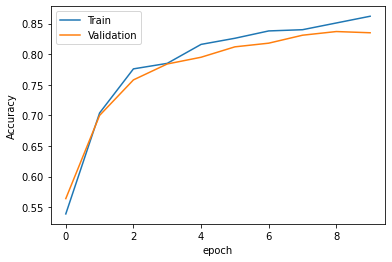

In [20]:
plt.plot(train_acc_hist, label='Train')
plt.plot(val_acc_hist, label = 'Validation' )
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Visulize the weight variable in the first layer.

Visualization of the intermediate weights can help you get an intuitive understanding of how the network works, especially in  Convolutional Neural Networks (CNNs).

In [21]:
from utils.display_funcs import visualize_pics

num of feature vectors: 400


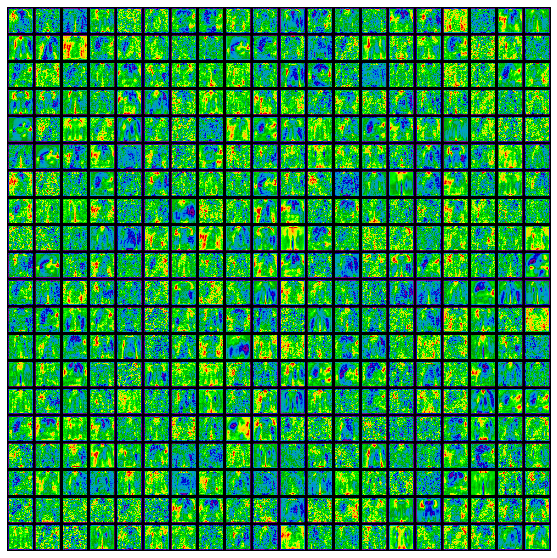

In [22]:
weights = model.layer1.params[0]
pics = weights.reshape(1, X_train_raw.shape[1], X_train_raw.shape[2], -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics, cmap='nipy_spectral')

### Get test accuracy greater than 80%

For this part, you need to train a better two-layer net. The requirement is to get test accuracy better than 35%. If your accuracy is lower, for each 1% lower than 35%, you will lose 1 point (There are totally 10 points for this part).

Here are some recommended methods for improving the performance. Feel free to try any other method as you see fit.

1. Hyperparameter tuning: reg, hidden_dim, lr, learning_decay, num_epoch, batch_size, weight_scale.
2. Adjust training strategy: Randomly select a batch of samples rather than selecting them orderly. 
3. Try new optimization methods: Now we are using SGD, you can try SGD with momentum, adam, etc.
4. Early-stopping.
5. Good (better) initial values for weights in the model.

A comparison between SGD and SGD with momentum.

* Stochastic gradient descent - SGD
    ```
    w = w - learning_rate * gradient 
    ```
* SGD with momentum
    ```
    v = momentum*v + learning_rate * gradient
    w = w - v
    ```

<span style="color:red"><strong>TODO</strong></span>: See below

In [ ]:
from utils.classifiers.twolayernet import TwoLayerNet
# TODO: Use previous layers to create a two layer neural network.
# Try several solutions and report the best performing one.
# input->(affine->activation)->(affine->softmax)->output
# The recommended activation function is ReLU. You can 
# make a comparison with other activation functions to see
# the differences.
#
# You will need to execute code similar to the code below, using your parameter specs:
#    model = TwoLayerNet(input_dim=TBD, hidden_dim=TBD, num_classes=TBD, reg=TBD, weight_scale=TBD)
#    num_epoch = TBD
#    batch_size = TBD
#    lr = TBD
#    verbose = TBD
#    train_acc_hist, val_acc_hist = train(TBD)
#    test(TBD, TBD, TBD)



<span style="color:red"><strong>Solution</strong></span>:

In [52]:
from utils.classifiers.twolayernet import TwoLayerNet

num_epochs = [10,30,50]
batch_sizes = [200,600,1000] 
hidden_dims = [100,400,700]
lr_rates = [0.01,0.001,0.0001]
verboses = [True,False]

results = []

for hidden_dim in hidden_dims:
    for num_epoch in num_epochs:
        for batch_size in batch_sizes:
            for lr_rate in lr_rates:
                for verbose in verboses:
                    
                    model = TwoLayerNet(input_dim=X_train.shape[1], hidden_dim=hidden_dim, num_classes=20, reg=1e-4, weight_scale=1e-3)

                    train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                          num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
                    results.append([test(model, X_train, y_train), test(model, X_val, y_val), test(model, X_test, y_test)])


number of batches for training: 245
2000/49000 loss: 2.7065869963051683
4000/49000 loss: 2.5920426445906353
6000/49000 loss: 2.6325152703432377
8000/49000 loss: 2.49792504246436
10000/49000 loss: 2.3943323484361967
12000/49000 loss: 2.141051117884743
14000/49000 loss: 1.894299452191484
16000/49000 loss: 1.58210088712369
18000/49000 loss: 1.3882290848731573
20000/49000 loss: 1.293648998737616
22000/49000 loss: 1.2370810983833351
24000/49000 loss: 1.114070294838058
26000/49000 loss: 1.0084617044873816
28000/49000 loss: 1.1660891270501745
30000/49000 loss: 0.9385969920575883
32000/49000 loss: 1.043270289154694
34000/49000 loss: 1.0330290705071699
36000/49000 loss: 0.9083824454352597
38000/49000 loss: 0.8572594607770633
40000/49000 loss: 0.8608978298234621
42000/49000 loss: 0.8433380243449327
44000/49000 loss: 0.810041782602103
46000/49000 loss: 0.7474118529157241
48000/49000 loss: 0.6468064274663375
epoch 1: valid acc = 0.751, new learning rate = 0.000475
2000/49000 loss: 0.72918815350809

42000/49000 loss: 0.37378633305499404
44000/49000 loss: 0.36676796356850655
46000/49000 loss: 0.342244389472868
48000/49000 loss: 0.31128865099810077
epoch 9: valid acc = 0.872, new learning rate = 0.0003151247048623045
2000/49000 loss: 0.3628392816000867
4000/49000 loss: 0.40748546833723465
6000/49000 loss: 0.32310886803892164
8000/49000 loss: 0.35866690290100334
10000/49000 loss: 0.35142991599074364
12000/49000 loss: 0.3811317905777134
14000/49000 loss: 0.4003084732351235
16000/49000 loss: 0.29979770100828695
18000/49000 loss: 0.38948657948600246
20000/49000 loss: 0.39247861713953525
22000/49000 loss: 0.42147518659639477
24000/49000 loss: 0.41542296889058966
26000/49000 loss: 0.4629530709730824
28000/49000 loss: 0.43674107327256073
30000/49000 loss: 0.4429241264179587
32000/49000 loss: 0.3138663939532909
34000/49000 loss: 0.38747657861961815
36000/49000 loss: 0.3826814997703399
38000/49000 loss: 0.23558975004097926
40000/49000 loss: 0.3903497161995078
42000/49000 loss: 0.400261619528

38000/49000 loss: 0.28105102402359333
40000/49000 loss: 0.36343602672309
42000/49000 loss: 0.3628298488946769
44000/49000 loss: 0.3724630767923716
46000/49000 loss: 0.35755695039511426
48000/49000 loss: 0.3078462640401599
epoch 7: valid acc = 0.856, new learning rate = 0.00034916864804687486
2000/49000 loss: 0.414559267523379
4000/49000 loss: 0.25760534860040557
6000/49000 loss: 0.3705277235989159
8000/49000 loss: 0.4388758521870053
10000/49000 loss: 0.32148049687137903
12000/49000 loss: 0.2997450584887097
14000/49000 loss: 0.4020452324008127
16000/49000 loss: 0.3516047243253015
18000/49000 loss: 0.3784355274510141
20000/49000 loss: 0.46104634754941404
22000/49000 loss: 0.3639279339622073
24000/49000 loss: 0.4092217968666388
26000/49000 loss: 0.37671945630377407
28000/49000 loss: 0.3707322706813852
30000/49000 loss: 0.28444124819866445
32000/49000 loss: 0.372830315022912
34000/49000 loss: 0.40156356146696714
36000/49000 loss: 0.39419236678035163
38000/49000 loss: 0.39947366728059075
40

24000/49000 loss: 0.4800629080213573
26000/49000 loss: 0.42112079652990736
28000/49000 loss: 0.4292728347657613
30000/49000 loss: 0.4743683363701268
32000/49000 loss: 0.36449614692251864
34000/49000 loss: 0.4624441827822784
36000/49000 loss: 0.2887644356573024
38000/49000 loss: 0.4677073467739531
40000/49000 loss: 0.46967525955134326
42000/49000 loss: 0.4026739527524817
44000/49000 loss: 0.42188911253777517
46000/49000 loss: 0.4063234285996927
48000/49000 loss: 0.395782054968993
epoch 5: valid acc = 0.856, new learning rate = 0.0003868904687499999
2000/49000 loss: 0.40129604539488517
4000/49000 loss: 0.41476249377243296
6000/49000 loss: 0.33770318332748045
8000/49000 loss: 0.34811041910618007
10000/49000 loss: 0.4905191452111587
12000/49000 loss: 0.4030580479540777
14000/49000 loss: 0.42974149440061005
16000/49000 loss: 0.35986191595118205
18000/49000 loss: 0.4688497289445583
20000/49000 loss: 0.39769048556496644
22000/49000 loss: 0.4096900695926644
24000/49000 loss: 0.5262807959824044

36000/49000 loss: 0.5639236535647646
42000/49000 loss: 0.5270697862574034
48000/49000 loss: 0.5436846951829868
epoch 6: valid acc = 0.806, new learning rate = 0.0003675459453124999
6000/49000 loss: 0.5168832807326
12000/49000 loss: 0.5350164279824539
18000/49000 loss: 0.5316973368919796
24000/49000 loss: 0.5398169942074243
30000/49000 loss: 0.5399951526653197
36000/49000 loss: 0.5310554715144759
42000/49000 loss: 0.49996771538809165
48000/49000 loss: 0.5092839030729363
epoch 7: valid acc = 0.817, new learning rate = 0.00034916864804687486
6000/49000 loss: 0.5058446340184042
12000/49000 loss: 0.527418961315107
18000/49000 loss: 0.45355069982109825
24000/49000 loss: 0.4953460689867282
30000/49000 loss: 0.44911249807864767
36000/49000 loss: 0.4885909203599581
42000/49000 loss: 0.46542467962597384
48000/49000 loss: 0.47244696502743233
epoch 8: valid acc = 0.829, new learning rate = 0.0003317102156445311
6000/49000 loss: 0.49732106820371536
12000/49000 loss: 0.4894974767609034
18000/49000 l

48000/49000 loss: 0.6276192728531582
epoch 4: valid acc = 0.766, new learning rate = 0.00040725312499999993
6000/49000 loss: 0.5854883308878285
12000/49000 loss: 0.5922033345146891
18000/49000 loss: 0.6183662455912416
24000/49000 loss: 0.6488516176964705
30000/49000 loss: 0.5699012906156685
36000/49000 loss: 0.5994137836370541
42000/49000 loss: 0.5460570116649726
48000/49000 loss: 0.616282124632062
epoch 5: valid acc = 0.785, new learning rate = 0.0003868904687499999
6000/49000 loss: 0.5587797421775503
12000/49000 loss: 0.5598004984276477
18000/49000 loss: 0.550974492341463
24000/49000 loss: 0.638132417906512
30000/49000 loss: 0.5729644009603996
36000/49000 loss: 0.5818409543053995
42000/49000 loss: 0.5498762954174213
48000/49000 loss: 0.535958958886622
epoch 6: valid acc = 0.801, new learning rate = 0.0003675459453124999
6000/49000 loss: 0.5590036522702374
12000/49000 loss: 0.49465720352524245
18000/49000 loss: 0.544046921789734
24000/49000 loss: 0.46103064499618723
30000/49000 loss: 

epoch 10: valid acc = 0.796, new learning rate = 0.00029936846961918924
test acc: 0.8002448979591836
test acc: 0.796
test acc: 0.7905
number of batches for training: 49
epoch 1: valid acc = 0.39, new learning rate = 0.000475
epoch 2: valid acc = 0.512, new learning rate = 0.00045125
epoch 3: valid acc = 0.585, new learning rate = 0.0004286875
epoch 4: valid acc = 0.703, new learning rate = 0.00040725312499999993
epoch 5: valid acc = 0.729, new learning rate = 0.0003868904687499999
epoch 6: valid acc = 0.744, new learning rate = 0.0003675459453124999
epoch 7: valid acc = 0.758, new learning rate = 0.00034916864804687486
epoch 8: valid acc = 0.778, new learning rate = 0.0003317102156445311
epoch 9: valid acc = 0.785, new learning rate = 0.0003151247048623045
epoch 10: valid acc = 0.792, new learning rate = 0.00029936846961918924
test acc: 0.7978571428571428
test acc: 0.792
test acc: 0.7887
number of batches for training: 49
10000/49000 loss: 2.656814330914043
20000/49000 loss: 2.61984638

42000/49000 loss: 0.3244879822784691
44000/49000 loss: 0.4076165431417475
46000/49000 loss: 0.32590233437795124
48000/49000 loss: 0.4045347040047097
epoch 5: valid acc = 0.847, new learning rate = 0.0003868904687499999
2000/49000 loss: 0.4311866979755552
4000/49000 loss: 0.4122650774704047
6000/49000 loss: 0.445056172521562
8000/49000 loss: 0.35498211246016
10000/49000 loss: 0.38760071815796393
12000/49000 loss: 0.377690618860441
14000/49000 loss: 0.4410024379377304
16000/49000 loss: 0.414879886516763
18000/49000 loss: 0.4187904718246063
20000/49000 loss: 0.3242414053911856
22000/49000 loss: 0.46305816076478096
24000/49000 loss: 0.34175085284875756
26000/49000 loss: 0.3815455888176675
28000/49000 loss: 0.31124820732760433
30000/49000 loss: 0.37185695693143556
32000/49000 loss: 0.3686679046809978
34000/49000 loss: 0.34842258311921387
36000/49000 loss: 0.42272131524428896
38000/49000 loss: 0.46441769224597856
40000/49000 loss: 0.25629974333889494
42000/49000 loss: 0.46974135677098666
440

20000/49000 loss: 0.28596935920222466
22000/49000 loss: 0.4343446806983987
24000/49000 loss: 0.26943896953120516
26000/49000 loss: 0.36830121543584454
28000/49000 loss: 0.34176717846879345
30000/49000 loss: 0.4229291398971421
32000/49000 loss: 0.314311942671184
34000/49000 loss: 0.3364085732422809
36000/49000 loss: 0.372290217123871
38000/49000 loss: 0.4172646319582061
40000/49000 loss: 0.34098372687797235
42000/49000 loss: 0.26506972721231176
44000/49000 loss: 0.33304458974074064
46000/49000 loss: 0.36813983314497284
48000/49000 loss: 0.33558120892116206
epoch 14: valid acc = 0.881, new learning rate = 0.00024383748955776472
2000/49000 loss: 0.30139593401412906
4000/49000 loss: 0.3063082997421167
6000/49000 loss: 0.335360154099388
8000/49000 loss: 0.36827858509135875
10000/49000 loss: 0.40589619209054323
12000/49000 loss: 0.3960885552947185
14000/49000 loss: 0.27646276374444734
16000/49000 loss: 0.2956824323128027
18000/49000 loss: 0.3019964652309083
20000/49000 loss: 0.33625567246313

48000/49000 loss: 0.37030624388878786
epoch 22: valid acc = 0.889, new learning rate = 0.00016176677248685447
2000/49000 loss: 0.3427525690117752
4000/49000 loss: 0.3128461941720084
6000/49000 loss: 0.2985788991800865
8000/49000 loss: 0.31281633404678016
10000/49000 loss: 0.32359730096884426
12000/49000 loss: 0.32154083717782955
14000/49000 loss: 0.3996263323381049
16000/49000 loss: 0.2668568121728337
18000/49000 loss: 0.2210778307400988
20000/49000 loss: 0.27763257078593456
22000/49000 loss: 0.2726629001419789
24000/49000 loss: 0.2913474333120322
26000/49000 loss: 0.37021790363128454
28000/49000 loss: 0.31557566264241943
30000/49000 loss: 0.3359367431803671
32000/49000 loss: 0.27994418850696123
34000/49000 loss: 0.24641218247820915
36000/49000 loss: 0.22273824563908218
38000/49000 loss: 0.25362058047517144
40000/49000 loss: 0.3813847554824267
42000/49000 loss: 0.26767957970420636
44000/49000 loss: 0.31930660545099604
46000/49000 loss: 0.34951859775339794
48000/49000 loss: 0.3139926816

epoch 6: valid acc = 0.854, new learning rate = 0.0003675459453124999
epoch 7: valid acc = 0.863, new learning rate = 0.00034916864804687486
epoch 8: valid acc = 0.866, new learning rate = 0.0003317102156445311
epoch 9: valid acc = 0.877, new learning rate = 0.0003151247048623045
epoch 10: valid acc = 0.878, new learning rate = 0.00029936846961918924
epoch 11: valid acc = 0.873, new learning rate = 0.00028440004613822977
epoch 12: valid acc = 0.881, new learning rate = 0.00027018004383131826
epoch 13: valid acc = 0.884, new learning rate = 0.00025667104163975234
epoch 14: valid acc = 0.886, new learning rate = 0.00024383748955776472
epoch 15: valid acc = 0.883, new learning rate = 0.00023164561507987649
epoch 16: valid acc = 0.885, new learning rate = 0.00022006333432588265
epoch 17: valid acc = 0.888, new learning rate = 0.00020906016760958852
epoch 18: valid acc = 0.891, new learning rate = 0.00019860715922910907
epoch 19: valid acc = 0.883, new learning rate = 0.0001886768012676536


40000/49000 loss: 0.39876983965406365
42000/49000 loss: 0.3603574344756087
44000/49000 loss: 0.46606353667550565
46000/49000 loss: 0.4573480186679175
48000/49000 loss: 0.44955384058697356
epoch 7: valid acc = 0.867, new learning rate = 0.00034916864804687486
2000/49000 loss: 0.39394093545824754
4000/49000 loss: 0.2858475551907608
6000/49000 loss: 0.3828563119553212
8000/49000 loss: 0.329440349732199
10000/49000 loss: 0.3222192823262884
12000/49000 loss: 0.39337753747252696
14000/49000 loss: 0.33534336373016094
16000/49000 loss: 0.4132567286458546
18000/49000 loss: 0.3740526168880727
20000/49000 loss: 0.3455849074267907
22000/49000 loss: 0.4283408403821555
24000/49000 loss: 0.31627469811326153
26000/49000 loss: 0.31703004572854593
28000/49000 loss: 0.3724940022035667
30000/49000 loss: 0.4209254047453553
32000/49000 loss: 0.24075847853030638
34000/49000 loss: 0.31689209837034527
36000/49000 loss: 0.25356518183000065
38000/49000 loss: 0.4565655937126278
40000/49000 loss: 0.420205032084043

24000/49000 loss: 0.4031375070279643
26000/49000 loss: 0.3841850508796664
28000/49000 loss: 0.35304701611578554
30000/49000 loss: 0.2659531174154875
32000/49000 loss: 0.41538413526440693
34000/49000 loss: 0.2680712951162752
36000/49000 loss: 0.3345212731649686
38000/49000 loss: 0.3563048529697456
40000/49000 loss: 0.2547730012677818
42000/49000 loss: 0.3233166674648175
44000/49000 loss: 0.240816777339
46000/49000 loss: 0.3362571752698961
48000/49000 loss: 0.3797407687712712
epoch 16: valid acc = 0.88, new learning rate = 0.00022006333432588265
2000/49000 loss: 0.2782333494926896
4000/49000 loss: 0.3503995511874209
6000/49000 loss: 0.31175600693624694
8000/49000 loss: 0.4220217516010223
10000/49000 loss: 0.3438777436059324
12000/49000 loss: 0.3805431079832887
14000/49000 loss: 0.30163605513901137
16000/49000 loss: 0.2799233680483764
18000/49000 loss: 0.3255005603483436
20000/49000 loss: 0.2927973819415399
22000/49000 loss: 0.32507907610858894
24000/49000 loss: 0.36386527130265495
26000/

4000/49000 loss: 0.25690298125515415
6000/49000 loss: 0.3395653656761251
8000/49000 loss: 0.42398071979410057
10000/49000 loss: 0.2667998886812492
12000/49000 loss: 0.27414836566001705
14000/49000 loss: 0.26364963164861316
16000/49000 loss: 0.26935333990823546
18000/49000 loss: 0.29472545555794444
20000/49000 loss: 0.3362288224222973
22000/49000 loss: 0.29020088648515074
24000/49000 loss: 0.3025850538969278
26000/49000 loss: 0.25203940617437576
28000/49000 loss: 0.2908085601487033
30000/49000 loss: 0.2900865464197007
32000/49000 loss: 0.3654063323619556
34000/49000 loss: 0.3975543035695977
36000/49000 loss: 0.35114952914037895
38000/49000 loss: 0.2546568798909582
40000/49000 loss: 0.2473059267139767
42000/49000 loss: 0.26447354449851196
44000/49000 loss: 0.3912287641203826
46000/49000 loss: 0.32906577946890936
48000/49000 loss: 0.3394937700636825
epoch 25: valid acc = 0.885, new learning rate = 0.00013869478656091682
2000/49000 loss: 0.3121250102012543
4000/49000 loss: 0.30039948456804

12000/49000 loss: 2.1424418198975044
14000/49000 loss: 1.809349354348117
16000/49000 loss: 1.839203579142886
18000/49000 loss: 1.4246448817897293
20000/49000 loss: 1.3121387367795396
22000/49000 loss: 1.2881984259955508
24000/49000 loss: 1.0819283115940268
26000/49000 loss: 1.2714154174432488
28000/49000 loss: 1.1459390146995456
30000/49000 loss: 1.0081430394917996
32000/49000 loss: 0.8675826940878442
34000/49000 loss: 0.8751936447129541
36000/49000 loss: 0.8917594737038596
38000/49000 loss: 0.8760150826946285
40000/49000 loss: 0.7870594310881551
42000/49000 loss: 0.7212195503348842
44000/49000 loss: 0.7257077152561058
46000/49000 loss: 0.7464887010563054
48000/49000 loss: 0.7686582848717839
epoch 1: valid acc = 0.749, new learning rate = 0.000475
2000/49000 loss: 0.7651601637535022
4000/49000 loss: 0.5926321715905543
6000/49000 loss: 0.5933379847000069
8000/49000 loss: 0.6010477997585596
10000/49000 loss: 0.6142716488850503
12000/49000 loss: 0.669068939037906
14000/49000 loss: 0.59404

42000/49000 loss: 0.3915653336957061
44000/49000 loss: 0.31274043623692144
46000/49000 loss: 0.3984039021784954
48000/49000 loss: 0.28478133733511346
epoch 9: valid acc = 0.871, new learning rate = 0.0003151247048623045
2000/49000 loss: 0.430151252691527
4000/49000 loss: 0.3137702425179323
6000/49000 loss: 0.41182680300689584
8000/49000 loss: 0.3126257449952215
10000/49000 loss: 0.2872190371239684
12000/49000 loss: 0.4244019552382811
14000/49000 loss: 0.3470743726240658
16000/49000 loss: 0.327649362921143
18000/49000 loss: 0.31100649169799227
20000/49000 loss: 0.30970254512684714
22000/49000 loss: 0.4156133623749514
24000/49000 loss: 0.45170350979736906
26000/49000 loss: 0.40230211752889933
28000/49000 loss: 0.38128042759220804
30000/49000 loss: 0.35462483411068746
32000/49000 loss: 0.3393961805900125
34000/49000 loss: 0.28572221158303035
36000/49000 loss: 0.32586801105357877
38000/49000 loss: 0.3409961899750617
40000/49000 loss: 0.34843257961590834
42000/49000 loss: 0.3701070548088799

26000/49000 loss: 0.27819166212618585
28000/49000 loss: 0.45577870891213584
30000/49000 loss: 0.35480996451146324
32000/49000 loss: 0.3459043104201498
34000/49000 loss: 0.3659091403262068
36000/49000 loss: 0.3861945788297441
38000/49000 loss: 0.25876758054744153
40000/49000 loss: 0.3215023091268101
42000/49000 loss: 0.3779275869373051
44000/49000 loss: 0.26829364538466544
46000/49000 loss: 0.23033358624937866
48000/49000 loss: 0.31286682511449504
epoch 18: valid acc = 0.879, new learning rate = 0.00019860715922910907
2000/49000 loss: 0.4478235855612717
4000/49000 loss: 0.30197780506795413
6000/49000 loss: 0.2957626954239362
8000/49000 loss: 0.3513750749756356
10000/49000 loss: 0.2998116067371456
12000/49000 loss: 0.2701444589720738
14000/49000 loss: 0.339431121222916
16000/49000 loss: 0.247707321608771
18000/49000 loss: 0.3260362182277915
20000/49000 loss: 0.26458767814123735
22000/49000 loss: 0.26688538956697233
24000/49000 loss: 0.29197968146981684
26000/49000 loss: 0.332645759506119

8000/49000 loss: 0.2978617713171588
10000/49000 loss: 0.31343337364217455
12000/49000 loss: 0.33732801155528086
14000/49000 loss: 0.2362594848869194
16000/49000 loss: 0.3681829162561908
18000/49000 loss: 0.339614976985754
20000/49000 loss: 0.26552737279781324
22000/49000 loss: 0.3992734499561779
24000/49000 loss: 0.2552942190044309
26000/49000 loss: 0.19603212652151292
28000/49000 loss: 0.30940787341596204
30000/49000 loss: 0.3265521268673905
32000/49000 loss: 0.3450009333636102
34000/49000 loss: 0.3752941471809567
36000/49000 loss: 0.23661207942264814
38000/49000 loss: 0.36070767690991085
40000/49000 loss: 0.3611066573815651
42000/49000 loss: 0.3634895671076711
44000/49000 loss: 0.40693126691749626
46000/49000 loss: 0.2532305712169399
48000/49000 loss: 0.2743886375558305
epoch 27: valid acc = 0.884, new learning rate = 0.0001251720448712274
2000/49000 loss: 0.29327912056772926
4000/49000 loss: 0.25815707568815477
6000/49000 loss: 0.3021471591477747
8000/49000 loss: 0.3796347004856199


18000/49000 loss: 0.5780447329631319
24000/49000 loss: 0.471605807789153
30000/49000 loss: 0.5202012001300427
36000/49000 loss: 0.5296732615960716
42000/49000 loss: 0.5276232003728443
48000/49000 loss: 0.46327305538710234
epoch 7: valid acc = 0.818, new learning rate = 0.00034916864804687486
6000/49000 loss: 0.4739309948176619
12000/49000 loss: 0.5291384356997482
18000/49000 loss: 0.5164877213639136
24000/49000 loss: 0.47476017995689035
30000/49000 loss: 0.44798709365824096
36000/49000 loss: 0.5731467858519383
42000/49000 loss: 0.45045098728240135
48000/49000 loss: 0.5071155622421971
epoch 8: valid acc = 0.82, new learning rate = 0.0003317102156445311
6000/49000 loss: 0.4739823491760084
12000/49000 loss: 0.4450841651369815
18000/49000 loss: 0.45190763581706056
24000/49000 loss: 0.5206481003918517
30000/49000 loss: 0.4314487426318438
36000/49000 loss: 0.4569721971373253
42000/49000 loss: 0.43767915171076016
48000/49000 loss: 0.4814352699629389
epoch 9: valid acc = 0.824, new learning ra

36000/49000 loss: 0.4159040002797149
42000/49000 loss: 0.37845747948134423
48000/49000 loss: 0.38728845057824124
epoch 29: valid acc = 0.859, new learning rate = 0.00011296777049628272
6000/49000 loss: 0.38522930931801336
12000/49000 loss: 0.34570122858938096
18000/49000 loss: 0.35227029427211654
24000/49000 loss: 0.4160343761723185
30000/49000 loss: 0.34646971571568785
36000/49000 loss: 0.3365728513816427
42000/49000 loss: 0.3986408247129463
48000/49000 loss: 0.3959344548735041
epoch 30: valid acc = 0.861, new learning rate = 0.00010731938197146858
test acc: 0.8646122448979592
test acc: 0.861
test acc: 0.8459
number of batches for training: 81
epoch 1: valid acc = 0.488, new learning rate = 0.000475
epoch 2: valid acc = 0.666, new learning rate = 0.00045125
epoch 3: valid acc = 0.737, new learning rate = 0.0004286875
epoch 4: valid acc = 0.761, new learning rate = 0.00040725312499999993
epoch 5: valid acc = 0.791, new learning rate = 0.0003868904687499999
epoch 6: valid acc = 0.796, n

12000/49000 loss: 0.4370795283809634
18000/49000 loss: 0.42371817302582726
24000/49000 loss: 0.46633980527584074
30000/49000 loss: 0.5117548417901382
36000/49000 loss: 0.3726676360388941
42000/49000 loss: 0.39889060583078767
48000/49000 loss: 0.3749280576750305
epoch 16: valid acc = 0.846, new learning rate = 0.00022006333432588265
6000/49000 loss: 0.4111360908925049
12000/49000 loss: 0.42363520673585014
18000/49000 loss: 0.4437742498494896
24000/49000 loss: 0.40509197656858986
30000/49000 loss: 0.4233829106307822
36000/49000 loss: 0.4700960720813208
42000/49000 loss: 0.4308317828238027
48000/49000 loss: 0.48635644516388504
epoch 17: valid acc = 0.849, new learning rate = 0.00020906016760958852
6000/49000 loss: 0.4333424732150472
12000/49000 loss: 0.463938668129617
18000/49000 loss: 0.417659713465102
24000/49000 loss: 0.388319947478573
30000/49000 loss: 0.42370478752237356
36000/49000 loss: 0.465061335002695
42000/49000 loss: 0.4283980037835736
48000/49000 loss: 0.3950935484946949
epoc

24000/49000 loss: 1.227029863389501
30000/49000 loss: 1.105084551654872
36000/49000 loss: 1.0627581598228768
42000/49000 loss: 1.0724891350806733
48000/49000 loss: 1.0520914423423053
epoch 2: valid acc = 0.66, new learning rate = 0.00045125
6000/49000 loss: 0.9910285962479201
12000/49000 loss: 0.9486935530071599
18000/49000 loss: 0.8988925366931237
24000/49000 loss: 0.7877905210776609
30000/49000 loss: 0.8283179687039522
36000/49000 loss: 0.7719184785416834
42000/49000 loss: 0.7339492700270738
48000/49000 loss: 0.7769400011942555
epoch 3: valid acc = 0.736, new learning rate = 0.0004286875
6000/49000 loss: 0.7183730960801156
12000/49000 loss: 0.6455361623793279
18000/49000 loss: 0.6530910942341872
24000/49000 loss: 0.698774508182509
30000/49000 loss: 0.6434145299112493
36000/49000 loss: 0.5985325919951778
42000/49000 loss: 0.62827563262683
48000/49000 loss: 0.6429215142794561
epoch 4: valid acc = 0.773, new learning rate = 0.00040725312499999993
6000/49000 loss: 0.5795202871610197
1200

48000/49000 loss: 0.41066998601603905
epoch 24: valid acc = 0.863, new learning rate = 0.00014599451216938612
6000/49000 loss: 0.3950659634902408
12000/49000 loss: 0.4252827038454177
18000/49000 loss: 0.46988111507650415
24000/49000 loss: 0.3801577187454263
30000/49000 loss: 0.40968802496447454
36000/49000 loss: 0.35193061973935724
42000/49000 loss: 0.4068538580422123
48000/49000 loss: 0.40911618445073106
epoch 25: valid acc = 0.861, new learning rate = 0.00013869478656091682
6000/49000 loss: 0.3858601901734893
12000/49000 loss: 0.39142976308744015
18000/49000 loss: 0.31440877511201
24000/49000 loss: 0.37268880961900586
30000/49000 loss: 0.37067947017014946
36000/49000 loss: 0.4061268871368338
42000/49000 loss: 0.4122818395774912
48000/49000 loss: 0.39828609281753263
epoch 26: valid acc = 0.864, new learning rate = 0.00013176004723287096
6000/49000 loss: 0.41060220814391774
12000/49000 loss: 0.38620060647954735
18000/49000 loss: 0.36939011362723595
24000/49000 loss: 0.39101203765712955

epoch 17: valid acc = 0.828, new learning rate = 0.00020906016760958852
10000/49000 loss: 0.48497349847099797
20000/49000 loss: 0.470811647777827
30000/49000 loss: 0.46825121554499965
40000/49000 loss: 0.48940491485629206
epoch 18: valid acc = 0.829, new learning rate = 0.00019860715922910907
10000/49000 loss: 0.49855868649171486
20000/49000 loss: 0.4685479161474814
30000/49000 loss: 0.4299305723300587
40000/49000 loss: 0.47040864609824923
epoch 19: valid acc = 0.832, new learning rate = 0.0001886768012676536
10000/49000 loss: 0.46388495144861325
20000/49000 loss: 0.4792919771084327
30000/49000 loss: 0.5013373810687702
40000/49000 loss: 0.46988790325556157
epoch 20: valid acc = 0.836, new learning rate = 0.0001792429612042709
10000/49000 loss: 0.4781617324651958
20000/49000 loss: 0.4730753504044052
30000/49000 loss: 0.46570550287768553
40000/49000 loss: 0.47068950352698835
epoch 21: valid acc = 0.837, new learning rate = 0.00017028081314405735
10000/49000 loss: 0.45390636282288505
2000

10000/49000 loss: 0.5245155103879268
20000/49000 loss: 0.4836074291022452
30000/49000 loss: 0.49080938462114065
40000/49000 loss: 0.4782634303182119
epoch 15: valid acc = 0.823, new learning rate = 0.00023164561507987649
10000/49000 loss: 0.4885528477908648
20000/49000 loss: 0.46985798925293193
30000/49000 loss: 0.4418546712428171
40000/49000 loss: 0.5040823234379536
epoch 16: valid acc = 0.828, new learning rate = 0.00022006333432588265
10000/49000 loss: 0.5137170445598884
20000/49000 loss: 0.4907089142817582
30000/49000 loss: 0.47222540130336327
40000/49000 loss: 0.44201151181543674
epoch 17: valid acc = 0.827, new learning rate = 0.00020906016760958852
10000/49000 loss: 0.4529689255200603
20000/49000 loss: 0.4824631086605724
30000/49000 loss: 0.4973034262009815
40000/49000 loss: 0.4736556124326114
epoch 18: valid acc = 0.831, new learning rate = 0.00019860715922910907
10000/49000 loss: 0.4240501572083266
20000/49000 loss: 0.4892889951070295
30000/49000 loss: 0.4485049450089448
40000

10000/49000 loss: 0.535401123935773
20000/49000 loss: 0.5274526132996005
30000/49000 loss: 0.6040891947995306
40000/49000 loss: 0.5374078842788623
epoch 12: valid acc = 0.809, new learning rate = 0.00027018004383131826
10000/49000 loss: 0.49843875030319623
20000/49000 loss: 0.5175334728061037
30000/49000 loss: 0.5325017964351951
40000/49000 loss: 0.5120392551312847
epoch 13: valid acc = 0.814, new learning rate = 0.00025667104163975234
10000/49000 loss: 0.5347013570871314
20000/49000 loss: 0.4847244115792134
30000/49000 loss: 0.4653151048238559
40000/49000 loss: 0.5123398274929832
epoch 14: valid acc = 0.817, new learning rate = 0.00024383748955776472
10000/49000 loss: 0.5222926967369212
20000/49000 loss: 0.4955377181571094
30000/49000 loss: 0.518937569830165
40000/49000 loss: 0.4973249790568683
epoch 15: valid acc = 0.818, new learning rate = 0.00023164561507987649
10000/49000 loss: 0.5221231106296609
20000/49000 loss: 0.46060626926857906
30000/49000 loss: 0.5051082353410927
40000/490

2000/49000 loss: 0.5433161399364494
4000/49000 loss: 0.5572262624936435
6000/49000 loss: 0.44368521346522977
8000/49000 loss: 0.4576174536587442
10000/49000 loss: 0.4716908171941566
12000/49000 loss: 0.4833837176482422
14000/49000 loss: 0.5038888804333752
16000/49000 loss: 0.5214362059543755
18000/49000 loss: 0.5520574086723313
20000/49000 loss: 0.5141048951524189
22000/49000 loss: 0.5214617622514197
24000/49000 loss: 0.49106045437913665
26000/49000 loss: 0.5035914775988072
28000/49000 loss: 0.4926436419490277
30000/49000 loss: 0.534497155106331
32000/49000 loss: 0.45140925220553535
34000/49000 loss: 0.4656346743511672
36000/49000 loss: 0.3333903261621092
38000/49000 loss: 0.5277933912080617
40000/49000 loss: 0.4536721627988304
42000/49000 loss: 0.42084980919993475
44000/49000 loss: 0.523210820109057
46000/49000 loss: 0.3771205202239601
48000/49000 loss: 0.49498564310161924
epoch 3: valid acc = 0.823, new learning rate = 0.0004286875
2000/49000 loss: 0.34267495920317953
4000/49000 loss

32000/49000 loss: 0.3852007202436261
34000/49000 loss: 0.45534090304497077
36000/49000 loss: 0.3505785427159063
38000/49000 loss: 0.2964458957393002
40000/49000 loss: 0.3844169272276098
42000/49000 loss: 0.43957270071371485
44000/49000 loss: 0.32490706722743723
46000/49000 loss: 0.3453424364671207
48000/49000 loss: 0.3115201058694048
epoch 11: valid acc = 0.875, new learning rate = 0.00028440004613822977
2000/49000 loss: 0.3082995715494816
4000/49000 loss: 0.3426263824496173
6000/49000 loss: 0.4882640753331094
8000/49000 loss: 0.387117620098262
10000/49000 loss: 0.35687668332329175
12000/49000 loss: 0.33556670351402035
14000/49000 loss: 0.38239096336191064
16000/49000 loss: 0.36964631408743154
18000/49000 loss: 0.38701026246491277
20000/49000 loss: 0.3358147562897056
22000/49000 loss: 0.2720280946928194
24000/49000 loss: 0.4002901736292629
26000/49000 loss: 0.3525656488017849
28000/49000 loss: 0.45215851281358305
30000/49000 loss: 0.24667315916577987
32000/49000 loss: 0.310740087596142

12000/49000 loss: 0.2719838534306402
14000/49000 loss: 0.32640718747893954
16000/49000 loss: 0.32379271706236895
18000/49000 loss: 0.27779902363168374
20000/49000 loss: 0.27227287444939763
22000/49000 loss: 0.2527866954413748
24000/49000 loss: 0.261147705135109
26000/49000 loss: 0.2809440359466602
28000/49000 loss: 0.2696311940272602
30000/49000 loss: 0.2875736656269135
32000/49000 loss: 0.3473059956951737
34000/49000 loss: 0.36943178058179826
36000/49000 loss: 0.32908920298158073
38000/49000 loss: 0.3225986161297678
40000/49000 loss: 0.35170749169104376
42000/49000 loss: 0.3423553667040273
44000/49000 loss: 0.27854212500205305
46000/49000 loss: 0.2615425613276013
48000/49000 loss: 0.33732214991984366
epoch 20: valid acc = 0.883, new learning rate = 0.0001792429612042709
2000/49000 loss: 0.39823771734611524
4000/49000 loss: 0.4905669371179481
6000/49000 loss: 0.27932817377466734
8000/49000 loss: 0.2866557759466109
10000/49000 loss: 0.31725489254866013
12000/49000 loss: 0.27540077080288

46000/49000 loss: 0.2603323528612026
48000/49000 loss: 0.24705265382432498
epoch 28: valid acc = 0.886, new learning rate = 0.00011891344262766602
2000/49000 loss: 0.33280813796495856
4000/49000 loss: 0.3168194405351066
6000/49000 loss: 0.2661771167131158
8000/49000 loss: 0.31796630555533734
10000/49000 loss: 0.29824738488243135
12000/49000 loss: 0.3769491679292496
14000/49000 loss: 0.28300274361460764
16000/49000 loss: 0.25670456123535157
18000/49000 loss: 0.27386958128217576
20000/49000 loss: 0.20249583640477978
22000/49000 loss: 0.2761068217614365
24000/49000 loss: 0.3136365961457286
26000/49000 loss: 0.4172555694403527
28000/49000 loss: 0.280424888018525
30000/49000 loss: 0.2847606883922643
32000/49000 loss: 0.3044096664707882
34000/49000 loss: 0.2596616955628238
36000/49000 loss: 0.30292350599618845
38000/49000 loss: 0.2991133152068069
40000/49000 loss: 0.3155845130279448
42000/49000 loss: 0.3279024707175584
44000/49000 loss: 0.2787046459201617
46000/49000 loss: 0.3236912662686456

34000/49000 loss: 0.32693481046924205
36000/49000 loss: 0.24500482956402
38000/49000 loss: 0.30933165438504034
40000/49000 loss: 0.2824199589522133
42000/49000 loss: 0.3015906247494745
44000/49000 loss: 0.24078477365301462
46000/49000 loss: 0.3514339244923952
48000/49000 loss: 0.2581316900425808
epoch 37: valid acc = 0.884, new learning rate = 7.494512702440768e-05
2000/49000 loss: 0.2931287807201279
4000/49000 loss: 0.24947782251832365
6000/49000 loss: 0.22061206146979342
8000/49000 loss: 0.3728654096884058
10000/49000 loss: 0.1783538296047266
12000/49000 loss: 0.3571156015755442
14000/49000 loss: 0.2767389028340636
16000/49000 loss: 0.30193906012742117
18000/49000 loss: 0.31054388064694133
20000/49000 loss: 0.28435029959176694
22000/49000 loss: 0.3053169340916006
24000/49000 loss: 0.3238713363027844
26000/49000 loss: 0.30320054836709504
28000/49000 loss: 0.300753965279117
30000/49000 loss: 0.2690413419429264
32000/49000 loss: 0.3223700520195141
34000/49000 loss: 0.29514585995102643
3

8000/49000 loss: 0.21036502820697944
10000/49000 loss: 0.23986771460047862
12000/49000 loss: 0.2129972009734333
14000/49000 loss: 0.25654426936450836
16000/49000 loss: 0.441327983682291
18000/49000 loss: 0.23862993790359274
20000/49000 loss: 0.3887543402272001
22000/49000 loss: 0.2520316338606149
24000/49000 loss: 0.2325498191669245
26000/49000 loss: 0.27015949509082826
28000/49000 loss: 0.3327752681136617
30000/49000 loss: 0.2107952164878429
32000/49000 loss: 0.2601023743462871
34000/49000 loss: 0.2941741280876503
36000/49000 loss: 0.2536479030487205
38000/49000 loss: 0.23106417181970854
40000/49000 loss: 0.2513358284100603
42000/49000 loss: 0.26859374035539846
44000/49000 loss: 0.24755700821339133
46000/49000 loss: 0.2796861480997446
48000/49000 loss: 0.34130673508268283
epoch 46: valid acc = 0.888, new learning rate = 4.723412206886878e-05
2000/49000 loss: 0.24713761655986918
4000/49000 loss: 0.30678038804289054
6000/49000 loss: 0.2863963388691177
8000/49000 loss: 0.3074948748592936

epoch 49: valid acc = 0.886, new learning rate = 4.049735540879637e-05
epoch 50: valid acc = 0.89, new learning rate = 3.847248763835655e-05
test acc: 0.9001428571428571
test acc: 0.89
test acc: 0.8711
number of batches for training: 245
2000/49000 loss: 2.6953984287113757
4000/49000 loss: 2.5773140653104596
6000/49000 loss: 2.587784932586316
8000/49000 loss: 2.437755662595141
10000/49000 loss: 2.250638895980077
12000/49000 loss: 2.168353966300763
14000/49000 loss: 1.8860466333629597
16000/49000 loss: 1.667783681314126
18000/49000 loss: 1.4759731145511352
20000/49000 loss: 1.3006869848643197
22000/49000 loss: 1.1374660369207286
24000/49000 loss: 1.0432756523779052
26000/49000 loss: 1.1973449191256338
28000/49000 loss: 0.9997457531851969
30000/49000 loss: 0.8760878754473579
32000/49000 loss: 0.8895756329169958
34000/49000 loss: 0.980502224049587
36000/49000 loss: 0.929201283093445
38000/49000 loss: 0.8021865007605402
40000/49000 loss: 0.9152402607804021
42000/49000 loss: 0.8035956447592

26000/49000 loss: 0.35463146431631876
28000/49000 loss: 0.3243233951313786
30000/49000 loss: 0.4270726698107615
32000/49000 loss: 0.37166676307393187
34000/49000 loss: 0.48382876027503813
36000/49000 loss: 0.4082514897156289
38000/49000 loss: 0.3458101769502842
40000/49000 loss: 0.2861613264358404
42000/49000 loss: 0.37951219717300994
44000/49000 loss: 0.5668687328488871
46000/49000 loss: 0.32573500291717683
48000/49000 loss: 0.2650200497841752
epoch 9: valid acc = 0.874, new learning rate = 0.0003151247048623045
2000/49000 loss: 0.42734495242623505
4000/49000 loss: 0.38843879757981087
6000/49000 loss: 0.41712819091721154
8000/49000 loss: 0.3494216181731233
10000/49000 loss: 0.3734353357626386
12000/49000 loss: 0.3771043973192602
14000/49000 loss: 0.3853348810229738
16000/49000 loss: 0.3897982605623088
18000/49000 loss: 0.3206868346639307
20000/49000 loss: 0.3446289164928661
22000/49000 loss: 0.3885949477538896
24000/49000 loss: 0.2753369247691916
26000/49000 loss: 0.3756874515629459
2

12000/49000 loss: 0.343498232403045
14000/49000 loss: 0.2882661383007068
16000/49000 loss: 0.2964621600926927
18000/49000 loss: 0.3116245117144527
20000/49000 loss: 0.28931072498955474
22000/49000 loss: 0.37503422092059224
24000/49000 loss: 0.3849030567894616
26000/49000 loss: 0.36153481115771446
28000/49000 loss: 0.3336757578304839
30000/49000 loss: 0.3643855282775885
32000/49000 loss: 0.28732256163920544
34000/49000 loss: 0.29544076354361615
36000/49000 loss: 0.34526833504206933
38000/49000 loss: 0.2985541290967559
40000/49000 loss: 0.39987027892036847
42000/49000 loss: 0.2838240159588866
44000/49000 loss: 0.3152601802820667
46000/49000 loss: 0.28005087803007933
48000/49000 loss: 0.24915626057280615
epoch 18: valid acc = 0.887, new learning rate = 0.00019860715922910907
2000/49000 loss: 0.3087714608661004
4000/49000 loss: 0.28080716570258085
6000/49000 loss: 0.29319551769937613
8000/49000 loss: 0.25396286097240345
10000/49000 loss: 0.3832883278749464
12000/49000 loss: 0.2940690964860

46000/49000 loss: 0.30665754765016556
48000/49000 loss: 0.33553287128208986
epoch 26: valid acc = 0.886, new learning rate = 0.00013176004723287096
2000/49000 loss: 0.2521478417251247
4000/49000 loss: 0.3040706850339904
6000/49000 loss: 0.27810623801017254
8000/49000 loss: 0.2806341418732923
10000/49000 loss: 0.30380324910903544
12000/49000 loss: 0.302318798376293
14000/49000 loss: 0.26533402982240195
16000/49000 loss: 0.3115218361586827
18000/49000 loss: 0.2977883765054586
20000/49000 loss: 0.2722054897544241
22000/49000 loss: 0.264567021325973
24000/49000 loss: 0.32762684898225863
26000/49000 loss: 0.27323447237561266
28000/49000 loss: 0.3252446525139019
30000/49000 loss: 0.27741255944951154
32000/49000 loss: 0.25618974900114094
34000/49000 loss: 0.2001979475534949
36000/49000 loss: 0.2756909675149666
38000/49000 loss: 0.3329983206695872
40000/49000 loss: 0.34236893749493613
42000/49000 loss: 0.33724665671312076
44000/49000 loss: 0.33891002741798465
46000/49000 loss: 0.29760779167190

30000/49000 loss: 0.32562605979208853
32000/49000 loss: 0.2788823666922595
34000/49000 loss: 0.30719862201204773
36000/49000 loss: 0.2996371026529486
38000/49000 loss: 0.20489020028511903
40000/49000 loss: 0.3921304441502213
42000/49000 loss: 0.22342269555051913
44000/49000 loss: 0.30413285530713635
46000/49000 loss: 0.28183181022336534
48000/49000 loss: 0.26078620531562324
epoch 35: valid acc = 0.886, new learning rate = 8.304169199380353e-05
2000/49000 loss: 0.34356735572428265
4000/49000 loss: 0.30994251374078957
6000/49000 loss: 0.30921590652673026
8000/49000 loss: 0.31638355959989295
10000/49000 loss: 0.3295147544416065
12000/49000 loss: 0.3337617157560572
14000/49000 loss: 0.3013763720057378
16000/49000 loss: 0.2649557240184876
18000/49000 loss: 0.22752141406780046
20000/49000 loss: 0.35162868581218143
22000/49000 loss: 0.23802907830309084
24000/49000 loss: 0.32269246944975616
26000/49000 loss: 0.2673860436641922
28000/49000 loss: 0.3555017787635739
30000/49000 loss: 0.1972756061

14000/49000 loss: 0.2969847123432204
16000/49000 loss: 0.2744070610581456
18000/49000 loss: 0.33536857024392147
20000/49000 loss: 0.25250388258964335
22000/49000 loss: 0.3209384036626424
24000/49000 loss: 0.31584787170186746
26000/49000 loss: 0.22711452270764593
28000/49000 loss: 0.3258206578234835
30000/49000 loss: 0.2976815865598384
32000/49000 loss: 0.2594983045692561
34000/49000 loss: 0.3470159888540015
36000/49000 loss: 0.2373092170748869
38000/49000 loss: 0.3251618945877671
40000/49000 loss: 0.27556079328882077
42000/49000 loss: 0.20654031405897855
44000/49000 loss: 0.2772919115202707
46000/49000 loss: 0.295456530931271
48000/49000 loss: 0.2775292086111195
epoch 44: valid acc = 0.883, new learning rate = 5.2336977361627463e-05
2000/49000 loss: 0.31112545570602546
4000/49000 loss: 0.2819469660309677
6000/49000 loss: 0.3579243353328558
8000/49000 loss: 0.28574377941730994
10000/49000 loss: 0.27370953984633406
12000/49000 loss: 0.36154384328499345
14000/49000 loss: 0.370584919576076

epoch 24: valid acc = 0.881, new learning rate = 0.00014599451216938612
epoch 25: valid acc = 0.889, new learning rate = 0.00013869478656091682
epoch 26: valid acc = 0.883, new learning rate = 0.00013176004723287096
epoch 27: valid acc = 0.887, new learning rate = 0.0001251720448712274
epoch 28: valid acc = 0.886, new learning rate = 0.00011891344262766602
epoch 29: valid acc = 0.884, new learning rate = 0.00011296777049628272
epoch 30: valid acc = 0.888, new learning rate = 0.00010731938197146858
epoch 31: valid acc = 0.883, new learning rate = 0.00010195341287289515
epoch 32: valid acc = 0.889, new learning rate = 9.685574222925039e-05
epoch 33: valid acc = 0.885, new learning rate = 9.201295511778786e-05
epoch 34: valid acc = 0.887, new learning rate = 8.741230736189846e-05
epoch 35: valid acc = 0.884, new learning rate = 8.304169199380353e-05
epoch 36: valid acc = 0.883, new learning rate = 7.888960739411335e-05
epoch 37: valid acc = 0.884, new learning rate = 7.494512702440768e-05

30000/49000 loss: 0.32546558275711923
32000/49000 loss: 0.37848770384816965
34000/49000 loss: 0.37171405870077034
36000/49000 loss: 0.4403171815742272
38000/49000 loss: 0.406521835134631
40000/49000 loss: 0.43643973564524663
42000/49000 loss: 0.4407616046896526
44000/49000 loss: 0.37311981739855343
46000/49000 loss: 0.4600748304250871
48000/49000 loss: 0.39315217925558577
epoch 7: valid acc = 0.864, new learning rate = 0.00034916864804687486
2000/49000 loss: 0.41096092180277477
4000/49000 loss: 0.3843404794771129
6000/49000 loss: 0.36026300496737
8000/49000 loss: 0.4031428436065025
10000/49000 loss: 0.28124067002555314
12000/49000 loss: 0.3018073228280739
14000/49000 loss: 0.3259368549418775
16000/49000 loss: 0.24952955589801473
18000/49000 loss: 0.3281128953745238
20000/49000 loss: 0.3224812853394635
22000/49000 loss: 0.34616970612474496
24000/49000 loss: 0.38179549436467763
26000/49000 loss: 0.33710525514159634
28000/49000 loss: 0.40227307654798883
30000/49000 loss: 0.387803939840133

12000/49000 loss: 0.29614095027381704
14000/49000 loss: 0.32480450361562224
16000/49000 loss: 0.38321421549523443
18000/49000 loss: 0.3840345109796222
20000/49000 loss: 0.2720717580473465
22000/49000 loss: 0.3396483160205331
24000/49000 loss: 0.43108785583033193
26000/49000 loss: 0.3236113215033794
28000/49000 loss: 0.3080238444541801
30000/49000 loss: 0.30550544993651224
32000/49000 loss: 0.385038529275407
34000/49000 loss: 0.3154599122557456
36000/49000 loss: 0.3173442545476987
38000/49000 loss: 0.35247893718511475
40000/49000 loss: 0.39936106384034076
42000/49000 loss: 0.2706779722809188
44000/49000 loss: 0.34623896327674464
46000/49000 loss: 0.3518403211503407
48000/49000 loss: 0.35892477722120536
epoch 16: valid acc = 0.887, new learning rate = 0.00022006333432588265
2000/49000 loss: 0.36233040774545033
4000/49000 loss: 0.3129978895485466
6000/49000 loss: 0.36969705089855864
8000/49000 loss: 0.30697793496306836
10000/49000 loss: 0.2822850315292571
12000/49000 loss: 0.3284094221269

2000/49000 loss: 0.33147788193150934
4000/49000 loss: 0.3923389363232805
6000/49000 loss: 0.2911249329259675
8000/49000 loss: 0.32623329468728435
10000/49000 loss: 0.3106169559192078
12000/49000 loss: 0.33682403954400963
14000/49000 loss: 0.2249511625159729
16000/49000 loss: 0.2983723854654224
18000/49000 loss: 0.37685259550298417
20000/49000 loss: 0.3721351634228278
22000/49000 loss: 0.36564700642252507
24000/49000 loss: 0.2999123911014911
26000/49000 loss: 0.2688830548926479
28000/49000 loss: 0.35426259119485315
30000/49000 loss: 0.26547808898205316
32000/49000 loss: 0.32363362590592815
34000/49000 loss: 0.35286534559262045
36000/49000 loss: 0.3698815947581566
38000/49000 loss: 0.37629162484415873
40000/49000 loss: 0.3892060657943116
42000/49000 loss: 0.23187526841968112
44000/49000 loss: 0.3340276636546146
46000/49000 loss: 0.3093075531206654
48000/49000 loss: 0.4016267528334101
epoch 25: valid acc = 0.891, new learning rate = 0.00013869478656091682
2000/49000 loss: 0.30732971499569

34000/49000 loss: 0.2940508886259284
36000/49000 loss: 0.33093814451910547
38000/49000 loss: 0.27049128464945
40000/49000 loss: 0.2904968996593288
42000/49000 loss: 0.2742867145064388
44000/49000 loss: 0.33485887239570417
46000/49000 loss: 0.26475523568138337
48000/49000 loss: 0.267598532279498
epoch 33: valid acc = 0.89, new learning rate = 9.201295511778786e-05
2000/49000 loss: 0.2906335760378742
4000/49000 loss: 0.2666286847595694
6000/49000 loss: 0.2596014482440647
8000/49000 loss: 0.28292568067339313
10000/49000 loss: 0.2881626318158622
12000/49000 loss: 0.3259324973254203
14000/49000 loss: 0.2996554806606847
16000/49000 loss: 0.3129802835688759
18000/49000 loss: 0.2651553347276041
20000/49000 loss: 0.2829455044559752
22000/49000 loss: 0.316104528291666
24000/49000 loss: 0.32328972207824264
26000/49000 loss: 0.24769241098820305
28000/49000 loss: 0.24488577963201533
30000/49000 loss: 0.30703614582541644
32000/49000 loss: 0.3167574026216324
34000/49000 loss: 0.2754728181847429
36000

16000/49000 loss: 0.33063037370457166
18000/49000 loss: 0.364474054828425
20000/49000 loss: 0.23023964246167028
22000/49000 loss: 0.30679334244993717
24000/49000 loss: 0.2963637627985952
26000/49000 loss: 0.21516774586855222
28000/49000 loss: 0.26249283142345603
30000/49000 loss: 0.1972341432173537
32000/49000 loss: 0.30273371849526476
34000/49000 loss: 0.38007856835241427
36000/49000 loss: 0.31779683473572784
38000/49000 loss: 0.32850147752568576
40000/49000 loss: 0.2885921578219075
42000/49000 loss: 0.23453257861560206
44000/49000 loss: 0.26756943362172564
46000/49000 loss: 0.26986969075539863
48000/49000 loss: 0.2623424165884238
epoch 42: valid acc = 0.893, new learning rate = 5.799111065000274e-05
2000/49000 loss: 0.28532927172481853
4000/49000 loss: 0.23085875932626848
6000/49000 loss: 0.32996163405761325
8000/49000 loss: 0.32666901098293055
10000/49000 loss: 0.27576930553771745
12000/49000 loss: 0.3218653944553791
14000/49000 loss: 0.26238906342511126
16000/49000 loss: 0.37551461

test acc: 0.900469387755102
test acc: 0.891
test acc: 0.8718
number of batches for training: 245
epoch 1: valid acc = 0.751, new learning rate = 0.000475
epoch 2: valid acc = 0.797, new learning rate = 0.00045125
epoch 3: valid acc = 0.837, new learning rate = 0.0004286875
epoch 4: valid acc = 0.849, new learning rate = 0.00040725312499999993
epoch 5: valid acc = 0.857, new learning rate = 0.0003868904687499999
epoch 6: valid acc = 0.861, new learning rate = 0.0003675459453124999
epoch 7: valid acc = 0.867, new learning rate = 0.00034916864804687486
epoch 8: valid acc = 0.862, new learning rate = 0.0003317102156445311
epoch 9: valid acc = 0.867, new learning rate = 0.0003151247048623045
epoch 10: valid acc = 0.868, new learning rate = 0.00029936846961918924
epoch 11: valid acc = 0.873, new learning rate = 0.00028440004613822977
epoch 12: valid acc = 0.87, new learning rate = 0.00027018004383131826
epoch 13: valid acc = 0.869, new learning rate = 0.00025667104163975234
epoch 14: valid a

36000/49000 loss: 0.44292817260621453
42000/49000 loss: 0.4497532601990827
48000/49000 loss: 0.4053513291497169
epoch 13: valid acc = 0.839, new learning rate = 0.00025667104163975234
6000/49000 loss: 0.446417875103121
12000/49000 loss: 0.4057705836417293
18000/49000 loss: 0.3633988623134092
24000/49000 loss: 0.4676532855419033
30000/49000 loss: 0.41201066349557797
36000/49000 loss: 0.43979726986540174
42000/49000 loss: 0.419505516140252
48000/49000 loss: 0.38059714347657003
epoch 14: valid acc = 0.839, new learning rate = 0.00024383748955776472
6000/49000 loss: 0.46615467421943974
12000/49000 loss: 0.38975063156616796
18000/49000 loss: 0.3689648703965089
24000/49000 loss: 0.450672056502971
30000/49000 loss: 0.41928558712906283
36000/49000 loss: 0.44536761419017334
42000/49000 loss: 0.461622005467273
48000/49000 loss: 0.4137744221216604
epoch 15: valid acc = 0.842, new learning rate = 0.00023164561507987649
6000/49000 loss: 0.37233929841027585
12000/49000 loss: 0.4940014179748412
18000

6000/49000 loss: 0.4003962496630371
12000/49000 loss: 0.389587812014767
18000/49000 loss: 0.3693290771918241
24000/49000 loss: 0.41393786879002004
30000/49000 loss: 0.32095232770792653
36000/49000 loss: 0.40916055097505943
42000/49000 loss: 0.40145828768532027
48000/49000 loss: 0.371071667746415
epoch 36: valid acc = 0.868, new learning rate = 7.888960739411335e-05
6000/49000 loss: 0.47753905907416394
12000/49000 loss: 0.35785167956536856
18000/49000 loss: 0.4604783151156041
24000/49000 loss: 0.35847012449386495
30000/49000 loss: 0.35974881319585594
36000/49000 loss: 0.3790096092886033
42000/49000 loss: 0.4193953635034241
48000/49000 loss: 0.4179557061343436
epoch 37: valid acc = 0.868, new learning rate = 7.494512702440768e-05
6000/49000 loss: 0.39968669423960623
12000/49000 loss: 0.399794912414056
18000/49000 loss: 0.4151894253760264
24000/49000 loss: 0.3992378810690752
30000/49000 loss: 0.33423891876189676
36000/49000 loss: 0.35461574945781993
42000/49000 loss: 0.37652676293487175
4

epoch 38: valid acc = 0.863, new learning rate = 7.119787067318729e-05
epoch 39: valid acc = 0.862, new learning rate = 6.763797713952792e-05
epoch 40: valid acc = 0.863, new learning rate = 6.425607828255152e-05
epoch 41: valid acc = 0.861, new learning rate = 6.104327436842394e-05
epoch 42: valid acc = 0.861, new learning rate = 5.799111065000274e-05
epoch 43: valid acc = 0.863, new learning rate = 5.5091555117502596e-05
epoch 44: valid acc = 0.864, new learning rate = 5.2336977361627463e-05
epoch 45: valid acc = 0.86, new learning rate = 4.972012849354609e-05
epoch 46: valid acc = 0.861, new learning rate = 4.723412206886878e-05
epoch 47: valid acc = 0.863, new learning rate = 4.487241596542534e-05
epoch 48: valid acc = 0.862, new learning rate = 4.262879516715407e-05
epoch 49: valid acc = 0.863, new learning rate = 4.049735540879637e-05
epoch 50: valid acc = 0.862, new learning rate = 3.847248763835655e-05
test acc: 0.8671632653061224
test acc: 0.862
test acc: 0.8478
number of batc

6000/49000 loss: 0.4197895363040935
12000/49000 loss: 0.4279580494640189
18000/49000 loss: 0.37693240023876057
24000/49000 loss: 0.4305959101243169
30000/49000 loss: 0.4071103343481227
36000/49000 loss: 0.3653084543994869
42000/49000 loss: 0.37386301747650724
48000/49000 loss: 0.3763459846555171
epoch 21: valid acc = 0.855, new learning rate = 0.00017028081314405735
6000/49000 loss: 0.42556742465974007
12000/49000 loss: 0.4180517627352707
18000/49000 loss: 0.3989288114423802
24000/49000 loss: 0.435498999196428
30000/49000 loss: 0.3463166330610226
36000/49000 loss: 0.42818217796097685
42000/49000 loss: 0.4369982197952589
48000/49000 loss: 0.3877592090988467
epoch 22: valid acc = 0.862, new learning rate = 0.00016176677248685447
6000/49000 loss: 0.43681929042608164
12000/49000 loss: 0.43479987521909613
18000/49000 loss: 0.3810124923451359
24000/49000 loss: 0.4559376822608056
30000/49000 loss: 0.4115733889671707
36000/49000 loss: 0.4001241811411535
42000/49000 loss: 0.4163932280640448
480

18000/49000 loss: 0.31159289487454467
24000/49000 loss: 0.339447621181797
30000/49000 loss: 0.3611990164586902
36000/49000 loss: 0.3877359224114741
42000/49000 loss: 0.3786757472561818
48000/49000 loss: 0.38446804549095126
epoch 43: valid acc = 0.865, new learning rate = 5.5091555117502596e-05
6000/49000 loss: 0.38617034626820246
12000/49000 loss: 0.3668052040093624
18000/49000 loss: 0.4073482273621548
24000/49000 loss: 0.397889586522223
30000/49000 loss: 0.416767808627387
36000/49000 loss: 0.4379279891149711
42000/49000 loss: 0.38413401229899413
48000/49000 loss: 0.363440565425685
epoch 44: valid acc = 0.868, new learning rate = 5.2336977361627463e-05
6000/49000 loss: 0.4026769592013116
12000/49000 loss: 0.3691818622477658
18000/49000 loss: 0.3718808760704444
24000/49000 loss: 0.37745007821554977
30000/49000 loss: 0.4038764677977286
36000/49000 loss: 0.3641961031996758
42000/49000 loss: 0.40558361313266145
48000/49000 loss: 0.4367077352857984
epoch 45: valid acc = 0.868, new learning 

42000/49000 loss: 0.5579539529921994
48000/49000 loss: 0.5883500285567735
epoch 5: valid acc = 0.783, new learning rate = 0.0003868904687499999
6000/49000 loss: 0.5592315433038715
12000/49000 loss: 0.572666233769052
18000/49000 loss: 0.5231992902194293
24000/49000 loss: 0.5814009649436269
30000/49000 loss: 0.5251937806003459
36000/49000 loss: 0.6116074986607178
42000/49000 loss: 0.5896861637315194
48000/49000 loss: 0.576651571556179
epoch 6: valid acc = 0.803, new learning rate = 0.0003675459453124999
6000/49000 loss: 0.5553788969795344
12000/49000 loss: 0.5699856585735154
18000/49000 loss: 0.4991578072816833
24000/49000 loss: 0.548983587412454
30000/49000 loss: 0.5450640784231827
36000/49000 loss: 0.5396803753566202
42000/49000 loss: 0.497540837563978
48000/49000 loss: 0.4998939701594613
epoch 7: valid acc = 0.811, new learning rate = 0.00034916864804687486
6000/49000 loss: 0.523431843766893
12000/49000 loss: 0.48671652264301724
18000/49000 loss: 0.44809620936786454
24000/49000 loss: 

18000/49000 loss: 0.4324971240902201
24000/49000 loss: 0.3600762680320935
30000/49000 loss: 0.4422168582476765
36000/49000 loss: 0.405237916155703
42000/49000 loss: 0.379991279560455
48000/49000 loss: 0.41374682654622796
epoch 28: valid acc = 0.861, new learning rate = 0.00011891344262766602
6000/49000 loss: 0.35908181290296187
12000/49000 loss: 0.40901320488948384
18000/49000 loss: 0.39614593528950015
24000/49000 loss: 0.4021359204081901
30000/49000 loss: 0.44715932929678737
36000/49000 loss: 0.3437612769856887
42000/49000 loss: 0.3913911590529503
48000/49000 loss: 0.36109868252451754
epoch 29: valid acc = 0.864, new learning rate = 0.00011296777049628272
6000/49000 loss: 0.4010075931131231
12000/49000 loss: 0.36517034670885257
18000/49000 loss: 0.4337624742550508
24000/49000 loss: 0.39334606469030253
30000/49000 loss: 0.43175677843005195
36000/49000 loss: 0.4120807469360979
42000/49000 loss: 0.3134172408757668
48000/49000 loss: 0.36646466571397235
epoch 30: valid acc = 0.864, new lea

30000/49000 loss: 0.36953596690365054
36000/49000 loss: 0.33344875951932773
42000/49000 loss: 0.36877416868370777
48000/49000 loss: 0.3962446749796645
epoch 50: valid acc = 0.867, new learning rate = 3.847248763835655e-05
test acc: 0.8670408163265306
test acc: 0.867
test acc: 0.8472
number of batches for training: 81
epoch 1: valid acc = 0.448, new learning rate = 0.000475
epoch 2: valid acc = 0.658, new learning rate = 0.00045125
epoch 3: valid acc = 0.738, new learning rate = 0.0004286875
epoch 4: valid acc = 0.762, new learning rate = 0.00040725312499999993
epoch 5: valid acc = 0.789, new learning rate = 0.0003868904687499999
epoch 6: valid acc = 0.798, new learning rate = 0.0003675459453124999
epoch 7: valid acc = 0.813, new learning rate = 0.00034916864804687486
epoch 8: valid acc = 0.817, new learning rate = 0.0003317102156445311
epoch 9: valid acc = 0.821, new learning rate = 0.0003151247048623045
epoch 10: valid acc = 0.829, new learning rate = 0.00029936846961918924
epoch 11: 

epoch 20: valid acc = 0.829, new learning rate = 0.0001792429612042709
10000/49000 loss: 0.4611196814696398
20000/49000 loss: 0.5140112440767948
30000/49000 loss: 0.47119922759170735
40000/49000 loss: 0.4871856383895951
epoch 21: valid acc = 0.83, new learning rate = 0.00017028081314405735
10000/49000 loss: 0.44723440371009177
20000/49000 loss: 0.4672024985336025
30000/49000 loss: 0.45278658873136307
40000/49000 loss: 0.4317604604267055
epoch 22: valid acc = 0.83, new learning rate = 0.00016176677248685447
10000/49000 loss: 0.4620157391567211
20000/49000 loss: 0.44130768480012733
30000/49000 loss: 0.46718986920610445
40000/49000 loss: 0.44979388924995073
epoch 23: valid acc = 0.834, new learning rate = 0.00015367843386251173
10000/49000 loss: 0.4719126274582114
20000/49000 loss: 0.4324750684563497
30000/49000 loss: 0.45048891443236333
40000/49000 loss: 0.4699142440718723
epoch 24: valid acc = 0.83, new learning rate = 0.00014599451216938612
10000/49000 loss: 0.4462017728180087
20000/49

epoch 22: valid acc = 0.83, new learning rate = 0.00016176677248685447
epoch 23: valid acc = 0.83, new learning rate = 0.00015367843386251173
epoch 24: valid acc = 0.828, new learning rate = 0.00014599451216938612
epoch 25: valid acc = 0.835, new learning rate = 0.00013869478656091682
epoch 26: valid acc = 0.834, new learning rate = 0.00013176004723287096
epoch 27: valid acc = 0.835, new learning rate = 0.0001251720448712274
epoch 28: valid acc = 0.839, new learning rate = 0.00011891344262766602
epoch 29: valid acc = 0.834, new learning rate = 0.00011296777049628272
epoch 30: valid acc = 0.834, new learning rate = 0.00010731938197146858
epoch 31: valid acc = 0.84, new learning rate = 0.00010195341287289515
epoch 32: valid acc = 0.839, new learning rate = 9.685574222925039e-05
epoch 33: valid acc = 0.84, new learning rate = 9.201295511778786e-05
epoch 34: valid acc = 0.842, new learning rate = 8.741230736189846e-05
epoch 35: valid acc = 0.842, new learning rate = 8.304169199380353e-05
e

epoch 28: valid acc = 0.839, new learning rate = 0.00011891344262766602
10000/49000 loss: 0.4747073043875463
20000/49000 loss: 0.45844049131271714
30000/49000 loss: 0.42785340218955303
40000/49000 loss: 0.47900340195322466
epoch 29: valid acc = 0.837, new learning rate = 0.00011296777049628272
10000/49000 loss: 0.4352261132654513
20000/49000 loss: 0.41320064449464533
30000/49000 loss: 0.4034759729172537
40000/49000 loss: 0.4920226201564145
epoch 30: valid acc = 0.843, new learning rate = 0.00010731938197146858
10000/49000 loss: 0.47045604177923034
20000/49000 loss: 0.41767401432139356
30000/49000 loss: 0.4371077634366465
40000/49000 loss: 0.4311180428091177
epoch 31: valid acc = 0.845, new learning rate = 0.00010195341287289515
10000/49000 loss: 0.43842681065423983
20000/49000 loss: 0.4454629236778532
30000/49000 loss: 0.44174784528095035
40000/49000 loss: 0.4068216623935963
epoch 32: valid acc = 0.843, new learning rate = 9.685574222925039e-05
10000/49000 loss: 0.4707215217328438
2000

epoch 46: valid acc = 0.849, new learning rate = 4.723412206886878e-05
epoch 47: valid acc = 0.849, new learning rate = 4.487241596542534e-05
epoch 48: valid acc = 0.849, new learning rate = 4.262879516715407e-05
epoch 49: valid acc = 0.849, new learning rate = 4.049735540879637e-05
epoch 50: valid acc = 0.851, new learning rate = 3.847248763835655e-05
test acc: 0.8517551020408163
test acc: 0.851
test acc: 0.8357
number of batches for training: 49
10000/49000 loss: 2.6626914544234497
20000/49000 loss: 2.6159606894285923
30000/49000 loss: 2.5914619874109284
40000/49000 loss: 2.4671871753962344
epoch 1: valid acc = 0.389, new learning rate = 0.000475
10000/49000 loss: 2.1678500235576803
20000/49000 loss: 2.037963582404069
30000/49000 loss: 1.8018088893056645
40000/49000 loss: 1.6308413178913321
epoch 2: valid acc = 0.536, new learning rate = 0.00045125
10000/49000 loss: 1.2616151436905803
20000/49000 loss: 1.1812822762286195
30000/49000 loss: 1.117793953817751
40000/49000 loss: 1.1039699

40000/49000 loss: 0.5015764056450971
epoch 36: valid acc = 0.842, new learning rate = 7.888960739411335e-05
10000/49000 loss: 0.46183075626132847
20000/49000 loss: 0.3820835444551169
30000/49000 loss: 0.39198976959052084
40000/49000 loss: 0.3970889194502851
epoch 37: valid acc = 0.843, new learning rate = 7.494512702440768e-05
10000/49000 loss: 0.43876013813330783
20000/49000 loss: 0.4118214197588117
30000/49000 loss: 0.41572646153459825
40000/49000 loss: 0.42438017535836575
epoch 38: valid acc = 0.849, new learning rate = 7.119787067318729e-05
10000/49000 loss: 0.42029096247980574
20000/49000 loss: 0.4300708693360452
30000/49000 loss: 0.41171618308469216
40000/49000 loss: 0.42905239191712025
epoch 39: valid acc = 0.848, new learning rate = 6.763797713952792e-05
10000/49000 loss: 0.4474478374051974
20000/49000 loss: 0.42672344747102375
30000/49000 loss: 0.42713980250835054
40000/49000 loss: 0.4118213106341788
epoch 40: valid acc = 0.846, new learning rate = 6.425607828255152e-05
10000/

24000/49000 loss: 0.5405371262389552
26000/49000 loss: 0.6162154792458934
28000/49000 loss: 0.5655648247964297
30000/49000 loss: 0.5647518759506088
32000/49000 loss: 0.502483104838743
34000/49000 loss: 0.5036356648267853
36000/49000 loss: 0.6013107984625651
38000/49000 loss: 0.5570006727542215
40000/49000 loss: 0.576566457969659
42000/49000 loss: 0.5635539502613852
44000/49000 loss: 0.6261433107376415
46000/49000 loss: 0.5737464012440255
48000/49000 loss: 0.556127171156203
epoch 2: valid acc = 0.796, new learning rate = 0.00045125
2000/49000 loss: 0.508013274454308
4000/49000 loss: 0.5165481971767634
6000/49000 loss: 0.45149746530981133
8000/49000 loss: 0.46371921871748584
10000/49000 loss: 0.5468503202245842
12000/49000 loss: 0.38818956898360735
14000/49000 loss: 0.5461999788569367
16000/49000 loss: 0.4646733649628976
18000/49000 loss: 0.6223920809099724
20000/49000 loss: 0.44161732102385365
22000/49000 loss: 0.4738264370727535
24000/49000 loss: 0.45716936060755725
26000/49000 loss: 0

test acc: 0.8753469387755102
test acc: 0.871
test acc: 0.8553
number of batches for training: 245
epoch 1: valid acc = 0.747, new learning rate = 0.000475
epoch 2: valid acc = 0.805, new learning rate = 0.00045125
epoch 3: valid acc = 0.837, new learning rate = 0.0004286875
epoch 4: valid acc = 0.838, new learning rate = 0.00040725312499999993
epoch 5: valid acc = 0.857, new learning rate = 0.0003868904687499999
epoch 6: valid acc = 0.857, new learning rate = 0.0003675459453124999
epoch 7: valid acc = 0.858, new learning rate = 0.00034916864804687486
epoch 8: valid acc = 0.868, new learning rate = 0.0003317102156445311
epoch 9: valid acc = 0.868, new learning rate = 0.0003151247048623045
epoch 10: valid acc = 0.869, new learning rate = 0.00029936846961918924
test acc: 0.8754489795918368
test acc: 0.869
test acc: 0.8556
number of batches for training: 245
2000/49000 loss: 2.7788539526044795
4000/49000 loss: 2.6243418440966226
6000/49000 loss: 2.8119772146586137
8000/49000 loss: 2.436772

40000/49000 loss: 0.3834558028739712
42000/49000 loss: 0.3708940076319516
44000/49000 loss: 0.4580264646369767
46000/49000 loss: 0.4832317297591893
48000/49000 loss: 0.31873894710030626
epoch 8: valid acc = 0.863, new learning rate = 0.0003317102156445311
2000/49000 loss: 0.36130223614336
4000/49000 loss: 0.3847503018285352
6000/49000 loss: 0.3751637950317769
8000/49000 loss: 0.4008994637572943
10000/49000 loss: 0.37923426132467825
12000/49000 loss: 0.3847752079533429
14000/49000 loss: 0.40312454416910487
16000/49000 loss: 0.31798760930736325
18000/49000 loss: 0.3786497809658669
20000/49000 loss: 0.3592434769450744
22000/49000 loss: 0.39453456762386224
24000/49000 loss: 0.348044541118101
26000/49000 loss: 0.3059078823643397
28000/49000 loss: 0.3436910730708579
30000/49000 loss: 0.295936249187005
32000/49000 loss: 0.33817039695384854
34000/49000 loss: 0.3996675086825567
36000/49000 loss: 0.3317638621200731
38000/49000 loss: 0.26932960150369806
40000/49000 loss: 0.3837550572148818
42000/

26000/49000 loss: 0.3998790596725639
28000/49000 loss: 0.3829286241378644
30000/49000 loss: 0.34185271553030355
32000/49000 loss: 0.32376284608905526
34000/49000 loss: 0.6037130786310986
36000/49000 loss: 0.33522056614354884
38000/49000 loss: 0.4162867566257879
40000/49000 loss: 0.355288448907404
42000/49000 loss: 0.43118429751456716
44000/49000 loss: 0.3921705840534399
46000/49000 loss: 0.3031488933647704
48000/49000 loss: 0.34351441035964
epoch 6: valid acc = 0.859, new learning rate = 0.0003675459453124999
2000/49000 loss: 0.2849939600610977
4000/49000 loss: 0.33205052163734566
6000/49000 loss: 0.2807711002548416
8000/49000 loss: 0.33007406512413046
10000/49000 loss: 0.4050818286882392
12000/49000 loss: 0.32858112106946324
14000/49000 loss: 0.3991457143557215
16000/49000 loss: 0.44816054708641584
18000/49000 loss: 0.32840314176081975
20000/49000 loss: 0.3898167021676699
22000/49000 loss: 0.39092280277629565
24000/49000 loss: 0.3779942392085935
26000/49000 loss: 0.39252498303569827
2

24000/49000 loss: 0.4609223621246895
30000/49000 loss: 0.45263408984770487
36000/49000 loss: 0.5223789783731696
42000/49000 loss: 0.4795265676026825
48000/49000 loss: 0.4495567784034079
epoch 9: valid acc = 0.826, new learning rate = 0.0003151247048623045
6000/49000 loss: 0.52600080267673
12000/49000 loss: 0.5050749251486601
18000/49000 loss: 0.46814895575154997
24000/49000 loss: 0.5161289276226636
30000/49000 loss: 0.4785993171985418
36000/49000 loss: 0.5039848942851195
42000/49000 loss: 0.510866978302474
48000/49000 loss: 0.4691571613032336
epoch 10: valid acc = 0.824, new learning rate = 0.00029936846961918924
test acc: 0.8368571428571429
test acc: 0.824
test acc: 0.8224
number of batches for training: 81
epoch 1: valid acc = 0.491, new learning rate = 0.000475
epoch 2: valid acc = 0.676, new learning rate = 0.00045125
epoch 3: valid acc = 0.744, new learning rate = 0.0004286875
epoch 4: valid acc = 0.761, new learning rate = 0.00040725312499999993
epoch 5: valid acc = 0.785, new le

24000/49000 loss: 0.5671410102654216
30000/49000 loss: 0.5530782589280014
36000/49000 loss: 0.5650043962671173
42000/49000 loss: 0.5347099635600645
48000/49000 loss: 0.5633588338045356
epoch 7: valid acc = 0.809, new learning rate = 0.00034916864804687486
6000/49000 loss: 0.5071209370903158
12000/49000 loss: 0.5296093979413081
18000/49000 loss: 0.49679358333160245
24000/49000 loss: 0.4798362584337945
30000/49000 loss: 0.5017514875338802
36000/49000 loss: 0.5013967817877519
42000/49000 loss: 0.48392550836449844
48000/49000 loss: 0.47460683723448394
epoch 8: valid acc = 0.821, new learning rate = 0.0003317102156445311
6000/49000 loss: 0.5406063954261752
12000/49000 loss: 0.5014227504551285
18000/49000 loss: 0.47691733417844506
24000/49000 loss: 0.5003274728080584
30000/49000 loss: 0.4652978428390415
36000/49000 loss: 0.42375015154504475
42000/49000 loss: 0.4327855198621938
48000/49000 loss: 0.46672559299782324
epoch 9: valid acc = 0.822, new learning rate = 0.0003151247048623045
6000/490

10000/49000 loss: 2.764091043550589
20000/49000 loss: 2.857740876252938
30000/49000 loss: 2.4678372348163222
40000/49000 loss: 2.3198541092505667
epoch 1: valid acc = 0.382, new learning rate = 0.000475
10000/49000 loss: 2.129326730496013
20000/49000 loss: 2.0267443983733293
30000/49000 loss: 1.7777688855697538
40000/49000 loss: 1.4686797452910096
epoch 2: valid acc = 0.52, new learning rate = 0.00045125
10000/49000 loss: 1.2148954239984253
20000/49000 loss: 1.1302895084413749
30000/49000 loss: 1.1595301570062857
40000/49000 loss: 1.1390109751165511
epoch 3: valid acc = 0.654, new learning rate = 0.0004286875
10000/49000 loss: 0.9999595981508161
20000/49000 loss: 1.0003041723312809
30000/49000 loss: 0.967725009952621
40000/49000 loss: 0.9136758363415621
epoch 4: valid acc = 0.692, new learning rate = 0.00040725312499999993
10000/49000 loss: 0.9180848754248566
20000/49000 loss: 0.8833419817080723
30000/49000 loss: 0.8279674883568023
40000/49000 loss: 0.7824770377306219
epoch 5: valid ac

28000/49000 loss: 0.4527987148228932
30000/49000 loss: 0.4323798300525109
32000/49000 loss: 0.35372494845201535
34000/49000 loss: 0.37403676079086456
36000/49000 loss: 0.48409653627805116
38000/49000 loss: 0.3790757004467612
40000/49000 loss: 0.40362400809241344
42000/49000 loss: 0.4308803311272009
44000/49000 loss: 0.4860966674313749
46000/49000 loss: 0.44513954231636793
48000/49000 loss: 0.297157686769066
epoch 6: valid acc = 0.861, new learning rate = 0.0003675459453124999
2000/49000 loss: 0.4216701576247689
4000/49000 loss: 0.35393760404679797
6000/49000 loss: 0.48772499044047796
8000/49000 loss: 0.41101235472758374
10000/49000 loss: 0.5166990254148457
12000/49000 loss: 0.3266756317726008
14000/49000 loss: 0.3318270852647675
16000/49000 loss: 0.3253826088250547
18000/49000 loss: 0.3490766692305669
20000/49000 loss: 0.48006766730990885
22000/49000 loss: 0.45068007255325376
24000/49000 loss: 0.27561770519757484
26000/49000 loss: 0.40833757907078927
28000/49000 loss: 0.381208881556847

4000/49000 loss: 0.30603571166668425
6000/49000 loss: 0.3912317371103514
8000/49000 loss: 0.2895434760360887
10000/49000 loss: 0.32104709377819307
12000/49000 loss: 0.24881908933528002
14000/49000 loss: 0.42290411088038965
16000/49000 loss: 0.2534649857467344
18000/49000 loss: 0.3467767835144877
20000/49000 loss: 0.34203091451710554
22000/49000 loss: 0.23275139173688367
24000/49000 loss: 0.39276182012780175
26000/49000 loss: 0.2763573254239073
28000/49000 loss: 0.27067088710202586
30000/49000 loss: 0.3140015738950314
32000/49000 loss: 0.29097620281365005
34000/49000 loss: 0.3670348534220829
36000/49000 loss: 0.34159269676907134
38000/49000 loss: 0.30660027891578695
40000/49000 loss: 0.3579990174701811
42000/49000 loss: 0.3644495295179475
44000/49000 loss: 0.3711454870080494
46000/49000 loss: 0.31917755676674675
48000/49000 loss: 0.3184487337456259
epoch 15: valid acc = 0.884, new learning rate = 0.00023164561507987649
2000/49000 loss: 0.4436430720982456
4000/49000 loss: 0.3383428559226

30000/49000 loss: 0.2821651350478871
32000/49000 loss: 0.24288662513811027
34000/49000 loss: 0.20899705315501885
36000/49000 loss: 0.2966426554457589
38000/49000 loss: 0.3311470797478525
40000/49000 loss: 0.29114784865288634
42000/49000 loss: 0.2822982494734637
44000/49000 loss: 0.2702357587377881
46000/49000 loss: 0.3548629429213744
48000/49000 loss: 0.27700611729653696
epoch 23: valid acc = 0.884, new learning rate = 0.00015367843386251173
2000/49000 loss: 0.2926289861306008
4000/49000 loss: 0.2378944856311474
6000/49000 loss: 0.25429702436655927
8000/49000 loss: 0.32790132179552545
10000/49000 loss: 0.2719563583588178
12000/49000 loss: 0.31453010176099616
14000/49000 loss: 0.2494329292378244
16000/49000 loss: 0.4530131200981582
18000/49000 loss: 0.3808200582041933
20000/49000 loss: 0.38629212063285895
22000/49000 loss: 0.2756079741423086
24000/49000 loss: 0.35487346866728786
26000/49000 loss: 0.32968811222822625
28000/49000 loss: 0.21111957543231707
30000/49000 loss: 0.1891580304445

epoch 14: valid acc = 0.874, new learning rate = 0.00024383748955776472
epoch 15: valid acc = 0.879, new learning rate = 0.00023164561507987649
epoch 16: valid acc = 0.881, new learning rate = 0.00022006333432588265
epoch 17: valid acc = 0.879, new learning rate = 0.00020906016760958852
epoch 18: valid acc = 0.873, new learning rate = 0.00019860715922910907
epoch 19: valid acc = 0.884, new learning rate = 0.0001886768012676536
epoch 20: valid acc = 0.885, new learning rate = 0.0001792429612042709
epoch 21: valid acc = 0.892, new learning rate = 0.00017028081314405735
epoch 22: valid acc = 0.881, new learning rate = 0.00016176677248685447
epoch 23: valid acc = 0.881, new learning rate = 0.00015367843386251173
epoch 24: valid acc = 0.884, new learning rate = 0.00014599451216938612
epoch 25: valid acc = 0.888, new learning rate = 0.00013869478656091682
epoch 26: valid acc = 0.891, new learning rate = 0.00013176004723287096
epoch 27: valid acc = 0.887, new learning rate = 0.000125172044871

18000/49000 loss: 0.39135025133987533
20000/49000 loss: 0.4647444859588126
22000/49000 loss: 0.4650699613195676
24000/49000 loss: 0.4313218362529056
26000/49000 loss: 0.44700596492602457
28000/49000 loss: 0.4138931297745783
30000/49000 loss: 0.2878344352555859
32000/49000 loss: 0.32494806947510724
34000/49000 loss: 0.40178167822231303
36000/49000 loss: 0.361599507904367
38000/49000 loss: 0.30841738072343905
40000/49000 loss: 0.36471058384446897
42000/49000 loss: 0.37576203516648743
44000/49000 loss: 0.2783872754317453
46000/49000 loss: 0.36626418558755064
48000/49000 loss: 0.3977073446688548
epoch 8: valid acc = 0.865, new learning rate = 0.0003317102156445311
2000/49000 loss: 0.38239259365792005
4000/49000 loss: 0.428850676487532
6000/49000 loss: 0.4340392870999815
8000/49000 loss: 0.3406858872697701
10000/49000 loss: 0.33690857137249064
12000/49000 loss: 0.2827837011667934
14000/49000 loss: 0.3881311293285144
16000/49000 loss: 0.44643349624344386
18000/49000 loss: 0.3624987779077641


46000/49000 loss: 0.3500576603321367
48000/49000 loss: 0.3431577128475577
epoch 16: valid acc = 0.879, new learning rate = 0.00022006333432588265
2000/49000 loss: 0.3673125886941419
4000/49000 loss: 0.3919058258605611
6000/49000 loss: 0.32759099558052346
8000/49000 loss: 0.4017317099370224
10000/49000 loss: 0.348180384853721
12000/49000 loss: 0.27731153270959336
14000/49000 loss: 0.31690225824665375
16000/49000 loss: 0.2490730421352754
18000/49000 loss: 0.2790401178685162
20000/49000 loss: 0.33152390681888777
22000/49000 loss: 0.3147398103944268
24000/49000 loss: 0.3461112266379509
26000/49000 loss: 0.2251042672354043
28000/49000 loss: 0.23922311974076482
30000/49000 loss: 0.2760034587665526
32000/49000 loss: 0.3237467866512232
34000/49000 loss: 0.2949755924305738
36000/49000 loss: 0.2555573312982758
38000/49000 loss: 0.40154392672322853
40000/49000 loss: 0.27473539114286644
42000/49000 loss: 0.3423745205000637
44000/49000 loss: 0.33958062932298455
46000/49000 loss: 0.26008957270376615

22000/49000 loss: 0.4008639946139169
24000/49000 loss: 0.34082089549629474
26000/49000 loss: 0.3447102642059971
28000/49000 loss: 0.31457048714277164
30000/49000 loss: 0.2431395328509038
32000/49000 loss: 0.24364325865733205
34000/49000 loss: 0.3330323966046916
36000/49000 loss: 0.27524359603990195
38000/49000 loss: 0.24618609807387248
40000/49000 loss: 0.2705232511458825
42000/49000 loss: 0.3271010010509452
44000/49000 loss: 0.3167252043546412
46000/49000 loss: 0.3065663292655367
48000/49000 loss: 0.3051991096964169
epoch 25: valid acc = 0.889, new learning rate = 0.00013869478656091682
2000/49000 loss: 0.2910314752561375
4000/49000 loss: 0.31078826134097626
6000/49000 loss: 0.29935014544421934
8000/49000 loss: 0.287220024794361
10000/49000 loss: 0.29232478043254073
12000/49000 loss: 0.28180568877994466
14000/49000 loss: 0.34164288348521227
16000/49000 loss: 0.27741729088755446
18000/49000 loss: 0.29505486741795295
20000/49000 loss: 0.4345946326931486
22000/49000 loss: 0.2478439668270

30000/49000 loss: 1.073546459329717
32000/49000 loss: 1.078109847518841
34000/49000 loss: 0.8935013662602777
36000/49000 loss: 0.8895408965613394
38000/49000 loss: 0.8390834332807646
40000/49000 loss: 0.8432687812773118
42000/49000 loss: 0.7560034429450413
44000/49000 loss: 0.614414903722234
46000/49000 loss: 0.8071710311592072
48000/49000 loss: 0.7649496338756386
epoch 1: valid acc = 0.742, new learning rate = 0.000475
2000/49000 loss: 0.757864877945659
4000/49000 loss: 0.6894466261397367
6000/49000 loss: 0.6280618126123712
8000/49000 loss: 0.6509296481717494
10000/49000 loss: 0.6177933083013867
12000/49000 loss: 0.561386977881618
14000/49000 loss: 0.573350394145264
16000/49000 loss: 0.5450950505153341
18000/49000 loss: 0.650599227877048
20000/49000 loss: 0.6489636377409271
22000/49000 loss: 0.5957481331747403
24000/49000 loss: 0.6568460585428592
26000/49000 loss: 0.5384219034167613
28000/49000 loss: 0.5758978859411985
30000/49000 loss: 0.5987732939058207
32000/49000 loss: 0.610305274

10000/49000 loss: 0.27954332169350965
12000/49000 loss: 0.402158666072911
14000/49000 loss: 0.2661860012473226
16000/49000 loss: 0.3093145731202395
18000/49000 loss: 0.3046873495087801
20000/49000 loss: 0.39996019418834583
22000/49000 loss: 0.23704173035909162
24000/49000 loss: 0.36666603896474725
26000/49000 loss: 0.37284854653467153
28000/49000 loss: 0.35688159186360524
30000/49000 loss: 0.3325140329234775
32000/49000 loss: 0.33758717704918273
34000/49000 loss: 0.31210396072146745
36000/49000 loss: 0.32079215546302237
38000/49000 loss: 0.3722996431877784
40000/49000 loss: 0.4071507252155639
42000/49000 loss: 0.3130089050106296
44000/49000 loss: 0.2722600729181308
46000/49000 loss: 0.33645121639012576
48000/49000 loss: 0.4055868458971858
epoch 10: valid acc = 0.873, new learning rate = 0.00029936846961918924
2000/49000 loss: 0.3369466515922733
4000/49000 loss: 0.3271064710130515
6000/49000 loss: 0.33742490963326865
8000/49000 loss: 0.3985166872422514
10000/49000 loss: 0.39011606747855

38000/49000 loss: 0.26150853537663776
40000/49000 loss: 0.4006410359628237
42000/49000 loss: 0.2484063565323708
44000/49000 loss: 0.313031528020128
46000/49000 loss: 0.2657376983495099
48000/49000 loss: 0.22466040330279718
epoch 18: valid acc = 0.882, new learning rate = 0.00019860715922910907
2000/49000 loss: 0.318851086618108
4000/49000 loss: 0.3480069330660409
6000/49000 loss: 0.28352716664383415
8000/49000 loss: 0.2852649322668771
10000/49000 loss: 0.3071171876316869
12000/49000 loss: 0.34380012544274485
14000/49000 loss: 0.35498786027047646
16000/49000 loss: 0.30748730545744013
18000/49000 loss: 0.29105031070574433
20000/49000 loss: 0.2718718347439587
22000/49000 loss: 0.32342930691085403
24000/49000 loss: 0.27513779880483225
26000/49000 loss: 0.2536787013057004
28000/49000 loss: 0.3135842607843308
30000/49000 loss: 0.3777697462569234
32000/49000 loss: 0.3111706159226627
34000/49000 loss: 0.3039310687282519
36000/49000 loss: 0.419922386508361
38000/49000 loss: 0.2620189760413254
4

12000/49000 loss: 0.24394204692325383
14000/49000 loss: 0.2779236855667836
16000/49000 loss: 0.4462508834280619
18000/49000 loss: 0.30195876070116734
20000/49000 loss: 0.2981151653135633
22000/49000 loss: 0.33688704171103134
24000/49000 loss: 0.34407498636779926
26000/49000 loss: 0.31126932665034207
28000/49000 loss: 0.33127818159698064
30000/49000 loss: 0.30200752672267067
32000/49000 loss: 0.25879084162910265
34000/49000 loss: 0.30256184107017947
36000/49000 loss: 0.2196028174311367
38000/49000 loss: 0.3215363526699328
40000/49000 loss: 0.23939342157321708
42000/49000 loss: 0.26003505093562723
44000/49000 loss: 0.3004739299404232
46000/49000 loss: 0.3956092717238713
48000/49000 loss: 0.3845524912708319
epoch 27: valid acc = 0.888, new learning rate = 0.0001251720448712274
2000/49000 loss: 0.22769962388426604
4000/49000 loss: 0.2939582286602677
6000/49000 loss: 0.22733719893067655
8000/49000 loss: 0.3038117292877857
10000/49000 loss: 0.19225318092162416
12000/49000 loss: 0.21239761210

24000/49000 loss: 0.5780443138096588
30000/49000 loss: 0.4710368981657957
36000/49000 loss: 0.4783055433216159
42000/49000 loss: 0.5152898003549535
48000/49000 loss: 0.4619610571913817
epoch 7: valid acc = 0.808, new learning rate = 0.00034916864804687486
6000/49000 loss: 0.5173193493024507
12000/49000 loss: 0.506403177167381
18000/49000 loss: 0.510836080968368
24000/49000 loss: 0.496937592678826
30000/49000 loss: 0.492353688727218
36000/49000 loss: 0.4778301539071131
42000/49000 loss: 0.4869086831700045
48000/49000 loss: 0.4377165645933873
epoch 8: valid acc = 0.826, new learning rate = 0.0003317102156445311
6000/49000 loss: 0.5628370066842253
12000/49000 loss: 0.5209687821674951
18000/49000 loss: 0.48438871032439423
24000/49000 loss: 0.4672041431144505
30000/49000 loss: 0.5025224049940572
36000/49000 loss: 0.5009552053271498
42000/49000 loss: 0.44633512855840113
48000/49000 loss: 0.48385515412623237
epoch 9: valid acc = 0.825, new learning rate = 0.0003151247048623045
6000/49000 loss

42000/49000 loss: 0.403775205488294
48000/49000 loss: 0.38420301543546503
epoch 29: valid acc = 0.858, new learning rate = 0.00011296777049628272
6000/49000 loss: 0.3807804289868305
12000/49000 loss: 0.4035245478615944
18000/49000 loss: 0.4311681643439593
24000/49000 loss: 0.46282636099974817
30000/49000 loss: 0.3564879825484464
36000/49000 loss: 0.37105162475690795
42000/49000 loss: 0.4014964958531836
48000/49000 loss: 0.3533662849999624
epoch 30: valid acc = 0.854, new learning rate = 0.00010731938197146858
test acc: 0.8628979591836735
test acc: 0.854
test acc: 0.8437
number of batches for training: 81
epoch 1: valid acc = 0.448, new learning rate = 0.000475
epoch 2: valid acc = 0.675, new learning rate = 0.00045125
epoch 3: valid acc = 0.74, new learning rate = 0.0004286875
epoch 4: valid acc = 0.754, new learning rate = 0.00040725312499999993
epoch 5: valid acc = 0.793, new learning rate = 0.0003868904687499999
epoch 6: valid acc = 0.803, new learning rate = 0.0003675459453124999
e

6000/49000 loss: 0.40405084845586065
12000/49000 loss: 0.4449786503376794
18000/49000 loss: 0.4183366683685074
24000/49000 loss: 0.43496121686843214
30000/49000 loss: 0.430749279688728
36000/49000 loss: 0.4352247402724872
42000/49000 loss: 0.38311947502638566
48000/49000 loss: 0.41895745861396017
epoch 16: valid acc = 0.844, new learning rate = 0.00022006333432588265
6000/49000 loss: 0.4029974349904762
12000/49000 loss: 0.4448518551838603
18000/49000 loss: 0.4061632573430686
24000/49000 loss: 0.4421744036040723
30000/49000 loss: 0.38162771262464007
36000/49000 loss: 0.4222093431015567
42000/49000 loss: 0.5481860761918461
48000/49000 loss: 0.43252467484928375
epoch 17: valid acc = 0.845, new learning rate = 0.00020906016760958852
6000/49000 loss: 0.4685799758085926
12000/49000 loss: 0.4343848459603845
18000/49000 loss: 0.42287137456795554
24000/49000 loss: 0.41798151501344993
30000/49000 loss: 0.43763277557522184
36000/49000 loss: 0.4275251735934629
42000/49000 loss: 0.4392920412025346


6000/49000 loss: 1.4128371999557032
12000/49000 loss: 1.1845203311667292
18000/49000 loss: 1.2025678010028364
24000/49000 loss: 1.2091261371793698
30000/49000 loss: 1.1149770710683524
36000/49000 loss: 1.0738050121383382
42000/49000 loss: 1.026858155208672
48000/49000 loss: 1.0553126738081182
epoch 2: valid acc = 0.655, new learning rate = 0.00045125
6000/49000 loss: 1.0221489809509692
12000/49000 loss: 0.9429933613894692
18000/49000 loss: 0.9115460925332551
24000/49000 loss: 0.9255175684776759
30000/49000 loss: 0.8294899050151385
36000/49000 loss: 0.7965335868566898
42000/49000 loss: 0.8059512610229211
48000/49000 loss: 0.777629251120899
epoch 3: valid acc = 0.731, new learning rate = 0.0004286875
6000/49000 loss: 0.7137741643227346
12000/49000 loss: 0.6885533620133308
18000/49000 loss: 0.7058730321978678
24000/49000 loss: 0.6213972322240026
30000/49000 loss: 0.683719115821379
36000/49000 loss: 0.6224664442205928
42000/49000 loss: 0.6765096350136729
48000/49000 loss: 0.612159722792439

30000/49000 loss: 0.3376411747452805
36000/49000 loss: 0.4133851388330173
42000/49000 loss: 0.3906848621529525
48000/49000 loss: 0.34778183412774805
epoch 24: valid acc = 0.858, new learning rate = 0.00014599451216938612
6000/49000 loss: 0.4074419953213807
12000/49000 loss: 0.3886700327367204
18000/49000 loss: 0.4245411144379931
24000/49000 loss: 0.4439072438151041
30000/49000 loss: 0.3944710393728727
36000/49000 loss: 0.40586171620285666
42000/49000 loss: 0.3889858640438691
48000/49000 loss: 0.40235832442557934
epoch 25: valid acc = 0.858, new learning rate = 0.00013869478656091682
6000/49000 loss: 0.4327373162423697
12000/49000 loss: 0.3402685798692926
18000/49000 loss: 0.3587127325731779
24000/49000 loss: 0.3823319084342092
30000/49000 loss: 0.41646380280392564
36000/49000 loss: 0.42097584138545
42000/49000 loss: 0.42370682076418
48000/49000 loss: 0.4273110750785361
epoch 26: valid acc = 0.856, new learning rate = 0.00013176004723287096
6000/49000 loss: 0.3491597661036948
12000/4900

20000/49000 loss: 0.5428930945417957
30000/49000 loss: 0.48849092589215726
40000/49000 loss: 0.41600812756353284
epoch 17: valid acc = 0.817, new learning rate = 0.00020906016760958852
10000/49000 loss: 0.517037759144436
20000/49000 loss: 0.5113517885273641
30000/49000 loss: 0.48395030703754977
40000/49000 loss: 0.48152496150551743
epoch 18: valid acc = 0.818, new learning rate = 0.00019860715922910907
10000/49000 loss: 0.4831122816468055
20000/49000 loss: 0.4586268340915648
30000/49000 loss: 0.470817981939634
40000/49000 loss: 0.46215489564721324
epoch 19: valid acc = 0.822, new learning rate = 0.0001886768012676536
10000/49000 loss: 0.525802107379852
20000/49000 loss: 0.48102947402112295
30000/49000 loss: 0.4650091468159944
40000/49000 loss: 0.5171390133895037
epoch 20: valid acc = 0.824, new learning rate = 0.0001792429612042709
10000/49000 loss: 0.5079598924564422
20000/49000 loss: 0.48130742735215115
30000/49000 loss: 0.46209020546119955
40000/49000 loss: 0.4363227988476361
epoch 

20000/49000 loss: 0.5135178248072143
30000/49000 loss: 0.5259155446880155
40000/49000 loss: 0.541955730649409
epoch 14: valid acc = 0.808, new learning rate = 0.00024383748955776472
10000/49000 loss: 0.4993318906957332
20000/49000 loss: 0.5458843188341999
30000/49000 loss: 0.47701678999331804
40000/49000 loss: 0.5092236972430529
epoch 15: valid acc = 0.815, new learning rate = 0.00023164561507987649
10000/49000 loss: 0.5165447318613043
20000/49000 loss: 0.5439805683045992
30000/49000 loss: 0.4864704795376647
40000/49000 loss: 0.49518771307175086
epoch 16: valid acc = 0.817, new learning rate = 0.00022006333432588265
10000/49000 loss: 0.516074263783376
20000/49000 loss: 0.49052008161225696
30000/49000 loss: 0.46167296745786474
40000/49000 loss: 0.491237262141097
epoch 17: valid acc = 0.824, new learning rate = 0.00020906016760958852
10000/49000 loss: 0.4750369110726287
20000/49000 loss: 0.4645950214399163
30000/49000 loss: 0.43965141631945465
40000/49000 loss: 0.4986055688738156
epoch 1

20000/49000 loss: 0.5050069394065866
30000/49000 loss: 0.5678855003626483
40000/49000 loss: 0.553013192348744
epoch 11: valid acc = 0.798, new learning rate = 0.00028440004613822977
10000/49000 loss: 0.568348082985878
20000/49000 loss: 0.606234005873001
30000/49000 loss: 0.5454364034246495
40000/49000 loss: 0.5298152260401551
epoch 12: valid acc = 0.801, new learning rate = 0.00027018004383131826
10000/49000 loss: 0.5383664840093375
20000/49000 loss: 0.5236971432939168
30000/49000 loss: 0.4483577470421782
40000/49000 loss: 0.5201212245405116
epoch 13: valid acc = 0.81, new learning rate = 0.00025667104163975234
10000/49000 loss: 0.5383543134961966
20000/49000 loss: 0.5467097388867646
30000/49000 loss: 0.5245749390748067
40000/49000 loss: 0.5675853005334771
epoch 14: valid acc = 0.812, new learning rate = 0.00024383748955776472
10000/49000 loss: 0.48882153146962015
20000/49000 loss: 0.5153095746954919
30000/49000 loss: 0.5404929260387893
40000/49000 loss: 0.4592616960504042
epoch 15: va

36000/49000 loss: 0.5908876106609601
38000/49000 loss: 0.5919804792287178
40000/49000 loss: 0.494837732871207
42000/49000 loss: 0.44428605926450215
44000/49000 loss: 0.5173049924611983
46000/49000 loss: 0.45760308699656665
48000/49000 loss: 0.4962070108659454
epoch 2: valid acc = 0.812, new learning rate = 0.00045125
2000/49000 loss: 0.47078276126836094
4000/49000 loss: 0.4743035197985478
6000/49000 loss: 0.5323444525219765
8000/49000 loss: 0.6948254642962645
10000/49000 loss: 0.43869462554420946
12000/49000 loss: 0.44225235223847864
14000/49000 loss: 0.49364467326266526
16000/49000 loss: 0.5700835243420911
18000/49000 loss: 0.46189225631985836
20000/49000 loss: 0.48393783477147967
22000/49000 loss: 0.4688263664529988
24000/49000 loss: 0.46636719460302856
26000/49000 loss: 0.4184482659953054
28000/49000 loss: 0.4514631066565467
30000/49000 loss: 0.47379058053679624
32000/49000 loss: 0.5092684352599055
34000/49000 loss: 0.5252831935695769
36000/49000 loss: 0.41308046473919385
38000/4900

12000/49000 loss: 0.2031288035245883
14000/49000 loss: 0.28615817978767283
16000/49000 loss: 0.32874087039105326
18000/49000 loss: 0.36389881554845416
20000/49000 loss: 0.37704967157445773
22000/49000 loss: 0.3070610535758356
24000/49000 loss: 0.3130504655776647
26000/49000 loss: 0.29829599083440433
28000/49000 loss: 0.30213698533447186
30000/49000 loss: 0.3441766594389887
32000/49000 loss: 0.3773040852442088
34000/49000 loss: 0.29431838258975723
36000/49000 loss: 0.32300250281355614
38000/49000 loss: 0.37240056862816634
40000/49000 loss: 0.33436026256828494
42000/49000 loss: 0.41340446678944337
44000/49000 loss: 0.2964989037142089
46000/49000 loss: 0.376693787013679
48000/49000 loss: 0.3382720534598606
epoch 11: valid acc = 0.872, new learning rate = 0.00028440004613822977
2000/49000 loss: 0.36832482690660606
4000/49000 loss: 0.3353491074401536
6000/49000 loss: 0.3848660319961423
8000/49000 loss: 0.2477532793807408
10000/49000 loss: 0.36478737399343614
12000/49000 loss: 0.492133500436

40000/49000 loss: 0.25595521257992704
42000/49000 loss: 0.36401033178292475
44000/49000 loss: 0.46011393482537466
46000/49000 loss: 0.35123402553485666
48000/49000 loss: 0.2805539393644447
epoch 19: valid acc = 0.881, new learning rate = 0.0001886768012676536
2000/49000 loss: 0.3603226151882917
4000/49000 loss: 0.36525110042181763
6000/49000 loss: 0.28691765732407803
8000/49000 loss: 0.2571945482506538
10000/49000 loss: 0.41457560921142894
12000/49000 loss: 0.2661647175806735
14000/49000 loss: 0.2686701692936063
16000/49000 loss: 0.28724195983641126
18000/49000 loss: 0.392682004314833
20000/49000 loss: 0.25204984505251926
22000/49000 loss: 0.2903320547659952
24000/49000 loss: 0.24336276232816878
26000/49000 loss: 0.30182076710005734
28000/49000 loss: 0.3558707367333261
30000/49000 loss: 0.41380294547119373
32000/49000 loss: 0.35536827599579707
34000/49000 loss: 0.2633282664140049
36000/49000 loss: 0.2856541684060297
38000/49000 loss: 0.3921949489061125
40000/49000 loss: 0.3276161684977

18000/49000 loss: 0.24940760150499056
20000/49000 loss: 0.26187496577005426
22000/49000 loss: 0.3780228014147027
24000/49000 loss: 0.26521115927253036
26000/49000 loss: 0.2467740437537906
28000/49000 loss: 0.27269808179466026
30000/49000 loss: 0.29970913315709863
32000/49000 loss: 0.3465971162781181
34000/49000 loss: 0.2962553862060581
36000/49000 loss: 0.2511400662375161
38000/49000 loss: 0.27317798816393957
40000/49000 loss: 0.2280729230964069
42000/49000 loss: 0.32577772868860405
44000/49000 loss: 0.4058136358971352
46000/49000 loss: 0.26982466790859255
48000/49000 loss: 0.28988985521225163
epoch 28: valid acc = 0.881, new learning rate = 0.00011891344262766602
2000/49000 loss: 0.3226172196685016
4000/49000 loss: 0.36830883569351985
6000/49000 loss: 0.2819546883998
8000/49000 loss: 0.2943255100314558
10000/49000 loss: 0.2582594506137161
12000/49000 loss: 0.21569959269684222
14000/49000 loss: 0.3556125125428565
16000/49000 loss: 0.25809437745147784
18000/49000 loss: 0.310000568175374

46000/49000 loss: 0.3229627771279191
48000/49000 loss: 0.415313181342329
epoch 36: valid acc = 0.886, new learning rate = 7.888960739411335e-05
2000/49000 loss: 0.3053261526442972
4000/49000 loss: 0.20212556575597465
6000/49000 loss: 0.29718266849654523
8000/49000 loss: 0.35187797930348347
10000/49000 loss: 0.35930304381373596
12000/49000 loss: 0.2802382099392275
14000/49000 loss: 0.3343899560868999
16000/49000 loss: 0.21481485436387038
18000/49000 loss: 0.3915618234596518
20000/49000 loss: 0.18478721467435671
22000/49000 loss: 0.3287873883028456
24000/49000 loss: 0.28622152367017806
26000/49000 loss: 0.3674987932643775
28000/49000 loss: 0.21854705860078535
30000/49000 loss: 0.24801812053033614
32000/49000 loss: 0.2755458497222508
34000/49000 loss: 0.29177647751303076
36000/49000 loss: 0.28832784413470336
38000/49000 loss: 0.3125897480099287
40000/49000 loss: 0.3336466783452216
42000/49000 loss: 0.26883045284309326
44000/49000 loss: 0.3326541213078193
46000/49000 loss: 0.21553391462709

22000/49000 loss: 0.36925210657950674
24000/49000 loss: 0.24047461471782805
26000/49000 loss: 0.25596146549271176
28000/49000 loss: 0.30219508910657733
30000/49000 loss: 0.3275870126216501
32000/49000 loss: 0.3466822444691633
34000/49000 loss: 0.2795980427515727
36000/49000 loss: 0.25412272034285355
38000/49000 loss: 0.3245172074095834
40000/49000 loss: 0.2816542102056645
42000/49000 loss: 0.2774592952190595
44000/49000 loss: 0.2955273934414634
46000/49000 loss: 0.22473586430590062
48000/49000 loss: 0.29853809632284645
epoch 45: valid acc = 0.886, new learning rate = 4.972012849354609e-05
2000/49000 loss: 0.2401934790072746
4000/49000 loss: 0.3343867457568936
6000/49000 loss: 0.24220944261538313
8000/49000 loss: 0.2841613415045401
10000/49000 loss: 0.3284310208579281
12000/49000 loss: 0.28996753333971986
14000/49000 loss: 0.3827240490352692
16000/49000 loss: 0.3222839773114729
18000/49000 loss: 0.2628150170748059
20000/49000 loss: 0.285692444764093
22000/49000 loss: 0.3047839698619659


epoch 39: valid acc = 0.888, new learning rate = 6.763797713952792e-05
epoch 40: valid acc = 0.892, new learning rate = 6.425607828255152e-05
epoch 41: valid acc = 0.888, new learning rate = 6.104327436842394e-05
epoch 42: valid acc = 0.889, new learning rate = 5.799111065000274e-05
epoch 43: valid acc = 0.896, new learning rate = 5.5091555117502596e-05
epoch 44: valid acc = 0.893, new learning rate = 5.2336977361627463e-05
epoch 45: valid acc = 0.892, new learning rate = 4.972012849354609e-05
epoch 46: valid acc = 0.893, new learning rate = 4.723412206886878e-05
epoch 47: valid acc = 0.888, new learning rate = 4.487241596542534e-05
epoch 48: valid acc = 0.893, new learning rate = 4.262879516715407e-05
epoch 49: valid acc = 0.891, new learning rate = 4.049735540879637e-05
epoch 50: valid acc = 0.893, new learning rate = 3.847248763835655e-05
test acc: 0.904530612244898
test acc: 0.893
test acc: 0.8745
number of batches for training: 245
2000/49000 loss: 2.9042295557011224
4000/49000 lo

38000/49000 loss: 0.29162620990116844
40000/49000 loss: 0.41197942477573934
42000/49000 loss: 0.32477828846557477
44000/49000 loss: 0.4251164957366756
46000/49000 loss: 0.39267725874526394
48000/49000 loss: 0.42167954854893785
epoch 8: valid acc = 0.864, new learning rate = 0.0003317102156445311
2000/49000 loss: 0.364709552338308
4000/49000 loss: 0.37775453864707514
6000/49000 loss: 0.32956454469819413
8000/49000 loss: 0.41111842527296416
10000/49000 loss: 0.4055412098574838
12000/49000 loss: 0.4105791173778478
14000/49000 loss: 0.3779356610063746
16000/49000 loss: 0.3667993319500078
18000/49000 loss: 0.4103731550369821
20000/49000 loss: 0.3750755131510084
22000/49000 loss: 0.2931178532975368
24000/49000 loss: 0.27873991550718125
26000/49000 loss: 0.4319060882696383
28000/49000 loss: 0.485543745108892
30000/49000 loss: 0.35436259651404245
32000/49000 loss: 0.37403783010519676
34000/49000 loss: 0.4031685383922477
36000/49000 loss: 0.3149760495223127
38000/49000 loss: 0.33072505999638013

16000/49000 loss: 0.30963802341581836
18000/49000 loss: 0.3080269176073181
20000/49000 loss: 0.3232381570741646
22000/49000 loss: 0.38714671342140444
24000/49000 loss: 0.3039823489216965
26000/49000 loss: 0.42145658768494293
28000/49000 loss: 0.26305567897150134
30000/49000 loss: 0.37312813423201596
32000/49000 loss: 0.36855989922973725
34000/49000 loss: 0.3572090171282648
36000/49000 loss: 0.32105276178386133
38000/49000 loss: 0.3783308159532609
40000/49000 loss: 0.3714568273037204
42000/49000 loss: 0.331216851844624
44000/49000 loss: 0.357066731584671
46000/49000 loss: 0.3542503663699984
48000/49000 loss: 0.38672738400179263
epoch 17: valid acc = 0.887, new learning rate = 0.00020906016760958852
2000/49000 loss: 0.22958996128674208
4000/49000 loss: 0.26668662752500666
6000/49000 loss: 0.3237258958492173
8000/49000 loss: 0.28441475897831986
10000/49000 loss: 0.3276086133801589
12000/49000 loss: 0.3906519780852813
14000/49000 loss: 0.3655099897835998
16000/49000 loss: 0.257893370209364

42000/49000 loss: 0.23121880423143473
44000/49000 loss: 0.2563873435834974
46000/49000 loss: 0.2997600074904103
48000/49000 loss: 0.22561577304698954
epoch 25: valid acc = 0.891, new learning rate = 0.00013869478656091682
2000/49000 loss: 0.2906260611319822
4000/49000 loss: 0.33715027158847594
6000/49000 loss: 0.3050610924209143
8000/49000 loss: 0.34006310356041025
10000/49000 loss: 0.3288089362346281
12000/49000 loss: 0.25838539676044864
14000/49000 loss: 0.31884633078514435
16000/49000 loss: 0.31412509536755084
18000/49000 loss: 0.2721176403877851
20000/49000 loss: 0.3767665353567325
22000/49000 loss: 0.34427107313476496
24000/49000 loss: 0.28073110566464315
26000/49000 loss: 0.27990466864933516
28000/49000 loss: 0.2877855727130904
30000/49000 loss: 0.3444114089613487
32000/49000 loss: 0.3375443203823646
34000/49000 loss: 0.25993065441823343
36000/49000 loss: 0.3526211257934835
38000/49000 loss: 0.3636179580980032
40000/49000 loss: 0.2825507935616451
42000/49000 loss: 0.2824428118204

16000/49000 loss: 0.22793323056928783
18000/49000 loss: 0.2371241525790253
20000/49000 loss: 0.20425548719483913
22000/49000 loss: 0.2880567089802719
24000/49000 loss: 0.32187207104996624
26000/49000 loss: 0.304705935607533
28000/49000 loss: 0.3184223615250638
30000/49000 loss: 0.28444089055964705
32000/49000 loss: 0.2457212892575334
34000/49000 loss: 0.27310291838994366
36000/49000 loss: 0.32974112035158404
38000/49000 loss: 0.3284310093334116
40000/49000 loss: 0.2704460790425576
42000/49000 loss: 0.2562583915274631
44000/49000 loss: 0.3859165261462404
46000/49000 loss: 0.31387034068215447
48000/49000 loss: 0.22803293549745782
epoch 34: valid acc = 0.892, new learning rate = 8.741230736189846e-05
2000/49000 loss: 0.3243189288187399
4000/49000 loss: 0.2934863310291777
6000/49000 loss: 0.3226306043160468
8000/49000 loss: 0.25279939613182956
10000/49000 loss: 0.3075602629713314
12000/49000 loss: 0.25986340867656793
14000/49000 loss: 0.2282409050714142
16000/49000 loss: 0.311825169106507


42000/49000 loss: 0.29677728202427633
44000/49000 loss: 0.2526253724295309
46000/49000 loss: 0.33126252108015575
48000/49000 loss: 0.23654003532187096
epoch 42: valid acc = 0.887, new learning rate = 5.799111065000274e-05
2000/49000 loss: 0.2469396125816554
4000/49000 loss: 0.26314425554650356
6000/49000 loss: 0.25802167186016844
8000/49000 loss: 0.30241479515221975
10000/49000 loss: 0.24776175133661787
12000/49000 loss: 0.31432746951757606
14000/49000 loss: 0.21692443394062308
16000/49000 loss: 0.25186380080174287
18000/49000 loss: 0.3270834097723018
20000/49000 loss: 0.2992792904852973
22000/49000 loss: 0.25706117987513766
24000/49000 loss: 0.29187711208286465
26000/49000 loss: 0.24985364978018018
28000/49000 loss: 0.25980119065460977
30000/49000 loss: 0.3195249311605232
32000/49000 loss: 0.25508593299945953
34000/49000 loss: 0.27139482764760126
36000/49000 loss: 0.25188390080299944
38000/49000 loss: 0.34680223903262125
40000/49000 loss: 0.2820768308733336
42000/49000 loss: 0.2593579

epoch 4: valid acc = 0.835, new learning rate = 0.00040725312499999993
epoch 5: valid acc = 0.851, new learning rate = 0.0003868904687499999
epoch 6: valid acc = 0.858, new learning rate = 0.0003675459453124999
epoch 7: valid acc = 0.861, new learning rate = 0.00034916864804687486
epoch 8: valid acc = 0.87, new learning rate = 0.0003317102156445311
epoch 9: valid acc = 0.871, new learning rate = 0.0003151247048623045
epoch 10: valid acc = 0.874, new learning rate = 0.00029936846961918924
epoch 11: valid acc = 0.878, new learning rate = 0.00028440004613822977
epoch 12: valid acc = 0.881, new learning rate = 0.00027018004383131826
epoch 13: valid acc = 0.881, new learning rate = 0.00025667104163975234
epoch 14: valid acc = 0.887, new learning rate = 0.00024383748955776472
epoch 15: valid acc = 0.884, new learning rate = 0.00023164561507987649
epoch 16: valid acc = 0.879, new learning rate = 0.00022006333432588265
epoch 17: valid acc = 0.885, new learning rate = 0.00020906016760958852
epo

4000/49000 loss: 0.3932158023454556
6000/49000 loss: 0.4401125637307748
8000/49000 loss: 0.32686030105836544
10000/49000 loss: 0.41634328194195636
12000/49000 loss: 0.475134072557328
14000/49000 loss: 0.3768758598359923
16000/49000 loss: 0.4412077760721675
18000/49000 loss: 0.3754127406273629
20000/49000 loss: 0.41690599971517006
22000/49000 loss: 0.3956706900131626
24000/49000 loss: 0.3573497107449701
26000/49000 loss: 0.4766405227797831
28000/49000 loss: 0.36086384477275324
30000/49000 loss: 0.49551489542949895
32000/49000 loss: 0.3232724985506777
34000/49000 loss: 0.3997420059301333
36000/49000 loss: 0.42240436109473084
38000/49000 loss: 0.4222981486132569
40000/49000 loss: 0.348074232677939
42000/49000 loss: 0.4666171057525898
44000/49000 loss: 0.3453520508998588
46000/49000 loss: 0.48726011664317254
48000/49000 loss: 0.36328543445714373
epoch 6: valid acc = 0.853, new learning rate = 0.0003675459453124999
2000/49000 loss: 0.45604572305747415
4000/49000 loss: 0.36476052308703794
60

30000/49000 loss: 0.4433525843273291
32000/49000 loss: 0.4003124556371967
34000/49000 loss: 0.40845843687841893
36000/49000 loss: 0.37314042991897206
38000/49000 loss: 0.42125421622516596
40000/49000 loss: 0.28039839289359375
42000/49000 loss: 0.2918722798119492
44000/49000 loss: 0.384590623547088
46000/49000 loss: 0.37485615649946924
48000/49000 loss: 0.34747636492034734
epoch 14: valid acc = 0.883, new learning rate = 0.00024383748955776472
2000/49000 loss: 0.3042951856056862
4000/49000 loss: 0.241718114327061
6000/49000 loss: 0.2732255321436368
8000/49000 loss: 0.31589151441518354
10000/49000 loss: 0.2884170451511826
12000/49000 loss: 0.27863623188238656
14000/49000 loss: 0.3617293815044251
16000/49000 loss: 0.3823539204796885
18000/49000 loss: 0.30638673620207824
20000/49000 loss: 0.3721809743291066
22000/49000 loss: 0.33226577666090984
24000/49000 loss: 0.32826579094070474
26000/49000 loss: 0.38866428358938404
28000/49000 loss: 0.3466206089446707
30000/49000 loss: 0.29756809766755

6000/49000 loss: 0.36015550486481446
8000/49000 loss: 0.35371053104297184
10000/49000 loss: 0.2842651604940543
12000/49000 loss: 0.24974066858975427
14000/49000 loss: 0.29890239983481026
16000/49000 loss: 0.327539854188956
18000/49000 loss: 0.2088659842810905
20000/49000 loss: 0.22479133178905003
22000/49000 loss: 0.31488760099649377
24000/49000 loss: 0.3615816689640005
26000/49000 loss: 0.40451718560671723
28000/49000 loss: 0.33038439906307326
30000/49000 loss: 0.3116030998003876
32000/49000 loss: 0.27858640734931805
34000/49000 loss: 0.33750199241729373
36000/49000 loss: 0.39049683282452996
38000/49000 loss: 0.40534511775310417
40000/49000 loss: 0.28919630782764444
42000/49000 loss: 0.37315819112203996
44000/49000 loss: 0.25438435578674296
46000/49000 loss: 0.3009336731407677
48000/49000 loss: 0.2756649143036194
epoch 23: valid acc = 0.881, new learning rate = 0.00015367843386251173
2000/49000 loss: 0.250792917443212
4000/49000 loss: 0.4121378421945628
6000/49000 loss: 0.420153209479

34000/49000 loss: 0.2635331401814056
36000/49000 loss: 0.19967539346507696
38000/49000 loss: 0.2791474587301455
40000/49000 loss: 0.27576465832182007
42000/49000 loss: 0.29613930660288956
44000/49000 loss: 0.25559187117096976
46000/49000 loss: 0.24444615696743116
48000/49000 loss: 0.28140227176167065
epoch 31: valid acc = 0.889, new learning rate = 0.00010195341287289515
2000/49000 loss: 0.28907598007362195
4000/49000 loss: 0.3329677181724432
6000/49000 loss: 0.288917658404171
8000/49000 loss: 0.25585720491252045
10000/49000 loss: 0.30902359476947866
12000/49000 loss: 0.2450700569006449
14000/49000 loss: 0.32866974466590765
16000/49000 loss: 0.2326244402447443
18000/49000 loss: 0.23703225809891454
20000/49000 loss: 0.20581899340715287
22000/49000 loss: 0.22097210762783137
24000/49000 loss: 0.225743706545206
26000/49000 loss: 0.23326787442688357
28000/49000 loss: 0.3122713275922223
30000/49000 loss: 0.2938187418218026
32000/49000 loss: 0.2909124996655121
34000/49000 loss: 0.301584887027

8000/49000 loss: 0.3462653086645003
10000/49000 loss: 0.3031979782596058
12000/49000 loss: 0.29843830560123963
14000/49000 loss: 0.3075527924714881
16000/49000 loss: 0.2505510252713702
18000/49000 loss: 0.2718183890418372
20000/49000 loss: 0.23679712718533996
22000/49000 loss: 0.2792229248583379
24000/49000 loss: 0.2662594953193342
26000/49000 loss: 0.31650958945112107
28000/49000 loss: 0.3376121230843336
30000/49000 loss: 0.3184859379893514
32000/49000 loss: 0.2453864615964593
34000/49000 loss: 0.27941130927956787
36000/49000 loss: 0.2814080185711579
38000/49000 loss: 0.2519700877617287
40000/49000 loss: 0.24645898224382082
42000/49000 loss: 0.2150168485401265
44000/49000 loss: 0.2214543246327956
46000/49000 loss: 0.3035135091656683
48000/49000 loss: 0.29395991304059466
epoch 40: valid acc = 0.881, new learning rate = 6.425607828255152e-05
2000/49000 loss: 0.2488637591175909
4000/49000 loss: 0.25777481077086756
6000/49000 loss: 0.22740977994242567
8000/49000 loss: 0.33377190351964625


36000/49000 loss: 0.3004344112013565
38000/49000 loss: 0.28566801066357855
40000/49000 loss: 0.20604474926308147
42000/49000 loss: 0.2664291686722306
44000/49000 loss: 0.3390026633238
46000/49000 loss: 0.327754647816286
48000/49000 loss: 0.3216739265970483
epoch 48: valid acc = 0.888, new learning rate = 4.262879516715407e-05
2000/49000 loss: 0.2633585681482076
4000/49000 loss: 0.2991885709461862
6000/49000 loss: 0.3427120920002547
8000/49000 loss: 0.33076047008724846
10000/49000 loss: 0.30523754771560907
12000/49000 loss: 0.31389086809807454
14000/49000 loss: 0.2555356266855062
16000/49000 loss: 0.3758151400031693
18000/49000 loss: 0.2677767253469297
20000/49000 loss: 0.1787174236999929
22000/49000 loss: 0.28520944936239145
24000/49000 loss: 0.21313679054324947
26000/49000 loss: 0.2814167802671829
28000/49000 loss: 0.29122762702709337
30000/49000 loss: 0.309389996411752
32000/49000 loss: 0.26441336224728096
34000/49000 loss: 0.2846917657468962
36000/49000 loss: 0.2720008154286746
3800

18000/49000 loss: 0.5472010975569715
24000/49000 loss: 0.5376506032425106
30000/49000 loss: 0.520321266378469
36000/49000 loss: 0.5254569336398258
42000/49000 loss: 0.5435594055348477
48000/49000 loss: 0.5478982497408281
epoch 7: valid acc = 0.799, new learning rate = 0.00034916864804687486
6000/49000 loss: 0.5140030781847931
12000/49000 loss: 0.5292447982780144
18000/49000 loss: 0.49360019120109394
24000/49000 loss: 0.5230840354721334
30000/49000 loss: 0.5066144922522307
36000/49000 loss: 0.5168289204467357
42000/49000 loss: 0.4827211118574587
48000/49000 loss: 0.525174504569935
epoch 8: valid acc = 0.813, new learning rate = 0.0003317102156445311
6000/49000 loss: 0.4964572348108807
12000/49000 loss: 0.5267104729618024
18000/49000 loss: 0.4893909032134756
24000/49000 loss: 0.47038313305250357
30000/49000 loss: 0.4630236949819229
36000/49000 loss: 0.51802049498385
42000/49000 loss: 0.48317762380209034
48000/49000 loss: 0.4869167229954026
epoch 9: valid acc = 0.826, new learning rate = 

30000/49000 loss: 0.41919084216256497
36000/49000 loss: 0.36328965525377144
42000/49000 loss: 0.39744114885437903
48000/49000 loss: 0.42396675969260894
epoch 29: valid acc = 0.867, new learning rate = 0.00011296777049628272
6000/49000 loss: 0.43084238617523724
12000/49000 loss: 0.4155577460925178
18000/49000 loss: 0.389084910215525
24000/49000 loss: 0.41296382234900175
30000/49000 loss: 0.39066011860234845
36000/49000 loss: 0.39593915103187133
42000/49000 loss: 0.41398635740576417
48000/49000 loss: 0.3666046148741738
epoch 30: valid acc = 0.863, new learning rate = 0.00010731938197146858
6000/49000 loss: 0.3753617357089759
12000/49000 loss: 0.4474630688648801
18000/49000 loss: 0.40662859948420926
24000/49000 loss: 0.4168587659635373
30000/49000 loss: 0.33666987053149583
36000/49000 loss: 0.37854625273257037
42000/49000 loss: 0.38734043866449713
48000/49000 loss: 0.4246279028550785
epoch 31: valid acc = 0.864, new learning rate = 0.00010195341287289515
6000/49000 loss: 0.388110476730056

epoch 3: valid acc = 0.74, new learning rate = 0.0004286875
epoch 4: valid acc = 0.756, new learning rate = 0.00040725312499999993
epoch 5: valid acc = 0.79, new learning rate = 0.0003868904687499999
epoch 6: valid acc = 0.797, new learning rate = 0.0003675459453124999
epoch 7: valid acc = 0.811, new learning rate = 0.00034916864804687486
epoch 8: valid acc = 0.826, new learning rate = 0.0003317102156445311
epoch 9: valid acc = 0.822, new learning rate = 0.0003151247048623045
epoch 10: valid acc = 0.826, new learning rate = 0.00029936846961918924
epoch 11: valid acc = 0.832, new learning rate = 0.00028440004613822977
epoch 12: valid acc = 0.83, new learning rate = 0.00027018004383131826
epoch 13: valid acc = 0.83, new learning rate = 0.00025667104163975234
epoch 14: valid acc = 0.842, new learning rate = 0.00024383748955776472
epoch 15: valid acc = 0.84, new learning rate = 0.00023164561507987649
epoch 16: valid acc = 0.84, new learning rate = 0.00022006333432588265
epoch 17: valid acc

6000/49000 loss: 0.4112606592807319
12000/49000 loss: 0.43755643188585436
18000/49000 loss: 0.42338415871001783
24000/49000 loss: 0.5100635309026009
30000/49000 loss: 0.402289761626042
36000/49000 loss: 0.40216541854146826
42000/49000 loss: 0.3876607994078575
48000/49000 loss: 0.42072938970180623
epoch 14: valid acc = 0.84, new learning rate = 0.00024383748955776472
6000/49000 loss: 0.47973130180535745
12000/49000 loss: 0.41929118843110397
18000/49000 loss: 0.515422767165492
24000/49000 loss: 0.49565399487820433
30000/49000 loss: 0.4049393500585099
36000/49000 loss: 0.40952377421985325
42000/49000 loss: 0.415024643255489
48000/49000 loss: 0.49559016856755767
epoch 15: valid acc = 0.84, new learning rate = 0.00023164561507987649
6000/49000 loss: 0.4463081847451186
12000/49000 loss: 0.4317546223037966
18000/49000 loss: 0.3590230877646374
24000/49000 loss: 0.4058819215393799
30000/49000 loss: 0.4014564851457569
36000/49000 loss: 0.44386929841752804
42000/49000 loss: 0.4794348863435281
480

18000/49000 loss: 0.39370664552521806
24000/49000 loss: 0.42135547270148416
30000/49000 loss: 0.3838372778076274
36000/49000 loss: 0.3647723034390949
42000/49000 loss: 0.36310876054710184
48000/49000 loss: 0.41418751097450135
epoch 36: valid acc = 0.859, new learning rate = 7.888960739411335e-05
6000/49000 loss: 0.319110846195898
12000/49000 loss: 0.3056724730813218
18000/49000 loss: 0.31938990130153494
24000/49000 loss: 0.4030127612792088
30000/49000 loss: 0.3545461683650926
36000/49000 loss: 0.37193527229631257
42000/49000 loss: 0.3755158399901761
48000/49000 loss: 0.39802746579448883
epoch 37: valid acc = 0.86, new learning rate = 7.494512702440768e-05
6000/49000 loss: 0.38611402549630375
12000/49000 loss: 0.35825381138485696
18000/49000 loss: 0.35530197420255644
24000/49000 loss: 0.38711826360862006
30000/49000 loss: 0.35626320837856507
36000/49000 loss: 0.343826138938438
42000/49000 loss: 0.4065232296993966
48000/49000 loss: 0.37071229488903673
epoch 38: valid acc = 0.861, new lea

epoch 39: valid acc = 0.863, new learning rate = 6.763797713952792e-05
epoch 40: valid acc = 0.864, new learning rate = 6.425607828255152e-05
epoch 41: valid acc = 0.863, new learning rate = 6.104327436842394e-05
epoch 42: valid acc = 0.862, new learning rate = 5.799111065000274e-05
epoch 43: valid acc = 0.863, new learning rate = 5.5091555117502596e-05
epoch 44: valid acc = 0.861, new learning rate = 5.2336977361627463e-05
epoch 45: valid acc = 0.865, new learning rate = 4.972012849354609e-05
epoch 46: valid acc = 0.863, new learning rate = 4.723412206886878e-05
epoch 47: valid acc = 0.864, new learning rate = 4.487241596542534e-05
epoch 48: valid acc = 0.865, new learning rate = 4.262879516715407e-05
epoch 49: valid acc = 0.864, new learning rate = 4.049735540879637e-05
epoch 50: valid acc = 0.865, new learning rate = 3.847248763835655e-05
test acc: 0.8685306122448979
test acc: 0.865
test acc: 0.8476
number of batches for training: 81
6000/49000 loss: 2.9129174734891543
12000/49000 l

6000/49000 loss: 0.3805893743301358
12000/49000 loss: 0.40150699841010257
18000/49000 loss: 0.4602907110277744
24000/49000 loss: 0.3992216373928453
30000/49000 loss: 0.41791229200298374
36000/49000 loss: 0.39423242403609576
42000/49000 loss: 0.3840028417323559
48000/49000 loss: 0.4331073850836107
epoch 21: valid acc = 0.851, new learning rate = 0.00017028081314405735
6000/49000 loss: 0.4255297149910177
12000/49000 loss: 0.3665963301882658
18000/49000 loss: 0.39178013899015296
24000/49000 loss: 0.42755988536073797
30000/49000 loss: 0.45977828477395566
36000/49000 loss: 0.404927635747622
42000/49000 loss: 0.395299303043356
48000/49000 loss: 0.3788916144010661
epoch 22: valid acc = 0.85, new learning rate = 0.00016176677248685447
6000/49000 loss: 0.4533936446081687
12000/49000 loss: 0.39979419735640975
18000/49000 loss: 0.4306584002974154
24000/49000 loss: 0.43196342939949817
30000/49000 loss: 0.3719748519307853
36000/49000 loss: 0.40218605620114006
42000/49000 loss: 0.41489093190389303
4

18000/49000 loss: 0.4155046797737885
24000/49000 loss: 0.3414322310229225
30000/49000 loss: 0.3828998780135801
36000/49000 loss: 0.43477187893709685
42000/49000 loss: 0.3870793559964588
48000/49000 loss: 0.3444036886644566
epoch 43: valid acc = 0.863, new learning rate = 5.5091555117502596e-05
6000/49000 loss: 0.3489475552447099
12000/49000 loss: 0.3242904559297253
18000/49000 loss: 0.37000076019079337
24000/49000 loss: 0.34893909830795666
30000/49000 loss: 0.36635691298859613
36000/49000 loss: 0.3684256418063869
42000/49000 loss: 0.3886649651418555
48000/49000 loss: 0.3305357969433581
epoch 44: valid acc = 0.861, new learning rate = 5.2336977361627463e-05
6000/49000 loss: 0.35948269544179684
12000/49000 loss: 0.41076629900026235
18000/49000 loss: 0.4175498148239877
24000/49000 loss: 0.4240048397748076
30000/49000 loss: 0.3909384257230498
36000/49000 loss: 0.4000653641815124
42000/49000 loss: 0.36025343344909233
48000/49000 loss: 0.3273441113970075
epoch 45: valid acc = 0.863, new lear

40000/49000 loss: 0.6004727432041085
epoch 8: valid acc = 0.765, new learning rate = 0.0003317102156445311
10000/49000 loss: 0.6091838756743349
20000/49000 loss: 0.6148436873257814
30000/49000 loss: 0.6184881543302281
40000/49000 loss: 0.5754668013036253
epoch 9: valid acc = 0.779, new learning rate = 0.0003151247048623045
10000/49000 loss: 0.6114924013827879
20000/49000 loss: 0.5498820761818937
30000/49000 loss: 0.5486766949938561
40000/49000 loss: 0.5844489188462335
epoch 10: valid acc = 0.782, new learning rate = 0.00029936846961918924
10000/49000 loss: 0.5558979810353426
20000/49000 loss: 0.556275406749835
30000/49000 loss: 0.581708599469187
40000/49000 loss: 0.5982835036544465
epoch 11: valid acc = 0.794, new learning rate = 0.00028440004613822977
10000/49000 loss: 0.549153597686515
20000/49000 loss: 0.5529855429587364
30000/49000 loss: 0.5326258846249846
40000/49000 loss: 0.5479718934089086
epoch 12: valid acc = 0.798, new learning rate = 0.00027018004383131826
10000/49000 loss: 

epoch 45: valid acc = 0.845, new learning rate = 4.972012849354609e-05
10000/49000 loss: 0.4481582056318959
20000/49000 loss: 0.4207900354536043
30000/49000 loss: 0.4258488874174424
40000/49000 loss: 0.44132846027608125
epoch 46: valid acc = 0.842, new learning rate = 4.723412206886878e-05
10000/49000 loss: 0.4666476408921109
20000/49000 loss: 0.4440459205947712
30000/49000 loss: 0.39028588533677083
40000/49000 loss: 0.4666896644923765
epoch 47: valid acc = 0.842, new learning rate = 4.487241596542534e-05
10000/49000 loss: 0.4258333361090065
20000/49000 loss: 0.44162495660853074
30000/49000 loss: 0.4067505643825077
40000/49000 loss: 0.4049347878070258
epoch 48: valid acc = 0.846, new learning rate = 4.262879516715407e-05
10000/49000 loss: 0.42948723810226075
20000/49000 loss: 0.4387815257462298
30000/49000 loss: 0.47447350754996237
40000/49000 loss: 0.411518502990736
epoch 49: valid acc = 0.845, new learning rate = 4.049735540879637e-05
10000/49000 loss: 0.43518244584191074
20000/49000

30000/49000 loss: 0.5000372105412315
40000/49000 loss: 0.505070410979865
epoch 16: valid acc = 0.82, new learning rate = 0.00022006333432588265
10000/49000 loss: 0.4735332892426258
20000/49000 loss: 0.464061313847018
30000/49000 loss: 0.5093101881622185
40000/49000 loss: 0.4581089631204389
epoch 17: valid acc = 0.821, new learning rate = 0.00020906016760958852
10000/49000 loss: 0.4944493069076756
20000/49000 loss: 0.45950256231240516
30000/49000 loss: 0.5030345554706217
40000/49000 loss: 0.47790850974359556
epoch 18: valid acc = 0.824, new learning rate = 0.00019860715922910907
10000/49000 loss: 0.47265707514958255
20000/49000 loss: 0.49114288174095544
30000/49000 loss: 0.46897037270402747
40000/49000 loss: 0.4530732798321364
epoch 19: valid acc = 0.823, new learning rate = 0.0001886768012676536
10000/49000 loss: 0.5105589258027569
20000/49000 loss: 0.4739663098023759
30000/49000 loss: 0.4683866887579458
40000/49000 loss: 0.48051441746333756
epoch 20: valid acc = 0.826, new learning ra

epoch 8: valid acc = 0.775, new learning rate = 0.0003317102156445311
epoch 9: valid acc = 0.791, new learning rate = 0.0003151247048623045
epoch 10: valid acc = 0.793, new learning rate = 0.00029936846961918924
epoch 11: valid acc = 0.803, new learning rate = 0.00028440004613822977
epoch 12: valid acc = 0.803, new learning rate = 0.00027018004383131826
epoch 13: valid acc = 0.808, new learning rate = 0.00025667104163975234
epoch 14: valid acc = 0.818, new learning rate = 0.00024383748955776472
epoch 15: valid acc = 0.812, new learning rate = 0.00023164561507987649
epoch 16: valid acc = 0.819, new learning rate = 0.00022006333432588265
epoch 17: valid acc = 0.82, new learning rate = 0.00020906016760958852
epoch 18: valid acc = 0.822, new learning rate = 0.00019860715922910907
epoch 19: valid acc = 0.824, new learning rate = 0.0001886768012676536
epoch 20: valid acc = 0.829, new learning rate = 0.0001792429612042709
epoch 21: valid acc = 0.827, new learning rate = 0.00017028081314405735

20000/49000 loss: 0.4596590955917065
30000/49000 loss: 0.45933257663160754
40000/49000 loss: 0.44181071761060164
epoch 24: valid acc = 0.826, new learning rate = 0.00014599451216938612
10000/49000 loss: 0.45841083076503397
20000/49000 loss: 0.4264599411087349
30000/49000 loss: 0.4795115773336284
40000/49000 loss: 0.4730900300848102
epoch 25: valid acc = 0.829, new learning rate = 0.00013869478656091682
10000/49000 loss: 0.46225644455219356
20000/49000 loss: 0.4241423643882656
30000/49000 loss: 0.4103824746437441
40000/49000 loss: 0.5058324144430041
epoch 26: valid acc = 0.833, new learning rate = 0.00013176004723287096
10000/49000 loss: 0.47046277073831266
20000/49000 loss: 0.4280966330857058
30000/49000 loss: 0.44328168943532037
40000/49000 loss: 0.4298625285598205
epoch 27: valid acc = 0.832, new learning rate = 0.0001251720448712274
10000/49000 loss: 0.4339409828300766
20000/49000 loss: 0.45828035979083076
30000/49000 loss: 0.4240614819889135
40000/49000 loss: 0.4511262845863575
epo

epoch 32: valid acc = 0.836, new learning rate = 9.685574222925039e-05
epoch 33: valid acc = 0.835, new learning rate = 9.201295511778786e-05
epoch 34: valid acc = 0.834, new learning rate = 8.741230736189846e-05
epoch 35: valid acc = 0.835, new learning rate = 8.304169199380353e-05
epoch 36: valid acc = 0.838, new learning rate = 7.888960739411335e-05
epoch 37: valid acc = 0.837, new learning rate = 7.494512702440768e-05
epoch 38: valid acc = 0.839, new learning rate = 7.119787067318729e-05
epoch 39: valid acc = 0.84, new learning rate = 6.763797713952792e-05
epoch 40: valid acc = 0.84, new learning rate = 6.425607828255152e-05
epoch 41: valid acc = 0.839, new learning rate = 6.104327436842394e-05
epoch 42: valid acc = 0.84, new learning rate = 5.799111065000274e-05
epoch 43: valid acc = 0.84, new learning rate = 5.5091555117502596e-05
epoch 44: valid acc = 0.839, new learning rate = 5.2336977361627463e-05
epoch 45: valid acc = 0.84, new learning rate = 4.972012849354609e-05
epoch 46:

10000/49000 loss: 0.39132922893342814
12000/49000 loss: 0.34978686911320384
14000/49000 loss: 0.3611280777871451
16000/49000 loss: 0.37277658350079973
18000/49000 loss: 0.31096502171401075
20000/49000 loss: 0.3179045737456203
22000/49000 loss: 0.29473082197430633
24000/49000 loss: 0.28207824227860984
26000/49000 loss: 0.2887650704186255
28000/49000 loss: 0.4719998925067598
30000/49000 loss: 0.3458316297303592
32000/49000 loss: 0.40011293524721775
34000/49000 loss: 0.35827903102072467
36000/49000 loss: 0.3333828748506279
38000/49000 loss: 0.35405562203755486
40000/49000 loss: 0.31803671185659615
42000/49000 loss: 0.5322658107636321
44000/49000 loss: 0.3204600282376588
46000/49000 loss: 0.3591455877191857
48000/49000 loss: 0.3502336361635494
epoch 8: valid acc = 0.868, new learning rate = 0.0003317102156445311
2000/49000 loss: 0.3290279432316845
4000/49000 loss: 0.4796941917658327
6000/49000 loss: 0.3527096169501515
8000/49000 loss: 0.3185694974684926
10000/49000 loss: 0.3603239782238215

46000/49000 loss: 0.38405856722015824
48000/49000 loss: 0.4212210433957463
epoch 5: valid acc = 0.858, new learning rate = 0.0003868904687499999
2000/49000 loss: 0.36902114135425473
4000/49000 loss: 0.39960520166276886
6000/49000 loss: 0.40023827783932153
8000/49000 loss: 0.3462776428402332
10000/49000 loss: 0.43845255532745014
12000/49000 loss: 0.45374582584414974
14000/49000 loss: 0.4460251755885325
16000/49000 loss: 0.41960073888514765
18000/49000 loss: 0.3600963323971482
20000/49000 loss: 0.41852787636612127
22000/49000 loss: 0.3437980772579729
24000/49000 loss: 0.48562079573408534
26000/49000 loss: 0.3977275908434084
28000/49000 loss: 0.36890904231611393
30000/49000 loss: 0.3652341922395704
32000/49000 loss: 0.5013300546868789
34000/49000 loss: 0.3253823725276091
36000/49000 loss: 0.3935035678693586
38000/49000 loss: 0.3164485964013324
40000/49000 loss: 0.39434540682639796
42000/49000 loss: 0.42558646208949946
44000/49000 loss: 0.4200884241659141
46000/49000 loss: 0.35264844162521

30000/49000 loss: 0.5123753256592025
32000/49000 loss: 0.46538061942371445
34000/49000 loss: 0.47971525328078074
36000/49000 loss: 0.5467824050833144
38000/49000 loss: 0.5076325731733641
40000/49000 loss: 0.45293001767194124
42000/49000 loss: 0.40818625487198096
44000/49000 loss: 0.4623961517108986
46000/49000 loss: 0.5146801752868709
48000/49000 loss: 0.3895065448983014
epoch 3: valid acc = 0.824, new learning rate = 0.0004286875
2000/49000 loss: 0.39359004959298316
4000/49000 loss: 0.44672691113268626
6000/49000 loss: 0.4955585596862022
8000/49000 loss: 0.3896366420103997
10000/49000 loss: 0.5177091588286489
12000/49000 loss: 0.4638764194593315
14000/49000 loss: 0.4680714729791093
16000/49000 loss: 0.4357219923527393
18000/49000 loss: 0.3960286380292209
20000/49000 loss: 0.46178415151242086
22000/49000 loss: 0.4850777265767427
24000/49000 loss: 0.42929558786692573
26000/49000 loss: 0.46625451030998394
28000/49000 loss: 0.42676078188037186
30000/49000 loss: 0.42036925667524416
32000/4

36000/49000 loss: 2.178678007672106
42000/49000 loss: 1.979517821745601
48000/49000 loss: 1.6993527858749342
epoch 1: valid acc = 0.511, new learning rate = 0.000475
6000/49000 loss: 1.399689772961316
12000/49000 loss: 1.3711593434312812
18000/49000 loss: 1.3287012576869974
24000/49000 loss: 1.1256339668057482
30000/49000 loss: 1.1330748405290265
36000/49000 loss: 1.0587318405536794
42000/49000 loss: 1.0464934039668528
48000/49000 loss: 1.0220465434282944
epoch 2: valid acc = 0.672, new learning rate = 0.00045125
6000/49000 loss: 0.9705412826532208
12000/49000 loss: 0.981640713497121
18000/49000 loss: 0.9155210163827585
24000/49000 loss: 0.8405146885246491
30000/49000 loss: 0.827503971559366
36000/49000 loss: 0.7932959004260872
42000/49000 loss: 0.8067107441651
48000/49000 loss: 0.7228107187382472
epoch 3: valid acc = 0.744, new learning rate = 0.0004286875
6000/49000 loss: 0.6657553989245275
12000/49000 loss: 0.7277537254293458
18000/49000 loss: 0.6848948192276797
24000/49000 loss: 0.

epoch 5: valid acc = 0.775, new learning rate = 0.0003868904687499999
epoch 6: valid acc = 0.791, new learning rate = 0.0003675459453124999
epoch 7: valid acc = 0.805, new learning rate = 0.00034916864804687486
epoch 8: valid acc = 0.811, new learning rate = 0.0003317102156445311
epoch 9: valid acc = 0.817, new learning rate = 0.0003151247048623045
epoch 10: valid acc = 0.822, new learning rate = 0.00029936846961918924
test acc: 0.8348979591836735
test acc: 0.822
test acc: 0.8203
number of batches for training: 81
6000/49000 loss: 4.422427106877379
12000/49000 loss: 2.6857565247619815
18000/49000 loss: 2.9254677240239304
24000/49000 loss: 2.3790795391491892
30000/49000 loss: 2.2306665037257143
36000/49000 loss: 1.9803034740695373
42000/49000 loss: 1.9631778617143285
48000/49000 loss: 1.5165877385811393
epoch 1: valid acc = 0.543, new learning rate = 0.000475
6000/49000 loss: 1.3633293483299682
12000/49000 loss: 1.3687502723262217
18000/49000 loss: 1.1327481862065687
24000/49000 loss: 1

10000/49000 loss: 2.1451640904794402
20000/49000 loss: 2.0073452668487906
30000/49000 loss: 1.9409229650331403
40000/49000 loss: 1.5564168412784125
epoch 2: valid acc = 0.536, new learning rate = 0.00045125
10000/49000 loss: 1.2575171262423994
20000/49000 loss: 1.2238363013992721
30000/49000 loss: 1.15339375564068
40000/49000 loss: 1.0994497997564971
epoch 3: valid acc = 0.635, new learning rate = 0.0004286875
10000/49000 loss: 1.0496476264668049
20000/49000 loss: 0.9698092078137542
30000/49000 loss: 0.9521089061530589
40000/49000 loss: 0.9266309220367325
epoch 4: valid acc = 0.698, new learning rate = 0.00040725312499999993
10000/49000 loss: 0.8933204444724565
20000/49000 loss: 0.8247814159927994
30000/49000 loss: 0.8104675753730397
40000/49000 loss: 0.7608149670286712
epoch 5: valid acc = 0.734, new learning rate = 0.0003868904687499999
10000/49000 loss: 0.7446269511307066
20000/49000 loss: 0.7353677807248622
30000/49000 loss: 0.7135408383635911
40000/49000 loss: 0.7007739424047286
e

30000/49000 loss: 0.39037504759984254
32000/49000 loss: 0.35222177218035
34000/49000 loss: 0.458471133210177
36000/49000 loss: 0.507016895155239
38000/49000 loss: 0.5219872128714598
40000/49000 loss: 0.5733008513481284
42000/49000 loss: 0.41526154295694295
44000/49000 loss: 0.4774812203270027
46000/49000 loss: 0.39076849524468266
48000/49000 loss: 0.4193329162436421
epoch 3: valid acc = 0.823, new learning rate = 0.0004286875
2000/49000 loss: 0.39068684848917895
4000/49000 loss: 0.38103248664615236
6000/49000 loss: 0.43499960250523534
8000/49000 loss: 0.41395963504973166
10000/49000 loss: 0.5577284006665959
12000/49000 loss: 0.41972873543741895
14000/49000 loss: 0.42146154398912483
16000/49000 loss: 0.44505208563544724
18000/49000 loss: 0.4459277796562366
20000/49000 loss: 0.43691469988482406
22000/49000 loss: 0.45910558153412984
24000/49000 loss: 0.38059560309248813
26000/49000 loss: 0.40409972132971284
28000/49000 loss: 0.5309871385254452
30000/49000 loss: 0.49538535504453984
32000/4

6000/49000 loss: 0.3927806499285028
8000/49000 loss: 0.4380854197670851
10000/49000 loss: 0.41309886781314403
12000/49000 loss: 0.29768210202469236
14000/49000 loss: 0.27237488833182144
16000/49000 loss: 0.3235341721538974
18000/49000 loss: 0.29214031999972634
20000/49000 loss: 0.2912662816341116
22000/49000 loss: 0.32879335080658556
24000/49000 loss: 0.35397169283101965
26000/49000 loss: 0.2529729547176216
28000/49000 loss: 0.3397484358161744
30000/49000 loss: 0.379359847979156
32000/49000 loss: 0.3072861073379871
34000/49000 loss: 0.42109248591016796
36000/49000 loss: 0.3200599523314982
38000/49000 loss: 0.3085822138311171
40000/49000 loss: 0.4137351715939515
42000/49000 loss: 0.3430187182712019
44000/49000 loss: 0.3405111135483385
46000/49000 loss: 0.27112314069618276
48000/49000 loss: 0.3257289830048388
epoch 12: valid acc = 0.877, new learning rate = 0.00027018004383131826
2000/49000 loss: 0.28383106451115053
4000/49000 loss: 0.31541482645503677
6000/49000 loss: 0.3096637322110920

32000/49000 loss: 0.31854293755708263
34000/49000 loss: 0.3567719956549309
36000/49000 loss: 0.2670493425689027
38000/49000 loss: 0.2711793760693477
40000/49000 loss: 0.3426298249319065
42000/49000 loss: 0.2856653049735456
44000/49000 loss: 0.24621922964632525
46000/49000 loss: 0.32165122405227237
48000/49000 loss: 0.2820007022921144
epoch 20: valid acc = 0.879, new learning rate = 0.0001792429612042709
2000/49000 loss: 0.2990731199048944
4000/49000 loss: 0.1908594344890979
6000/49000 loss: 0.2541774832532893
8000/49000 loss: 0.31222915127836337
10000/49000 loss: 0.2834760260742272
12000/49000 loss: 0.3405378690412731
14000/49000 loss: 0.24230588326388686
16000/49000 loss: 0.3998648941220794
18000/49000 loss: 0.3013660751972096
20000/49000 loss: 0.3025664694640967
22000/49000 loss: 0.23081056993532065
24000/49000 loss: 0.3781138812080016
26000/49000 loss: 0.3638675998575957
28000/49000 loss: 0.3164777690970749
30000/49000 loss: 0.32299619152488446
32000/49000 loss: 0.3018814224856005
3

6000/49000 loss: 0.29327287562315657
8000/49000 loss: 0.23027051880094543
10000/49000 loss: 0.30685890201937005
12000/49000 loss: 0.3146552278824571
14000/49000 loss: 0.2622015083400788
16000/49000 loss: 0.2281369598356745
18000/49000 loss: 0.3743945192500885
20000/49000 loss: 0.29038504725997877
22000/49000 loss: 0.25546806570233443
24000/49000 loss: 0.2426090374078012
26000/49000 loss: 0.29695115268770456
28000/49000 loss: 0.3070353801622145
30000/49000 loss: 0.29402089443574625
32000/49000 loss: 0.2781143158028806
34000/49000 loss: 0.32035619025396683
36000/49000 loss: 0.29718351664309883
38000/49000 loss: 0.3473317888504224
40000/49000 loss: 0.3211308503654954
42000/49000 loss: 0.20066493760251475
44000/49000 loss: 0.3035393217904937
46000/49000 loss: 0.26191125080885075
48000/49000 loss: 0.3134567609957995
epoch 29: valid acc = 0.888, new learning rate = 0.00011296777049628272
2000/49000 loss: 0.22189326384673086
4000/49000 loss: 0.32166431207544
6000/49000 loss: 0.270554632830248

16000/49000 loss: 0.3776951699756985
18000/49000 loss: 0.3159296940691044
20000/49000 loss: 0.4553445353828812
22000/49000 loss: 0.45577825127407334
24000/49000 loss: 0.4829084140388978
26000/49000 loss: 0.32587684431810404
28000/49000 loss: 0.42147127622383584
30000/49000 loss: 0.44551619345714005
32000/49000 loss: 0.32185802352694637
34000/49000 loss: 0.49040048269951536
36000/49000 loss: 0.3611500871575614
38000/49000 loss: 0.44078089931402564
40000/49000 loss: 0.42725945650764435
42000/49000 loss: 0.45307549963766197
44000/49000 loss: 0.4221030082939996
46000/49000 loss: 0.5019171551259354
48000/49000 loss: 0.33058026530359647
epoch 5: valid acc = 0.846, new learning rate = 0.0003868904687499999
2000/49000 loss: 0.426964267199088
4000/49000 loss: 0.39305112746016896
6000/49000 loss: 0.2507642815015298
8000/49000 loss: 0.30610896129845805
10000/49000 loss: 0.38694872809641695
12000/49000 loss: 0.36315938587399915
14000/49000 loss: 0.41725335960614024
16000/49000 loss: 0.387581054209

42000/49000 loss: 0.29559181108087423
44000/49000 loss: 0.33078603515677546
46000/49000 loss: 0.3580492301799559
48000/49000 loss: 0.2860818808354501
epoch 13: valid acc = 0.877, new learning rate = 0.00025667104163975234
2000/49000 loss: 0.36709591740349007
4000/49000 loss: 0.3019033497626038
6000/49000 loss: 0.2949642103886403
8000/49000 loss: 0.30794539380125807
10000/49000 loss: 0.22230478719395047
12000/49000 loss: 0.32951013487344233
14000/49000 loss: 0.33046470333830047
16000/49000 loss: 0.28721383282027113
18000/49000 loss: 0.2849535194744444
20000/49000 loss: 0.2727957311324528
22000/49000 loss: 0.3564418929951675
24000/49000 loss: 0.35774298984069214
26000/49000 loss: 0.39078349537135626
28000/49000 loss: 0.2582401111425354
30000/49000 loss: 0.3210013723045036
32000/49000 loss: 0.43962516172252347
34000/49000 loss: 0.328659451735393
36000/49000 loss: 0.26794684341682995
38000/49000 loss: 0.2346122211387481
40000/49000 loss: 0.4062222679907132
42000/49000 loss: 0.2943708726094

16000/49000 loss: 0.3166961279640573
18000/49000 loss: 0.29540527945543543
20000/49000 loss: 0.31997438823402335
22000/49000 loss: 0.34787511456123477
24000/49000 loss: 0.40352625758416005
26000/49000 loss: 0.2780543575047152
28000/49000 loss: 0.31104464441080787
30000/49000 loss: 0.32002801118846586
32000/49000 loss: 0.3394401535312269
34000/49000 loss: 0.3233216914166695
36000/49000 loss: 0.3938894277023056
38000/49000 loss: 0.32767713375292984
40000/49000 loss: 0.2791877558479768
42000/49000 loss: 0.23254233560808937
44000/49000 loss: 0.30258316828989357
46000/49000 loss: 0.40421362841977454
48000/49000 loss: 0.27756088947385504
epoch 22: valid acc = 0.883, new learning rate = 0.00016176677248685447
2000/49000 loss: 0.18796899307227613
4000/49000 loss: 0.2461252112950623
6000/49000 loss: 0.36394086984816176
8000/49000 loss: 0.2750237551815814
10000/49000 loss: 0.32623657063931133
12000/49000 loss: 0.2917422410467843
14000/49000 loss: 0.25187645965007643
16000/49000 loss: 0.397223513

42000/49000 loss: 0.2949883268759936
44000/49000 loss: 0.24828544837599284
46000/49000 loss: 0.3543790302582408
48000/49000 loss: 0.28535864513433445
epoch 30: valid acc = 0.884, new learning rate = 0.00010731938197146858
test acc: 0.8987755102040816
test acc: 0.884
test acc: 0.8683
number of batches for training: 245
epoch 1: valid acc = 0.751, new learning rate = 0.000475
epoch 2: valid acc = 0.809, new learning rate = 0.00045125
epoch 3: valid acc = 0.827, new learning rate = 0.0004286875
epoch 4: valid acc = 0.844, new learning rate = 0.00040725312499999993
epoch 5: valid acc = 0.85, new learning rate = 0.0003868904687499999
epoch 6: valid acc = 0.858, new learning rate = 0.0003675459453124999
epoch 7: valid acc = 0.861, new learning rate = 0.00034916864804687486
epoch 8: valid acc = 0.865, new learning rate = 0.0003317102156445311
epoch 9: valid acc = 0.871, new learning rate = 0.0003151247048623045
epoch 10: valid acc = 0.87, new learning rate = 0.00029936846961918924
epoch 11: v

2000/49000 loss: 0.37606805282265704
4000/49000 loss: 0.34955800356581285
6000/49000 loss: 0.39697836756546273
8000/49000 loss: 0.4389748718676514
10000/49000 loss: 0.32424606385558097
12000/49000 loss: 0.45823243530797303
14000/49000 loss: 0.36173320410701676
16000/49000 loss: 0.3053183515408168
18000/49000 loss: 0.46343075180677273
20000/49000 loss: 0.35409851379526847
22000/49000 loss: 0.2566470489844478
24000/49000 loss: 0.4272648743720321
26000/49000 loss: 0.38519876508761514
28000/49000 loss: 0.3843824812394184
30000/49000 loss: 0.38869421619753114
32000/49000 loss: 0.398509706301636
34000/49000 loss: 0.28556124629785395
36000/49000 loss: 0.4674346909859197
38000/49000 loss: 0.46328176069458815
40000/49000 loss: 0.47759311826651607
42000/49000 loss: 0.34719175389400836
44000/49000 loss: 0.3712537825869177
46000/49000 loss: 0.4225324917695531
48000/49000 loss: 0.28639057143193947
epoch 7: valid acc = 0.866, new learning rate = 0.00034916864804687486
2000/49000 loss: 0.462941331976

28000/49000 loss: 0.3636265541209157
30000/49000 loss: 0.3111742092750463
32000/49000 loss: 0.36399261206911765
34000/49000 loss: 0.39542009926919025
36000/49000 loss: 0.3668937229481498
38000/49000 loss: 0.32066303175669364
40000/49000 loss: 0.3958717301037141
42000/49000 loss: 0.33911698275374047
44000/49000 loss: 0.2802593573933135
46000/49000 loss: 0.32275636224981974
48000/49000 loss: 0.28748875863291395
epoch 15: valid acc = 0.883, new learning rate = 0.00023164561507987649
2000/49000 loss: 0.3392763785944593
4000/49000 loss: 0.225744611739093
6000/49000 loss: 0.3130614504875663
8000/49000 loss: 0.298897509602827
10000/49000 loss: 0.2466308148291524
12000/49000 loss: 0.33575166705670617
14000/49000 loss: 0.3067713500838026
16000/49000 loss: 0.32922167831270666
18000/49000 loss: 0.3281755788557914
20000/49000 loss: 0.31312932181240793
22000/49000 loss: 0.3108386774501498
24000/49000 loss: 0.43030184941685795
26000/49000 loss: 0.4242012705775846
28000/49000 loss: 0.3247418090614021

2000/49000 loss: 0.38748152210477915
4000/49000 loss: 0.3203131167778003
6000/49000 loss: 0.2902484265911659
8000/49000 loss: 0.2930963179731681
10000/49000 loss: 0.3825558643866543
12000/49000 loss: 0.23236448628920248
14000/49000 loss: 0.30080184016783235
16000/49000 loss: 0.34191632371306635
18000/49000 loss: 0.19367312146168614
20000/49000 loss: 0.36835726996388085
22000/49000 loss: 0.2991201680863041
24000/49000 loss: 0.25216522696385346
26000/49000 loss: 0.2577314891260509
28000/49000 loss: 0.29054102834759654
30000/49000 loss: 0.3624605763537619
32000/49000 loss: 0.3654096800108528
34000/49000 loss: 0.34595610918489295
36000/49000 loss: 0.2816131983424857
38000/49000 loss: 0.2924928035234495
40000/49000 loss: 0.21765139615683987
42000/49000 loss: 0.2878722262944997
44000/49000 loss: 0.32102661847288383
46000/49000 loss: 0.23695552020218427
48000/49000 loss: 0.23434156187611166
epoch 24: valid acc = 0.885, new learning rate = 0.00014599451216938612
2000/49000 loss: 0.378620999350

epoch 21: valid acc = 0.884, new learning rate = 0.00017028081314405735
epoch 22: valid acc = 0.887, new learning rate = 0.00016176677248685447
epoch 23: valid acc = 0.883, new learning rate = 0.00015367843386251173
epoch 24: valid acc = 0.887, new learning rate = 0.00014599451216938612
epoch 25: valid acc = 0.884, new learning rate = 0.00013869478656091682
epoch 26: valid acc = 0.885, new learning rate = 0.00013176004723287096
epoch 27: valid acc = 0.88, new learning rate = 0.0001251720448712274
epoch 28: valid acc = 0.884, new learning rate = 0.00011891344262766602
epoch 29: valid acc = 0.887, new learning rate = 0.00011296777049628272
epoch 30: valid acc = 0.881, new learning rate = 0.00010731938197146858
test acc: 0.8981632653061224
test acc: 0.881
test acc: 0.8705
number of batches for training: 81
6000/49000 loss: 4.3446243997234975
12000/49000 loss: 3.0706797110559596
18000/49000 loss: 2.6174633154363067
24000/49000 loss: 2.6741047434950556
30000/49000 loss: 2.2275807091912356
3

18000/49000 loss: 0.43856307273712036
24000/49000 loss: 0.4155732779049051
30000/49000 loss: 0.4079714505127741
36000/49000 loss: 0.434560674894688
42000/49000 loss: 0.3729240073273519
48000/49000 loss: 0.43630939499418164
epoch 21: valid acc = 0.853, new learning rate = 0.00017028081314405735
6000/49000 loss: 0.45050921149586437
12000/49000 loss: 0.3861705008624813
18000/49000 loss: 0.4471395944560802
24000/49000 loss: 0.41258442862298467
30000/49000 loss: 0.4016651714521563
36000/49000 loss: 0.4047403379680154
42000/49000 loss: 0.38383944758424293
48000/49000 loss: 0.41582585485120377
epoch 22: valid acc = 0.853, new learning rate = 0.00016176677248685447
6000/49000 loss: 0.38075230965439355
12000/49000 loss: 0.42435630814020786
18000/49000 loss: 0.42996179207478663
24000/49000 loss: 0.345918568188166
30000/49000 loss: 0.411987522960098
36000/49000 loss: 0.42639085553665695
42000/49000 loss: 0.44993098843981083
48000/49000 loss: 0.3929422181299235
epoch 23: valid acc = 0.854, new lea

30000/49000 loss: 0.5368520108343736
36000/49000 loss: 0.5781457592891882
42000/49000 loss: 0.573728180516527
48000/49000 loss: 0.48376898972664706
epoch 7: valid acc = 0.815, new learning rate = 0.00034916864804687486
6000/49000 loss: 0.5128471149279379
12000/49000 loss: 0.5395066400793238
18000/49000 loss: 0.484398774798491
24000/49000 loss: 0.5358290668457969
30000/49000 loss: 0.43403337991407925
36000/49000 loss: 0.5158586117367787
42000/49000 loss: 0.5389442300545684
48000/49000 loss: 0.4582316699408839
epoch 8: valid acc = 0.818, new learning rate = 0.0003317102156445311
6000/49000 loss: 0.5096968344799437
12000/49000 loss: 0.5554176817559839
18000/49000 loss: 0.49830893878978294
24000/49000 loss: 0.5068089711368109
30000/49000 loss: 0.5416352533116174
36000/49000 loss: 0.46612470522096183
42000/49000 loss: 0.4253036858906132
48000/49000 loss: 0.465242817642655
epoch 9: valid acc = 0.828, new learning rate = 0.0003151247048623045
6000/49000 loss: 0.4619048991109222
12000/49000 lo

42000/49000 loss: 0.4208596711766104
48000/49000 loss: 0.38720798150993674
epoch 29: valid acc = 0.863, new learning rate = 0.00011296777049628272
6000/49000 loss: 0.3487237877336764
12000/49000 loss: 0.44770170904673795
18000/49000 loss: 0.4292524432365605
24000/49000 loss: 0.41975337670745455
30000/49000 loss: 0.40030520996362934
36000/49000 loss: 0.34772754276718054
42000/49000 loss: 0.3673469805727977
48000/49000 loss: 0.3850124899788518
epoch 30: valid acc = 0.862, new learning rate = 0.00010731938197146858
test acc: 0.8645918367346939
test acc: 0.862
test acc: 0.8443
number of batches for training: 81
epoch 1: valid acc = 0.511, new learning rate = 0.000475
epoch 2: valid acc = 0.667, new learning rate = 0.00045125
epoch 3: valid acc = 0.736, new learning rate = 0.0004286875
epoch 4: valid acc = 0.758, new learning rate = 0.00040725312499999993
epoch 5: valid acc = 0.785, new learning rate = 0.0003868904687499999
epoch 6: valid acc = 0.789, new learning rate = 0.00036754594531249

6000/49000 loss: 0.4186451445251861
12000/49000 loss: 0.45776998741703206
18000/49000 loss: 0.40064967002425583
24000/49000 loss: 0.4489909755649894
30000/49000 loss: 0.491415091743928
36000/49000 loss: 0.4374290998520141
42000/49000 loss: 0.3983742896756291
48000/49000 loss: 0.4633495627049171
epoch 16: valid acc = 0.838, new learning rate = 0.00022006333432588265
6000/49000 loss: 0.435415185071054
12000/49000 loss: 0.3973676361756673
18000/49000 loss: 0.40558883978243065
24000/49000 loss: 0.39373255003144375
30000/49000 loss: 0.4449772442095389
36000/49000 loss: 0.41962849681615605
42000/49000 loss: 0.41541763710971846
48000/49000 loss: 0.4512371334235097
epoch 17: valid acc = 0.846, new learning rate = 0.00020906016760958852
6000/49000 loss: 0.49479351514215386
12000/49000 loss: 0.41275514841886746
18000/49000 loss: 0.4266587093030287
24000/49000 loss: 0.3650440379624394
30000/49000 loss: 0.45715741728471143
36000/49000 loss: 0.46900011963632693
42000/49000 loss: 0.4020138520004943


10000/49000 loss: 1.2082153956791968
20000/49000 loss: 1.203920461814733
30000/49000 loss: 1.1599015859415953
40000/49000 loss: 1.1535518293703
epoch 3: valid acc = 0.642, new learning rate = 0.0004286875
10000/49000 loss: 1.031696252167848
20000/49000 loss: 0.9638326680622942
30000/49000 loss: 0.9372423446827747
40000/49000 loss: 0.9543398331129597
epoch 4: valid acc = 0.696, new learning rate = 0.00040725312499999993
10000/49000 loss: 0.92907440794638
20000/49000 loss: 0.8659409299913281
30000/49000 loss: 0.8017699783834167
40000/49000 loss: 0.8702701634865294
epoch 5: valid acc = 0.733, new learning rate = 0.0003868904687499999
10000/49000 loss: 0.7624721043614079
20000/49000 loss: 0.7119727528289739
30000/49000 loss: 0.7376828827341022
40000/49000 loss: 0.7846434038032299
epoch 6: valid acc = 0.738, new learning rate = 0.0003675459453124999
10000/49000 loss: 0.6953991525895451
20000/49000 loss: 0.6604093672678258
30000/49000 loss: 0.6347692062586845
40000/49000 loss: 0.661983361706

epoch 29: valid acc = 0.832, new learning rate = 0.00011296777049628272
epoch 30: valid acc = 0.832, new learning rate = 0.00010731938197146858
test acc: 0.8448571428571429
test acc: 0.832
test acc: 0.8286
number of batches for training: 49
10000/49000 loss: 3.727363314614707
20000/49000 loss: 3.4930177998940466
30000/49000 loss: 3.214237243914782
40000/49000 loss: 2.3353642435387125
epoch 1: valid acc = 0.356, new learning rate = 0.000475
10000/49000 loss: 2.126865052229064
20000/49000 loss: 1.8334560355871734
30000/49000 loss: 1.7074583479547696
40000/49000 loss: 1.4271425442463495
epoch 2: valid acc = 0.528, new learning rate = 0.00045125
10000/49000 loss: 1.2729930695952192
20000/49000 loss: 1.1339064447565115
30000/49000 loss: 1.1775903337339626
40000/49000 loss: 1.1621764939130774
epoch 3: valid acc = 0.65, new learning rate = 0.0004286875
10000/49000 loss: 1.0686408142892934
20000/49000 loss: 1.0064920056445257
30000/49000 loss: 0.9260464001606973
40000/49000 loss: 0.93694246062

epoch 20: valid acc = 0.823, new learning rate = 0.0001792429612042709
epoch 21: valid acc = 0.822, new learning rate = 0.00017028081314405735
epoch 22: valid acc = 0.825, new learning rate = 0.00016176677248685447
epoch 23: valid acc = 0.826, new learning rate = 0.00015367843386251173
epoch 24: valid acc = 0.833, new learning rate = 0.00014599451216938612
epoch 25: valid acc = 0.833, new learning rate = 0.00013869478656091682
epoch 26: valid acc = 0.826, new learning rate = 0.00013176004723287096
epoch 27: valid acc = 0.832, new learning rate = 0.0001251720448712274
epoch 28: valid acc = 0.832, new learning rate = 0.00011891344262766602
epoch 29: valid acc = 0.831, new learning rate = 0.00011296777049628272
epoch 30: valid acc = 0.831, new learning rate = 0.00010731938197146858
test acc: 0.8439387755102041
test acc: 0.831
test acc: 0.8294
number of batches for training: 49
10000/49000 loss: 3.2580203957829017
20000/49000 loss: 3.5265063725654815
30000/49000 loss: 2.713472042302774
400

epoch 11: valid acc = 0.8, new learning rate = 0.00028440004613822977
epoch 12: valid acc = 0.803, new learning rate = 0.00027018004383131826
epoch 13: valid acc = 0.808, new learning rate = 0.00025667104163975234
epoch 14: valid acc = 0.81, new learning rate = 0.00024383748955776472
epoch 15: valid acc = 0.814, new learning rate = 0.00023164561507987649
epoch 16: valid acc = 0.815, new learning rate = 0.00022006333432588265
epoch 17: valid acc = 0.82, new learning rate = 0.00020906016760958852
epoch 18: valid acc = 0.822, new learning rate = 0.00019860715922910907
epoch 19: valid acc = 0.82, new learning rate = 0.0001886768012676536
epoch 20: valid acc = 0.821, new learning rate = 0.0001792429612042709
epoch 21: valid acc = 0.825, new learning rate = 0.00017028081314405735
epoch 22: valid acc = 0.83, new learning rate = 0.00016176677248685447
epoch 23: valid acc = 0.829, new learning rate = 0.00015367843386251173
epoch 24: valid acc = 0.829, new learning rate = 0.00014599451216938612


4000/49000 loss: 0.41150260296565006
6000/49000 loss: 0.37699066974623285
8000/49000 loss: 0.3543541279065181
10000/49000 loss: 0.3002514956028352
12000/49000 loss: 0.3663474556395467
14000/49000 loss: 0.31120776237387676
16000/49000 loss: 0.3296651874737523
18000/49000 loss: 0.3563883306741985
20000/49000 loss: 0.28895295111387165
22000/49000 loss: 0.3443879862713463
24000/49000 loss: 0.3971216671001749
26000/49000 loss: 0.44559690866540896
28000/49000 loss: 0.34276601748887153
30000/49000 loss: 0.3287363939783692
32000/49000 loss: 0.4660709648585805
34000/49000 loss: 0.42830637126713134
36000/49000 loss: 0.3442986197199251
38000/49000 loss: 0.4027255321111679
40000/49000 loss: 0.35555210218771127
42000/49000 loss: 0.3606785707286373
44000/49000 loss: 0.38167348582777205
46000/49000 loss: 0.45619318083256366
48000/49000 loss: 0.37428170617348877
epoch 8: valid acc = 0.862, new learning rate = 0.0003317102156445311
2000/49000 loss: 0.42153071100421063
4000/49000 loss: 0.424961963214028

30000/49000 loss: 0.3923768805108826
32000/49000 loss: 0.31782159806722293
34000/49000 loss: 0.3908380446108475
36000/49000 loss: 0.3204406265396571
38000/49000 loss: 0.35227622371093076
40000/49000 loss: 0.37419681425438306
42000/49000 loss: 0.33242313162740517
44000/49000 loss: 0.3607188639981417
46000/49000 loss: 0.32303232674845245
48000/49000 loss: 0.3025760645238146
epoch 16: valid acc = 0.881, new learning rate = 0.00022006333432588265
2000/49000 loss: 0.31538579839319725
4000/49000 loss: 0.26534152719322474
6000/49000 loss: 0.3815026135203684
8000/49000 loss: 0.377960905351487
10000/49000 loss: 0.2196132374896356
12000/49000 loss: 0.28042891527010555
14000/49000 loss: 0.3454630243610388
16000/49000 loss: 0.33939602655205203
18000/49000 loss: 0.2567037364594145
20000/49000 loss: 0.3908034462594438
22000/49000 loss: 0.42521829614732287
24000/49000 loss: 0.26371407165814326
26000/49000 loss: 0.3312393560070751
28000/49000 loss: 0.2767125264496613
30000/49000 loss: 0.30247451607210

4000/49000 loss: 0.3256785923464768
6000/49000 loss: 0.26228565056842096
8000/49000 loss: 0.350368810884575
10000/49000 loss: 0.2764129919366098
12000/49000 loss: 0.23580465526102076
14000/49000 loss: 0.24474622820431632
16000/49000 loss: 0.310976617779388
18000/49000 loss: 0.30997897196662033
20000/49000 loss: 0.28823274661872655
22000/49000 loss: 0.2856844628462929
24000/49000 loss: 0.2542675220988928
26000/49000 loss: 0.239908516105778
28000/49000 loss: 0.2959095626468413
30000/49000 loss: 0.308137078691669
32000/49000 loss: 0.32814973056842234
34000/49000 loss: 0.41351416343537306
36000/49000 loss: 0.21726077407888597
38000/49000 loss: 0.18697198544147664
40000/49000 loss: 0.2411896369974757
42000/49000 loss: 0.34515516796314616
44000/49000 loss: 0.19825800959581366
46000/49000 loss: 0.2970541709893047
48000/49000 loss: 0.2414400450095174
epoch 25: valid acc = 0.883, new learning rate = 0.00013869478656091682
2000/49000 loss: 0.28081438305819306
4000/49000 loss: 0.28407919316357605

30000/49000 loss: 0.3455177879407079
32000/49000 loss: 0.29077573601726286
34000/49000 loss: 0.22356175822385416
36000/49000 loss: 0.30478929926754394
38000/49000 loss: 0.25415232017668243
40000/49000 loss: 0.2704730229703295
42000/49000 loss: 0.27612325815288546
44000/49000 loss: 0.2751659122049738
46000/49000 loss: 0.28891834237196423
48000/49000 loss: 0.2635066945953221
epoch 33: valid acc = 0.88, new learning rate = 9.201295511778786e-05
2000/49000 loss: 0.23540415190525796
4000/49000 loss: 0.2625494506909628
6000/49000 loss: 0.20701634790198364
8000/49000 loss: 0.30355512709597154
10000/49000 loss: 0.3194247475714127
12000/49000 loss: 0.341671968942626
14000/49000 loss: 0.2858272844180287
16000/49000 loss: 0.21850999526977763
18000/49000 loss: 0.3267712235655283
20000/49000 loss: 0.35883357903077534
22000/49000 loss: 0.3127853423860323
24000/49000 loss: 0.29167335565047225
26000/49000 loss: 0.2711905450421764
28000/49000 loss: 0.24084446075023008
30000/49000 loss: 0.21645147683624

4000/49000 loss: 0.28320852619656134
6000/49000 loss: 0.27914392586210984
8000/49000 loss: 0.25996698534804585
10000/49000 loss: 0.3036312102844479
12000/49000 loss: 0.1929633943263649
14000/49000 loss: 0.2714051943586358
16000/49000 loss: 0.22877482542352542
18000/49000 loss: 0.2668846982177697
20000/49000 loss: 0.27292544828603366
22000/49000 loss: 0.2185887828161954
24000/49000 loss: 0.2866787390394401
26000/49000 loss: 0.3009506907827674
28000/49000 loss: 0.2903512896581864
30000/49000 loss: 0.23993691435878298
32000/49000 loss: 0.30684137578476833
34000/49000 loss: 0.30336985544744677
36000/49000 loss: 0.3772934261438221
38000/49000 loss: 0.30691453845191385
40000/49000 loss: 0.3243432108402954
42000/49000 loss: 0.2859537493142905
44000/49000 loss: 0.2723849607898711
46000/49000 loss: 0.3220632272307433
48000/49000 loss: 0.26583706249917055
epoch 42: valid acc = 0.889, new learning rate = 5.799111065000274e-05
2000/49000 loss: 0.24222324648707336
4000/49000 loss: 0.256718996188129

30000/49000 loss: 0.27151575376458836
32000/49000 loss: 0.23627198127020352
34000/49000 loss: 0.24374088461051122
36000/49000 loss: 0.28820601249229477
38000/49000 loss: 0.3128759720094446
40000/49000 loss: 0.23883530967262515
42000/49000 loss: 0.22395350798075842
44000/49000 loss: 0.2729149321220045
46000/49000 loss: 0.21431203347434824
48000/49000 loss: 0.22685009201871845
epoch 50: valid acc = 0.885, new learning rate = 3.847248763835655e-05
test acc: 0.9045510204081633
test acc: 0.885
test acc: 0.8724
number of batches for training: 245
epoch 1: valid acc = 0.745, new learning rate = 0.000475
epoch 2: valid acc = 0.796, new learning rate = 0.00045125
epoch 3: valid acc = 0.822, new learning rate = 0.0004286875
epoch 4: valid acc = 0.842, new learning rate = 0.00040725312499999993
epoch 5: valid acc = 0.85, new learning rate = 0.0003868904687499999
epoch 6: valid acc = 0.861, new learning rate = 0.0003675459453124999
epoch 7: valid acc = 0.86, new learning rate = 0.00034916864804687

16000/49000 loss: 0.32550953477741407
18000/49000 loss: 0.4606162931880808
20000/49000 loss: 0.4356484342022186
22000/49000 loss: 0.3751982010557698
24000/49000 loss: 0.454223485299436
26000/49000 loss: 0.40782248348457706
28000/49000 loss: 0.49676394453674017
30000/49000 loss: 0.4818988836398469
32000/49000 loss: 0.392885012550229
34000/49000 loss: 0.4648483920964832
36000/49000 loss: 0.35301086611467475
38000/49000 loss: 0.40271476752434016
40000/49000 loss: 0.5253691069854555
42000/49000 loss: 0.45699066321502413
44000/49000 loss: 0.32576492966880655
46000/49000 loss: 0.38892983334320813
48000/49000 loss: 0.3855075287393048
epoch 5: valid acc = 0.849, new learning rate = 0.0003868904687499999
2000/49000 loss: 0.437649506938869
4000/49000 loss: 0.47456356602648175
6000/49000 loss: 0.4236877452917667
8000/49000 loss: 0.3975451571594516
10000/49000 loss: 0.45068015789789573
12000/49000 loss: 0.4111148290006291
14000/49000 loss: 0.45056801231500493
16000/49000 loss: 0.38695870133973814


42000/49000 loss: 0.31879999859872943
44000/49000 loss: 0.2586629479950337
46000/49000 loss: 0.2379373675447579
48000/49000 loss: 0.3781880223959153
epoch 13: valid acc = 0.882, new learning rate = 0.00025667104163975234
2000/49000 loss: 0.5080138592422903
4000/49000 loss: 0.30352953141371714
6000/49000 loss: 0.3301746802256453
8000/49000 loss: 0.3445485648559757
10000/49000 loss: 0.3984987846866447
12000/49000 loss: 0.31510651181485533
14000/49000 loss: 0.42215244970192417
16000/49000 loss: 0.3693019854347114
18000/49000 loss: 0.3175504377386723
20000/49000 loss: 0.2601795680024369
22000/49000 loss: 0.3302454663749528
24000/49000 loss: 0.28478272163969004
26000/49000 loss: 0.38421533535759067
28000/49000 loss: 0.38600176071035486
30000/49000 loss: 0.37000295638606345
32000/49000 loss: 0.33879571290156546
34000/49000 loss: 0.21603989987720898
36000/49000 loss: 0.3766101805294569
38000/49000 loss: 0.31548365134143946
40000/49000 loss: 0.32250960817164676
42000/49000 loss: 0.347433704466

16000/49000 loss: 0.27049438947340754
18000/49000 loss: 0.3023330543139744
20000/49000 loss: 0.2711744273278113
22000/49000 loss: 0.4413702269713231
24000/49000 loss: 0.24864751350678477
26000/49000 loss: 0.3607797136216399
28000/49000 loss: 0.36159993449114686
30000/49000 loss: 0.2928913654634871
32000/49000 loss: 0.25417955042726204
34000/49000 loss: 0.2488027689355945
36000/49000 loss: 0.22439905563789495
38000/49000 loss: 0.23538169673647535
40000/49000 loss: 0.3450300148430063
42000/49000 loss: 0.3517576030057125
44000/49000 loss: 0.28119753810397646
46000/49000 loss: 0.3277871156618724
48000/49000 loss: 0.36868584123353876
epoch 22: valid acc = 0.884, new learning rate = 0.00016176677248685447
2000/49000 loss: 0.3459389803471256
4000/49000 loss: 0.24615118926267407
6000/49000 loss: 0.29692050717864743
8000/49000 loss: 0.3563778242757396
10000/49000 loss: 0.29403303708748574
12000/49000 loss: 0.25854179592148896
14000/49000 loss: 0.27538561943119627
16000/49000 loss: 0.21141406431

42000/49000 loss: 0.2646527855430602
44000/49000 loss: 0.28029303437251746
46000/49000 loss: 0.3789069192400874
48000/49000 loss: 0.3012937407699887
epoch 30: valid acc = 0.889, new learning rate = 0.00010731938197146858
2000/49000 loss: 0.3547792657203289
4000/49000 loss: 0.2756160101622336
6000/49000 loss: 0.20244720348716877
8000/49000 loss: 0.27700167779413004
10000/49000 loss: 0.2721815925026932
12000/49000 loss: 0.26651773920186267
14000/49000 loss: 0.2939978531233506
16000/49000 loss: 0.27716650515611474
18000/49000 loss: 0.18614191930241467
20000/49000 loss: 0.2708327335726674
22000/49000 loss: 0.33628577232471407
24000/49000 loss: 0.30059564863914723
26000/49000 loss: 0.3403577021633059
28000/49000 loss: 0.20418310101257917
30000/49000 loss: 0.2973433089048775
32000/49000 loss: 0.3595548084074091
34000/49000 loss: 0.3112896465991056
36000/49000 loss: 0.3344410258621479
38000/49000 loss: 0.31190299160776563
40000/49000 loss: 0.2666922840044518
42000/49000 loss: 0.25316434865286

16000/49000 loss: 0.36899624443885
18000/49000 loss: 0.3149725286122908
20000/49000 loss: 0.20893699293774082
22000/49000 loss: 0.32757327984747525
24000/49000 loss: 0.3761720890260544
26000/49000 loss: 0.28460459415586553
28000/49000 loss: 0.28087561441499503
30000/49000 loss: 0.2701185107766323
32000/49000 loss: 0.2321481072950682
34000/49000 loss: 0.3573148065552493
36000/49000 loss: 0.29992335194365793
38000/49000 loss: 0.2938424684391073
40000/49000 loss: 0.30247572174584314
42000/49000 loss: 0.2865226643610299
44000/49000 loss: 0.18958405837650186
46000/49000 loss: 0.28515342817506484
48000/49000 loss: 0.24948762968196284
epoch 39: valid acc = 0.888, new learning rate = 6.763797713952792e-05
2000/49000 loss: 0.23674551086831588
4000/49000 loss: 0.222917841488207
6000/49000 loss: 0.3583448492078763
8000/49000 loss: 0.24298524253496176
10000/49000 loss: 0.27801952602535934
12000/49000 loss: 0.23595086544777177
14000/49000 loss: 0.299480591123296
16000/49000 loss: 0.3032406130111377

42000/49000 loss: 0.30573410540140383
44000/49000 loss: 0.2898131877931959
46000/49000 loss: 0.3251690208676972
48000/49000 loss: 0.30001148483501633
epoch 47: valid acc = 0.888, new learning rate = 4.487241596542534e-05
2000/49000 loss: 0.29074830043922406
4000/49000 loss: 0.30056158549333467
6000/49000 loss: 0.24753643097390696
8000/49000 loss: 0.3113508045659259
10000/49000 loss: 0.25465956181324595
12000/49000 loss: 0.21796766387534552
14000/49000 loss: 0.2828107737373458
16000/49000 loss: 0.23720241992380878
18000/49000 loss: 0.2110219151653517
20000/49000 loss: 0.2810387437480366
22000/49000 loss: 0.2550501393467567
24000/49000 loss: 0.2903801511577195
26000/49000 loss: 0.2159211454611072
28000/49000 loss: 0.29409174549886874
30000/49000 loss: 0.26854644971738495
32000/49000 loss: 0.2463005836554711
34000/49000 loss: 0.24797195119493598
36000/49000 loss: 0.24597376746924937
38000/49000 loss: 0.2826758635250489
40000/49000 loss: 0.2766528795065579
42000/49000 loss: 0.3798896882454

26000/49000 loss: 0.6272654466610996
28000/49000 loss: 0.6193800439090789
30000/49000 loss: 0.5156673402575699
32000/49000 loss: 0.5266699677602268
34000/49000 loss: 0.5641182131927385
36000/49000 loss: 0.4556072264103085
38000/49000 loss: 0.5142395518985861
40000/49000 loss: 0.5956228739314621
42000/49000 loss: 0.5219678089269291
44000/49000 loss: 0.6181214312883069
46000/49000 loss: 0.601201673517029
48000/49000 loss: 0.570849089779735
epoch 2: valid acc = 0.796, new learning rate = 0.00045125
2000/49000 loss: 0.4878453262653058
4000/49000 loss: 0.5269950582683303
6000/49000 loss: 0.4813891225305754
8000/49000 loss: 0.5050728946983303
10000/49000 loss: 0.5190128036888585
12000/49000 loss: 0.5168489409896938
14000/49000 loss: 0.44255446080097605
16000/49000 loss: 0.5357630865872468
18000/49000 loss: 0.5716514323317288
20000/49000 loss: 0.5161259571079709
22000/49000 loss: 0.39559941456674075
24000/49000 loss: 0.46320654862160504
26000/49000 loss: 0.5290981306335352
28000/49000 loss: 0

2000/49000 loss: 0.3594594656470996
4000/49000 loss: 0.33920498184479164
6000/49000 loss: 0.3038090051588225
8000/49000 loss: 0.31164119049228045
10000/49000 loss: 0.3194459157719155
12000/49000 loss: 0.3165997442320498
14000/49000 loss: 0.26246330569957277
16000/49000 loss: 0.32111038587063445
18000/49000 loss: 0.28528234264397273
20000/49000 loss: 0.3691742018142676
22000/49000 loss: 0.3115040933889224
24000/49000 loss: 0.37228093075768787
26000/49000 loss: 0.3586883788892647
28000/49000 loss: 0.35433579492863887
30000/49000 loss: 0.4539168946807011
32000/49000 loss: 0.3806017831920114
34000/49000 loss: 0.40461756106688007
36000/49000 loss: 0.3106464149745108
38000/49000 loss: 0.27497306107174957
40000/49000 loss: 0.3744271698897468
42000/49000 loss: 0.34409072895626097
44000/49000 loss: 0.3286637352466017
46000/49000 loss: 0.40284507680743065
48000/49000 loss: 0.33788760877770363
epoch 11: valid acc = 0.873, new learning rate = 0.00028440004613822977
2000/49000 loss: 0.3075614534401

28000/49000 loss: 0.2155275371900978
30000/49000 loss: 0.3259759756277408
32000/49000 loss: 0.3096778359220203
34000/49000 loss: 0.2691113143605844
36000/49000 loss: 0.28082541546413636
38000/49000 loss: 0.27391175987761435
40000/49000 loss: 0.23586281580947935
42000/49000 loss: 0.416918645155369
44000/49000 loss: 0.34388717902166877
46000/49000 loss: 0.43312522479012056
48000/49000 loss: 0.350251050443546
epoch 19: valid acc = 0.878, new learning rate = 0.0001886768012676536
2000/49000 loss: 0.3219706018433202
4000/49000 loss: 0.2743425109863972
6000/49000 loss: 0.34904386856034575
8000/49000 loss: 0.31474816348561124
10000/49000 loss: 0.3673232246068526
12000/49000 loss: 0.24399212293385628
14000/49000 loss: 0.40561203138285373
16000/49000 loss: 0.2256952139459672
18000/49000 loss: 0.3361245293601844
20000/49000 loss: 0.3696825592361884
22000/49000 loss: 0.37283356974565085
24000/49000 loss: 0.3349905713754937
26000/49000 loss: 0.399623419948343
28000/49000 loss: 0.27252839531691825


2000/49000 loss: 0.29395194552940423
4000/49000 loss: 0.2719028177555229
6000/49000 loss: 0.271236629701606
8000/49000 loss: 0.3580754785762893
10000/49000 loss: 0.38693927336004674
12000/49000 loss: 0.2525357642749243
14000/49000 loss: 0.2738289063525277
16000/49000 loss: 0.2487861197019547
18000/49000 loss: 0.2724931576037736
20000/49000 loss: 0.2728830582136646
22000/49000 loss: 0.3088620110350258
24000/49000 loss: 0.3528354567777027
26000/49000 loss: 0.2620756325777565
28000/49000 loss: 0.4372477537172058
30000/49000 loss: 0.41444805348507485
32000/49000 loss: 0.2548142557068164
34000/49000 loss: 0.2493750947606824
36000/49000 loss: 0.39483580940793234
38000/49000 loss: 0.4144573022635903
40000/49000 loss: 0.3464888714145963
42000/49000 loss: 0.2506655720529175
44000/49000 loss: 0.3630020364189889
46000/49000 loss: 0.3189161949854164
48000/49000 loss: 0.2929576147813562
epoch 28: valid acc = 0.884, new learning rate = 0.00011891344262766602
2000/49000 loss: 0.2778614866289714
4000/

28000/49000 loss: 0.2299540703582128
30000/49000 loss: 0.23179991355515675
32000/49000 loss: 0.3033386499529115
34000/49000 loss: 0.30070650080147654
36000/49000 loss: 0.3446829320657098
38000/49000 loss: 0.3417480912724009
40000/49000 loss: 0.16807876628794913
42000/49000 loss: 0.2766131075226255
44000/49000 loss: 0.2441675270902545
46000/49000 loss: 0.3082478813530915
48000/49000 loss: 0.32285782914351324
epoch 36: valid acc = 0.887, new learning rate = 7.888960739411335e-05
2000/49000 loss: 0.23222885016027703
4000/49000 loss: 0.3194797163665771
6000/49000 loss: 0.3555818866671943
8000/49000 loss: 0.2757605852175419
10000/49000 loss: 0.35494512529355243
12000/49000 loss: 0.1883147035317543
14000/49000 loss: 0.30024263037533805
16000/49000 loss: 0.3434384343377048
18000/49000 loss: 0.3163127903230985
20000/49000 loss: 0.33371174863713204
22000/49000 loss: 0.27982884353935067
24000/49000 loss: 0.24149995078351738
26000/49000 loss: 0.3191450432879641
28000/49000 loss: 0.283559702891313

2000/49000 loss: 0.2468866588932202
4000/49000 loss: 0.2150219485615926
6000/49000 loss: 0.24647462692239047
8000/49000 loss: 0.32815824128658494
10000/49000 loss: 0.25045402237133474
12000/49000 loss: 0.25339726061103124
14000/49000 loss: 0.36628189281588414
16000/49000 loss: 0.20652769694370982
18000/49000 loss: 0.30042166683334254
20000/49000 loss: 0.18213391320514438
22000/49000 loss: 0.2709089089486501
24000/49000 loss: 0.2956048622155409
26000/49000 loss: 0.24442837097636874
28000/49000 loss: 0.28216956929909187
30000/49000 loss: 0.3164363843991857
32000/49000 loss: 0.27287288059271686
34000/49000 loss: 0.2147492094684729
36000/49000 loss: 0.2521069212966498
38000/49000 loss: 0.3461636267184837
40000/49000 loss: 0.2546224023168047
42000/49000 loss: 0.3013735410586556
44000/49000 loss: 0.2018552542984305
46000/49000 loss: 0.1759675878446036
48000/49000 loss: 0.2878552085999173
epoch 45: valid acc = 0.888, new learning rate = 4.972012849354609e-05
2000/49000 loss: 0.228831722361396

epoch 34: valid acc = 0.889, new learning rate = 8.741230736189846e-05
epoch 35: valid acc = 0.884, new learning rate = 8.304169199380353e-05
epoch 36: valid acc = 0.889, new learning rate = 7.888960739411335e-05
epoch 37: valid acc = 0.885, new learning rate = 7.494512702440768e-05
epoch 38: valid acc = 0.89, new learning rate = 7.119787067318729e-05
epoch 39: valid acc = 0.887, new learning rate = 6.763797713952792e-05
epoch 40: valid acc = 0.888, new learning rate = 6.425607828255152e-05
epoch 41: valid acc = 0.882, new learning rate = 6.104327436842394e-05
epoch 42: valid acc = 0.886, new learning rate = 5.799111065000274e-05
epoch 43: valid acc = 0.888, new learning rate = 5.5091555117502596e-05
epoch 44: valid acc = 0.884, new learning rate = 5.2336977361627463e-05
epoch 45: valid acc = 0.886, new learning rate = 4.972012849354609e-05
epoch 46: valid acc = 0.887, new learning rate = 4.723412206886878e-05
epoch 47: valid acc = 0.885, new learning rate = 4.487241596542534e-05
epoch

6000/49000 loss: 0.4384251267932397
12000/49000 loss: 0.37803128131490543
18000/49000 loss: 0.42071409749659167
24000/49000 loss: 0.3935050979961221
30000/49000 loss: 0.4127826707507439
36000/49000 loss: 0.3230380758855313
42000/49000 loss: 0.4110252397021151
48000/49000 loss: 0.41068358568516006
epoch 20: valid acc = 0.857, new learning rate = 0.0001792429612042709
6000/49000 loss: 0.34921826347023116
12000/49000 loss: 0.4073360865476729
18000/49000 loss: 0.3965548091404486
24000/49000 loss: 0.3972939205287944
30000/49000 loss: 0.3924385256562245
36000/49000 loss: 0.31934171983449244
42000/49000 loss: 0.4238084349091289
48000/49000 loss: 0.396471534400291
epoch 21: valid acc = 0.854, new learning rate = 0.00017028081314405735
6000/49000 loss: 0.3809184199376031
12000/49000 loss: 0.4073467137741148
18000/49000 loss: 0.39685490784131006
24000/49000 loss: 0.4150177089610421
30000/49000 loss: 0.39855726386269064
36000/49000 loss: 0.39459402425254075
42000/49000 loss: 0.4155218663696159
48

18000/49000 loss: 0.37576534998320105
24000/49000 loss: 0.3777265152004607
30000/49000 loss: 0.42429444805944555
36000/49000 loss: 0.4328429833587356
42000/49000 loss: 0.39703879766576006
48000/49000 loss: 0.3471381403974768
epoch 42: valid acc = 0.861, new learning rate = 5.799111065000274e-05
6000/49000 loss: 0.3638173929028453
12000/49000 loss: 0.4313953422504659
18000/49000 loss: 0.3651784833353371
24000/49000 loss: 0.4336074090317915
30000/49000 loss: 0.32232366237462184
36000/49000 loss: 0.34573662416792694
42000/49000 loss: 0.38121850384189204
48000/49000 loss: 0.3989645603362391
epoch 43: valid acc = 0.862, new learning rate = 5.5091555117502596e-05
6000/49000 loss: 0.40768105379129727
12000/49000 loss: 0.36205059836179787
18000/49000 loss: 0.3386045773034852
24000/49000 loss: 0.3914177465129921
30000/49000 loss: 0.3606360940512531
36000/49000 loss: 0.3788764763035962
42000/49000 loss: 0.33439152556995927
48000/49000 loss: 0.4069658258352372
epoch 44: valid acc = 0.866, new lea

36000/49000 loss: 0.5942177038237076
42000/49000 loss: 0.6413549822196195
48000/49000 loss: 0.6562230742542654
epoch 4: valid acc = 0.751, new learning rate = 0.00040725312499999993
6000/49000 loss: 0.6016274389082812
12000/49000 loss: 0.6255499464580973
18000/49000 loss: 0.6061845963239909
24000/49000 loss: 0.6257529970781311
30000/49000 loss: 0.5571118350305673
36000/49000 loss: 0.5698874387608068
42000/49000 loss: 0.5720246167399378
48000/49000 loss: 0.5615835578291526
epoch 5: valid acc = 0.786, new learning rate = 0.0003868904687499999
6000/49000 loss: 0.5859529431035685
12000/49000 loss: 0.5458086208040938
18000/49000 loss: 0.5919397653150346
24000/49000 loss: 0.557119832966243
30000/49000 loss: 0.5549545758970205
36000/49000 loss: 0.5119417568612289
42000/49000 loss: 0.5750383187671723
48000/49000 loss: 0.509929829074774
epoch 6: valid acc = 0.807, new learning rate = 0.0003675459453124999
6000/49000 loss: 0.5328039419667665
12000/49000 loss: 0.5219435167269126
18000/49000 loss:

6000/49000 loss: 0.39947758591606475
12000/49000 loss: 0.3918137887027265
18000/49000 loss: 0.3999412127471128
24000/49000 loss: 0.39858704687174845
30000/49000 loss: 0.3978058893458052
36000/49000 loss: 0.4255756194543843
42000/49000 loss: 0.40392712375262707
48000/49000 loss: 0.3837121407636448
epoch 27: valid acc = 0.858, new learning rate = 0.0001251720448712274
6000/49000 loss: 0.4119699436309749
12000/49000 loss: 0.4087468767119667
18000/49000 loss: 0.40696039271803336
24000/49000 loss: 0.4546185194412799
30000/49000 loss: 0.39472368062548396
36000/49000 loss: 0.39403402366878115
42000/49000 loss: 0.395937330977559
48000/49000 loss: 0.4476050226591325
epoch 28: valid acc = 0.863, new learning rate = 0.00011891344262766602
6000/49000 loss: 0.38798548181459225
12000/49000 loss: 0.39430819035391973
18000/49000 loss: 0.4134976309651203
24000/49000 loss: 0.36334775057369106
30000/49000 loss: 0.383022892685082
36000/49000 loss: 0.37868494862680263
42000/49000 loss: 0.3637218265629216
4

24000/49000 loss: 0.3425724544483937
30000/49000 loss: 0.3762446329079355
36000/49000 loss: 0.35669835515939646
42000/49000 loss: 0.34882199022919325
48000/49000 loss: 0.37064053800012575
epoch 49: valid acc = 0.863, new learning rate = 4.049735540879637e-05
6000/49000 loss: 0.3655389836412504
12000/49000 loss: 0.3428398738808444
18000/49000 loss: 0.35394313629981605
24000/49000 loss: 0.3233525338557808
30000/49000 loss: 0.3296820905150604
36000/49000 loss: 0.34044307679424823
42000/49000 loss: 0.3454983935756533
48000/49000 loss: 0.3427447019957749
epoch 50: valid acc = 0.864, new learning rate = 3.847248763835655e-05
test acc: 0.8691428571428571
test acc: 0.864
test acc: 0.8491
number of batches for training: 81
epoch 1: valid acc = 0.542, new learning rate = 0.000475
epoch 2: valid acc = 0.66, new learning rate = 0.00045125
epoch 3: valid acc = 0.738, new learning rate = 0.0004286875
epoch 4: valid acc = 0.751, new learning rate = 0.00040725312499999993
epoch 5: valid acc = 0.773, n

48000/49000 loss: 0.44016330383460517
epoch 11: valid acc = 0.832, new learning rate = 0.00028440004613822977
6000/49000 loss: 0.518543140009664
12000/49000 loss: 0.4342508539110844
18000/49000 loss: 0.45057457828545394
24000/49000 loss: 0.46083683538066406
30000/49000 loss: 0.4460883058740961
36000/49000 loss: 0.483154060079228
42000/49000 loss: 0.46772766278493877
48000/49000 loss: 0.41195363429072546
epoch 12: valid acc = 0.835, new learning rate = 0.00027018004383131826
6000/49000 loss: 0.4395946307528439
12000/49000 loss: 0.39881752777894597
18000/49000 loss: 0.40444424752432845
24000/49000 loss: 0.45475670481399527
30000/49000 loss: 0.424958889339386
36000/49000 loss: 0.4876621757237828
42000/49000 loss: 0.48118392676932564
48000/49000 loss: 0.44530525936955523
epoch 13: valid acc = 0.834, new learning rate = 0.00025667104163975234
6000/49000 loss: 0.3515115260402663
12000/49000 loss: 0.48305411300426626
18000/49000 loss: 0.3802618205492967
24000/49000 loss: 0.44485668064870787
3

6000/49000 loss: 0.3807428893159939
12000/49000 loss: 0.42802090233648243
18000/49000 loss: 0.35873141821854054
24000/49000 loss: 0.3767197535098981
30000/49000 loss: 0.3869062182377599
36000/49000 loss: 0.37960372014316696
42000/49000 loss: 0.3634062548143144
48000/49000 loss: 0.3674805692771591
epoch 34: valid acc = 0.862, new learning rate = 8.741230736189846e-05
6000/49000 loss: 0.37026033044399853
12000/49000 loss: 0.4149436037880813
18000/49000 loss: 0.37205262482509394
24000/49000 loss: 0.3596432119136793
30000/49000 loss: 0.37739608752885
36000/49000 loss: 0.3573801903705404
42000/49000 loss: 0.4139904065283891
48000/49000 loss: 0.40018678876967123
epoch 35: valid acc = 0.861, new learning rate = 8.304169199380353e-05
6000/49000 loss: 0.43334962719842046
12000/49000 loss: 0.33768461622313045
18000/49000 loss: 0.3526985269390751
24000/49000 loss: 0.37473233760110064
30000/49000 loss: 0.3924650659737734
36000/49000 loss: 0.3742606668186023
42000/49000 loss: 0.3753025609048129
480

epoch 28: valid acc = 0.858, new learning rate = 0.00011891344262766602
epoch 29: valid acc = 0.86, new learning rate = 0.00011296777049628272
epoch 30: valid acc = 0.855, new learning rate = 0.00010731938197146858
epoch 31: valid acc = 0.863, new learning rate = 0.00010195341287289515
epoch 32: valid acc = 0.863, new learning rate = 9.685574222925039e-05
epoch 33: valid acc = 0.858, new learning rate = 9.201295511778786e-05
epoch 34: valid acc = 0.86, new learning rate = 8.741230736189846e-05
epoch 35: valid acc = 0.863, new learning rate = 8.304169199380353e-05
epoch 36: valid acc = 0.861, new learning rate = 7.888960739411335e-05
epoch 37: valid acc = 0.862, new learning rate = 7.494512702440768e-05
epoch 38: valid acc = 0.858, new learning rate = 7.119787067318729e-05
epoch 39: valid acc = 0.86, new learning rate = 6.763797713952792e-05
epoch 40: valid acc = 0.858, new learning rate = 6.425607828255152e-05
epoch 41: valid acc = 0.86, new learning rate = 6.104327436842394e-05
epoch 

epoch 30: valid acc = 0.836, new learning rate = 0.00010731938197146858
10000/49000 loss: 0.4556315287049649
20000/49000 loss: 0.4637276126372323
30000/49000 loss: 0.46502065793357295
40000/49000 loss: 0.4372378265403183
epoch 31: valid acc = 0.833, new learning rate = 0.00010195341287289515
10000/49000 loss: 0.44049183341215997
20000/49000 loss: 0.42457631847458616
30000/49000 loss: 0.44395835417485197
40000/49000 loss: 0.4268012119959678
epoch 32: valid acc = 0.835, new learning rate = 9.685574222925039e-05
10000/49000 loss: 0.4349653003265842
20000/49000 loss: 0.43857664986763584
30000/49000 loss: 0.4343778751604105
40000/49000 loss: 0.4514216121168525
epoch 33: valid acc = 0.837, new learning rate = 9.201295511778786e-05
10000/49000 loss: 0.43472358768346575
20000/49000 loss: 0.46386705718900034
30000/49000 loss: 0.3834621811156928
40000/49000 loss: 0.4327204235054705
epoch 34: valid acc = 0.837, new learning rate = 8.741230736189846e-05
10000/49000 loss: 0.38697564142479396
20000/

10000/49000 loss: 3.301243332043481
20000/49000 loss: 3.027595239119184
30000/49000 loss: 2.820359451145458
40000/49000 loss: 2.7673057502642586
epoch 1: valid acc = 0.348, new learning rate = 0.000475
10000/49000 loss: 2.2803736820256004
20000/49000 loss: 2.013656334861809
30000/49000 loss: 1.725552169357722
40000/49000 loss: 1.3349580329057453
epoch 2: valid acc = 0.531, new learning rate = 0.00045125
10000/49000 loss: 1.2175750949344766
20000/49000 loss: 1.1626048267756315
30000/49000 loss: 1.1153424425109635
40000/49000 loss: 1.1387825582324473
epoch 3: valid acc = 0.635, new learning rate = 0.0004286875
10000/49000 loss: 1.1018330261394154
20000/49000 loss: 0.9654340614805383
30000/49000 loss: 1.0041839222297804
40000/49000 loss: 0.9407656793468354
epoch 4: valid acc = 0.695, new learning rate = 0.00040725312499999993
10000/49000 loss: 0.9084850137600808
20000/49000 loss: 0.8594077616885807
30000/49000 loss: 0.8262931083885192
40000/49000 loss: 0.7621305182139679
epoch 5: valid ac

40000/49000 loss: 0.4691142605837237
epoch 38: valid acc = 0.842, new learning rate = 7.119787067318729e-05
10000/49000 loss: 0.43482320491161414
20000/49000 loss: 0.47423481966166975
30000/49000 loss: 0.4166128191508526
40000/49000 loss: 0.39679102116913
epoch 39: valid acc = 0.843, new learning rate = 6.763797713952792e-05
10000/49000 loss: 0.47929414666933096
20000/49000 loss: 0.45060870538479425
30000/49000 loss: 0.4522495253821542
40000/49000 loss: 0.4261543683708734
epoch 40: valid acc = 0.843, new learning rate = 6.425607828255152e-05
10000/49000 loss: 0.4096776499933472
20000/49000 loss: 0.4324666220329881
30000/49000 loss: 0.4355072798578257
40000/49000 loss: 0.38359486386213876
epoch 41: valid acc = 0.843, new learning rate = 6.104327436842394e-05
10000/49000 loss: 0.4414777444504508
20000/49000 loss: 0.3783267816251373
30000/49000 loss: 0.4676444983259037
40000/49000 loss: 0.4272416894820169
epoch 42: valid acc = 0.845, new learning rate = 5.799111065000274e-05
10000/49000 l

20000/49000 loss: 0.6205237126925781
30000/49000 loss: 0.6393270532068709
40000/49000 loss: 0.5692530780209369
epoch 9: valid acc = 0.78, new learning rate = 0.0003151247048623045
10000/49000 loss: 0.5857340776044894
20000/49000 loss: 0.6023333634485671
30000/49000 loss: 0.6268250615564837
40000/49000 loss: 0.5528895407523362
epoch 10: valid acc = 0.795, new learning rate = 0.00029936846961918924
10000/49000 loss: 0.5642082374193572
20000/49000 loss: 0.5357793095344348
30000/49000 loss: 0.568620846285231
40000/49000 loss: 0.5308746399253856
epoch 11: valid acc = 0.798, new learning rate = 0.00028440004613822977
10000/49000 loss: 0.5096739610868934
20000/49000 loss: 0.4649919050499861
30000/49000 loss: 0.5593268167587918
40000/49000 loss: 0.5875172342347775
epoch 12: valid acc = 0.804, new learning rate = 0.00027018004383131826
10000/49000 loss: 0.538995065194844
20000/49000 loss: 0.47822169634158884
30000/49000 loss: 0.5335197323137104
40000/49000 loss: 0.5432538279326206
epoch 13: val

30000/49000 loss: 0.4283179097970101
40000/49000 loss: 0.426827830614675
epoch 46: valid acc = 0.846, new learning rate = 4.723412206886878e-05
10000/49000 loss: 0.43370547237157453
20000/49000 loss: 0.40319278242009815
30000/49000 loss: 0.37551572569987196
40000/49000 loss: 0.4296929379819474
epoch 47: valid acc = 0.848, new learning rate = 4.487241596542534e-05
10000/49000 loss: 0.40907527162570173
20000/49000 loss: 0.44132376143469026
30000/49000 loss: 0.46129807373370524
40000/49000 loss: 0.40900179240097834
epoch 48: valid acc = 0.845, new learning rate = 4.262879516715407e-05
10000/49000 loss: 0.4427059820336604
20000/49000 loss: 0.4489191617739151
30000/49000 loss: 0.3935847535593124
40000/49000 loss: 0.4399455037047636
epoch 49: valid acc = 0.846, new learning rate = 4.049735540879637e-05
10000/49000 loss: 0.43243348282671795
20000/49000 loss: 0.39833754591818216
30000/49000 loss: 0.39229790807571774
40000/49000 loss: 0.44111152760902944
epoch 50: valid acc = 0.847, new learnin

In [53]:
len(results)

162

In [293]:
from utils.classifiers.twolayernet import TwoLayerNet

## TODO: Use previous layers to create a two layer neural network
## input->(affine->activation)->(affine->softmax)->output
## The recommended activation function is ReLU. And you can 
## also make a comparison with other activation function to see
## any difference.

model = TwoLayerNet(input_dim=X_train.shape[1], hidden_dim=500, num_classes=20, reg=1e-4, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 5e-4
verbose = True

batch_sizes = [200,600,1000] 
lr_rates = [0.01,0.001,0.0001]

results_pool = []

i = 0
for batch_size in batch_sizes:
    for lr_rate in lr_rates:
        scores = [train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)]
        results_pool.append(scores)
        i = i+1
        
    
    

# resutls_pool = np.array(results_pool)
# print(results_pool)
# max_index = np.argmax(results_pool, axis = 0)[1]

test(model, X_test, y_test)

number of batches for training: 245
2000/49000 loss: 3.288060895982621
4000/49000 loss: 2.6702630930782094
6000/49000 loss: 2.8940291683684816
8000/49000 loss: 2.7000556617448725
10000/49000 loss: 2.1220280138298286
12000/49000 loss: 1.8816655886346803
14000/49000 loss: 1.8570191088043908
16000/49000 loss: 1.4853561796050678
18000/49000 loss: 1.4310730436419934
20000/49000 loss: 1.442975092148322
22000/49000 loss: 1.249827617189242
24000/49000 loss: 1.0870482360194773
26000/49000 loss: 1.080235585861987
28000/49000 loss: 1.019006959533381
30000/49000 loss: 1.106774331340137
32000/49000 loss: 0.9604849722801755
34000/49000 loss: 0.9253322310062634
36000/49000 loss: 0.868975174859297
38000/49000 loss: 0.9052577380353091
40000/49000 loss: 0.8214029650046902
42000/49000 loss: 0.7606157276050083
44000/49000 loss: 0.7108942414755696
46000/49000 loss: 0.7581694084814535
48000/49000 loss: 0.6923153667547071
epoch 1: valid acc = 0.742, new learning rate = 0.000475
2000/49000 loss: 0.61043326901

30000/49000 loss: 0.4242586959930032
32000/49000 loss: 0.42034559306982694
34000/49000 loss: 0.4068103536681803
36000/49000 loss: 0.2939000645439337
38000/49000 loss: 0.3603893462939608
40000/49000 loss: 0.37527086270571725
42000/49000 loss: 0.45808592771386103
44000/49000 loss: 0.4647270897561837
46000/49000 loss: 0.34980212050415554
48000/49000 loss: 0.48230117765216707
epoch 9: valid acc = 0.862, new learning rate = 0.0003151247048623045
2000/49000 loss: 0.34892915638747757
4000/49000 loss: 0.4145918839748189
6000/49000 loss: 0.3494525970858285
8000/49000 loss: 0.2983515777201235
10000/49000 loss: 0.2770085055664492
12000/49000 loss: 0.377810245022952
14000/49000 loss: 0.33226299822542116
16000/49000 loss: 0.39251179643435863
18000/49000 loss: 0.36530830133105735
20000/49000 loss: 0.45320616251950757
22000/49000 loss: 0.3627812468294922
24000/49000 loss: 0.31037112894434254
26000/49000 loss: 0.3051540192403422
28000/49000 loss: 0.32845303976693935
30000/49000 loss: 0.322930178157406

8000/49000 loss: 0.3337763651323417
10000/49000 loss: 0.22630871336953465
12000/49000 loss: 0.3799395604620549
14000/49000 loss: 0.38559136534586064
16000/49000 loss: 0.35762698804021714
18000/49000 loss: 0.352599974673304
20000/49000 loss: 0.19955754330089406
22000/49000 loss: 0.26919602064300935
24000/49000 loss: 0.22113994951618668
26000/49000 loss: 0.2713588339846217
28000/49000 loss: 0.29299447548945623
30000/49000 loss: 0.28689271855981624
32000/49000 loss: 0.2712509283206411
34000/49000 loss: 0.3089605468391063
36000/49000 loss: 0.3478946826756194
38000/49000 loss: 0.32319003389527906
40000/49000 loss: 0.22452010120288082
42000/49000 loss: 0.3410256595566983
44000/49000 loss: 0.3164972097128844
46000/49000 loss: 0.29793677804044794
48000/49000 loss: 0.3459839892587176
epoch 8: valid acc = 0.883, new learning rate = 0.0003317102156445311
2000/49000 loss: 0.4088702887791349
4000/49000 loss: 0.3227135923572127
6000/49000 loss: 0.23504983715213149
8000/49000 loss: 0.3072079459572096

36000/49000 loss: 0.2961674474809176
38000/49000 loss: 0.23584824627615467
40000/49000 loss: 0.2558637479970685
42000/49000 loss: 0.27801006867657013
44000/49000 loss: 0.2321882386093667
46000/49000 loss: 0.368702512449367
48000/49000 loss: 0.2835022929835952
epoch 6: valid acc = 0.883, new learning rate = 0.0003675459453124999
2000/49000 loss: 0.21893380919222613
4000/49000 loss: 0.21355458364308968
6000/49000 loss: 0.30608093399343306
8000/49000 loss: 0.18967722968964817
10000/49000 loss: 0.209170003886025
12000/49000 loss: 0.31745905341428277
14000/49000 loss: 0.3065649226096818
16000/49000 loss: 0.3387975695032509
18000/49000 loss: 0.23025019025584426
20000/49000 loss: 0.2397348555177352
22000/49000 loss: 0.2921901339575023
24000/49000 loss: 0.295120420714568
26000/49000 loss: 0.27662901879678586
28000/49000 loss: 0.273510910691693
30000/49000 loss: 0.21520576281474657
32000/49000 loss: 0.3083451048524307
34000/49000 loss: 0.2533032763102843
36000/49000 loss: 0.38435310493672437
38

10000/49000 loss: 0.22162180957350527
12000/49000 loss: 0.23950126388581083
14000/49000 loss: 0.27104057787657626
16000/49000 loss: 0.21756005141080811
18000/49000 loss: 0.15200340872882898
20000/49000 loss: 0.2394700195144483
22000/49000 loss: 0.3469429793606633
24000/49000 loss: 0.2552588465089573
26000/49000 loss: 0.23882428979663775
28000/49000 loss: 0.26596237515466864
30000/49000 loss: 0.25492599161112744
32000/49000 loss: 0.28014158788364335
34000/49000 loss: 0.24210560345146032
36000/49000 loss: 0.2436929344082135
38000/49000 loss: 0.17458002932534641
40000/49000 loss: 0.23016462434569263
42000/49000 loss: 0.2960719520415531
44000/49000 loss: 0.18883282352945407
46000/49000 loss: 0.23830224241877038
48000/49000 loss: 0.21248099929561046
epoch 5: valid acc = 0.892, new learning rate = 0.0003868904687499999
2000/49000 loss: 0.2551140460366045
4000/49000 loss: 0.17982528117101396
6000/49000 loss: 0.30476845518120405
8000/49000 loss: 0.22695860825207534
10000/49000 loss: 0.22756931

epoch 5: valid acc = 0.893, new learning rate = 0.0003868904687499999
4000/49000 loss: 0.19448657790869636
8000/49000 loss: 0.19977573366829313
12000/49000 loss: 0.23617033681856234
16000/49000 loss: 0.3163325698472879
20000/49000 loss: 0.21228368108715903
24000/49000 loss: 0.2236771726239648
28000/49000 loss: 0.1897369862638834
32000/49000 loss: 0.26314228255968114
36000/49000 loss: 0.18146312535589454
40000/49000 loss: 0.2864624626892887
44000/49000 loss: 0.20031497945511098
48000/49000 loss: 0.20694305325620854
epoch 6: valid acc = 0.892, new learning rate = 0.0003675459453124999
4000/49000 loss: 0.3005802965548855
8000/49000 loss: 0.17310804765340387
12000/49000 loss: 0.22043713600258047
16000/49000 loss: 0.17462393563482242
20000/49000 loss: 0.2638928993257687
24000/49000 loss: 0.21772038894834297
28000/49000 loss: 0.2253628095546645
32000/49000 loss: 0.21029323597475852
36000/49000 loss: 0.24315416024725875
40000/49000 loss: 0.21349664496488846
44000/49000 loss: 0.212214313823612

40000/49000 loss: 0.18917447892850078
44000/49000 loss: 0.1697124815243356
48000/49000 loss: 0.1735886494455414
epoch 1: valid acc = 0.882, new learning rate = 0.000475
4000/49000 loss: 0.21846269414712435
8000/49000 loss: 0.23987540136543561
12000/49000 loss: 0.10683887677370715
16000/49000 loss: 0.1818286359299835
20000/49000 loss: 0.18619549343264172
24000/49000 loss: 0.19351144831419378
28000/49000 loss: 0.2040106371881493
32000/49000 loss: 0.23338466385478546
36000/49000 loss: 0.2608787757866974
40000/49000 loss: 0.1834654172919124
44000/49000 loss: 0.18478005318871113
48000/49000 loss: 0.1994572011068374
epoch 2: valid acc = 0.889, new learning rate = 0.00045125
4000/49000 loss: 0.19450247123741407
8000/49000 loss: 0.17992093799431447
12000/49000 loss: 0.17281677942764018
16000/49000 loss: 0.1921006308649114
20000/49000 loss: 0.1602013767164621
24000/49000 loss: 0.18196745802350967
28000/49000 loss: 0.1875220540112789
32000/49000 loss: 0.227900840181938
36000/49000 loss: 0.160556

32000/49000 loss: 0.17141424914065734
36000/49000 loss: 0.16529824577968574
40000/49000 loss: 0.1445771439652955
44000/49000 loss: 0.16984853285170093
48000/49000 loss: 0.173121630051207
epoch 7: valid acc = 0.892, new learning rate = 0.00034916864804687486
4000/49000 loss: 0.22070848942573107
8000/49000 loss: 0.1288529218887462
12000/49000 loss: 0.13349641444463872
16000/49000 loss: 0.1334267811531169
20000/49000 loss: 0.1935209541569457
24000/49000 loss: 0.19089000506792544
28000/49000 loss: 0.18232388916045222
32000/49000 loss: 0.15556683942035887
36000/49000 loss: 0.1531578378226372
40000/49000 loss: 0.17744461753662344
44000/49000 loss: 0.18253339525982434
48000/49000 loss: 0.15201566523290408
epoch 8: valid acc = 0.892, new learning rate = 0.0003317102156445311
4000/49000 loss: 0.13495835263466177
8000/49000 loss: 0.16483206590185587
12000/49000 loss: 0.17208736528736113
16000/49000 loss: 0.18337935633288063
20000/49000 loss: 0.16493014752071813
24000/49000 loss: 0.14323583662309

18000/49000 loss: 0.15593576401153733
24000/49000 loss: 0.154697687082877
30000/49000 loss: 0.1623126211329307
36000/49000 loss: 0.1466605822171142
42000/49000 loss: 0.18654676609406776
48000/49000 loss: 0.11588824913894252
epoch 8: valid acc = 0.89, new learning rate = 0.0003317102156445311
6000/49000 loss: 0.12855829870122507
12000/49000 loss: 0.1737949590580937
18000/49000 loss: 0.16325400748349683
24000/49000 loss: 0.14879705375209548
30000/49000 loss: 0.15424907598637005
36000/49000 loss: 0.1348152666603772
42000/49000 loss: 0.1534185916936321
48000/49000 loss: 0.16204843371483058
epoch 9: valid acc = 0.893, new learning rate = 0.0003151247048623045
6000/49000 loss: 0.15779403633063813
12000/49000 loss: 0.17470185103326083
18000/49000 loss: 0.17405049853923424
24000/49000 loss: 0.13245676890681954
30000/49000 loss: 0.1638003146044851
36000/49000 loss: 0.14581427784910414
42000/49000 loss: 0.16163893583379038
48000/49000 loss: 0.14027977423721946
epoch 10: valid acc = 0.889, new le

30000/49000 loss: 0.12107921735581725
36000/49000 loss: 0.13990162522170516
42000/49000 loss: 0.1775270787819337
48000/49000 loss: 0.13527167640747903
epoch 10: valid acc = 0.891, new learning rate = 0.00029936846961918924
number of batches for training: 61
8000/49000 loss: 0.12380293574275911
16000/49000 loss: 0.13770047977805572
24000/49000 loss: 0.13841464438448772
32000/49000 loss: 0.15444998489747847
40000/49000 loss: 0.14182828219668758
48000/49000 loss: 0.14797637657888654
epoch 1: valid acc = 0.888, new learning rate = 0.000475
8000/49000 loss: 0.12528977233974184
16000/49000 loss: 0.13578132306812632
24000/49000 loss: 0.15354379755043862
32000/49000 loss: 0.16043573031649602
40000/49000 loss: 0.14496720939327282
48000/49000 loss: 0.11930279078406188
epoch 2: valid acc = 0.89, new learning rate = 0.00045125
8000/49000 loss: 0.14379310725514266
16000/49000 loss: 0.1409638678766595
24000/49000 loss: 0.14026149816349687
32000/49000 loss: 0.16913967272421143
40000/49000 loss: 0.170

8000/49000 loss: 0.10309121281212295
16000/49000 loss: 0.12350073609809767
24000/49000 loss: 0.1268544736051294
32000/49000 loss: 0.11450380347679318
40000/49000 loss: 0.1210324121026182
48000/49000 loss: 0.13277894239793256
epoch 8: valid acc = 0.889, new learning rate = 0.0003317102156445311
8000/49000 loss: 0.12386074779954684
16000/49000 loss: 0.13106876831909187
24000/49000 loss: 0.11618865524777928
32000/49000 loss: 0.11661085105203396
40000/49000 loss: 0.10645579349514546
48000/49000 loss: 0.11935609647126219
epoch 9: valid acc = 0.894, new learning rate = 0.0003151247048623045
8000/49000 loss: 0.11781628799945819
16000/49000 loss: 0.10504588554497758
24000/49000 loss: 0.1305208884555352
32000/49000 loss: 0.10581989707374083
40000/49000 loss: 0.14099502660259985
48000/49000 loss: 0.09373453778896788
epoch 10: valid acc = 0.89, new learning rate = 0.00029936846961918924
number of batches for training: 61
8000/49000 loss: 0.12217542265506631
16000/49000 loss: 0.1388320694238746
24

epoch 10: valid acc = 0.892, new learning rate = 0.00029936846961918924
number of batches for training: 49
10000/49000 loss: 0.12485353864875398
20000/49000 loss: 0.10723407709524019
30000/49000 loss: 0.11295584824420862
40000/49000 loss: 0.1238412962285848
epoch 1: valid acc = 0.888, new learning rate = 0.000475
10000/49000 loss: 0.10908425234941417
20000/49000 loss: 0.0941285774489643
30000/49000 loss: 0.11829654677663023
40000/49000 loss: 0.10554658321199037
epoch 2: valid acc = 0.889, new learning rate = 0.00045125
10000/49000 loss: 0.09659816910545511
20000/49000 loss: 0.10955582370982232
30000/49000 loss: 0.1419536096209933
40000/49000 loss: 0.13754063005155612
epoch 3: valid acc = 0.887, new learning rate = 0.0004286875
10000/49000 loss: 0.10810095604585031
20000/49000 loss: 0.1350184895643145
30000/49000 loss: 0.1320971606695457
40000/49000 loss: 0.10027927678481881
epoch 4: valid acc = 0.886, new learning rate = 0.00040725312499999993
10000/49000 loss: 0.11330879249778181
2000

0.8862

#### <span style="color:red"><strong>TODO</strong></span>: Show your best results, including training plot of accuracy and loss and a visualization of weights.

<span style="color:red"><strong>Solution</strong></span>:

In [54]:
results_array = np.array(results)
max_index = np.argmax(results_array[:,1])

best_model_accuracy = results_array(max_index,2)

print(max_index, best_model_accuracy)
# for i in range(results_array.shape[0]):
    

SyntaxError: invalid syntax (<ipython-input-54-27619bc4d3fb>, line 2)

In [297]:
resutls_pool = np.array(results_pool)

In [298]:
print(results_pool.shape)
max_index = np.argmax(results_pool, axis = 0)[1]

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# training and accuracy plot

In [ ]:
# visualize weights

### Save your best model in a dictionary 

In [ ]:
## Create "save_model" folder if it does not exist
save_dir = "./save_models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Save your model
save_params = model.save_model()
with open("./save_models/best_model.pkl", "wb") as output_file:
    pickle.dump(save_params, output_file)

In [ ]:
## Load your model
#with open("./save_models/best_model.pkl", "rb") as input_file:
#    load_params = pickle.load(input_file)
    
#model.update_model(load_params)

## Part 3: Multilayer Network

Complete the class **MLP** in **./utils/classifiers/network.py**. It should allow arbitrary settings for the number of hidden layers as well as the number of hidden neurons in each layer. **MLP** has a similar structure as a **TwoLayerNet** network.

```
class MLP:
    functions: __init__, loss, step, predict, check_accuracy
    variables: layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete the class **MLP** in **./utils/classifiers/mlp.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [34]:
# THE FOLLOWING IS THE VERIFICATION CODE     #
# DO NOT CHANGE IT.                          #

from utils.classifiers.mlp import MLP

## Use a sequence of layers to create a multiple layer neural network
## input->(affine->activation)-> ... ->(affine->activation)->(affine->softmax)->output
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100, 100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 100
lr = 1e-2
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 490
epoch 1: valid acc = 0.194, new learning rate = 0.0095
epoch 2: valid acc = 0.2, new learning rate = 0.009025
epoch 3: valid acc = 0.193, new learning rate = 0.00857375
epoch 4: valid acc = 0.204, new learning rate = 0.0081450625
epoch 5: valid acc = 0.194, new learning rate = 0.007737809374999999
epoch 6: valid acc = 0.193, new learning rate = 0.007350918906249998
epoch 7: valid acc = 0.204, new learning rate = 0.006983372960937498
epoch 8: valid acc = 0.19, new learning rate = 0.006634204312890623
epoch 9: valid acc = 0.199, new learning rate = 0.006302494097246091
epoch 10: valid acc = 0.199, new learning rate = 0.005987369392383786
test acc: 0.1879


0.1879

<span style="color:red"><strong>TODO</strong></span>: Plot training and validation accuracy history of each epoch

<span style="color:red"><strong>Solution</strong></span>:

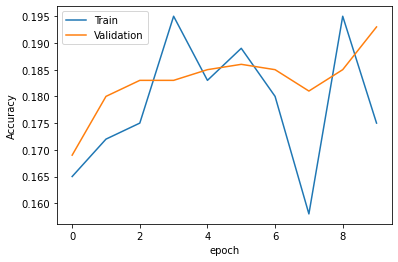

In [33]:
#TODO: plot training and validation accuracy

plt.plot(train_acc_hist, label='Train')
plt.plot(val_acc_hist, label = 'Validation' )
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()